# Package Importing

In [2]:
!pip install keras-tcn

In [291]:
from tensorflow.keras.layers import Input, LSTM, GRU, Dense, Dropout, Concatenate
from tensorflow.keras.models import Model
import io
import os
import time
import warnings
import requests

# import traceback
import kagglehub
import numpy as np
import pandas as pd
from tcn import TCN
import yfinance as yf
import seaborn as sns
import tensorflow as tf
from tqdm.auto import tqdm
from tensorflow import keras
from datetime import datetime
import matplotlib.pyplot as plt
from tensorflow.keras import layers

from pathlib import Path
from pandas.tseries.offsets import DateOffset
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, mean_absolute_error, classification_report
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization
warnings.filterwarnings('ignore', category=pd.errors.PerformanceWarning)
from sklearn.metrics import confusion_matrix, classification_report, mean_absolute_error, accuracy_score

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
# You need to import the TCN layer
from tcn import TCN
from tensorflow.keras.layers import Input, Dense, Dropout, Concatenate # Ensure these are imported
from tensorflow.keras.models import Model # Ensure this is imported
from tensorflow.keras.regularizers import l2 # Import if you plan to use regularization internally
import tensorflow as tf # Ensure tf is imported

# Importing Data

In [292]:
# Import historical crypto dataset using Path and KaggleHub

from pathlib import Path
import pandas as pd

print("--- Importing Data ---")
dataset_path = Path(kagglehub.dataset_download("ayushkhaire/top-1000-cryptos-historical"))
csv_files = [f for f in dataset_path.iterdir() if f.is_file() and f.name.endswith('.csv')]
csv_path = csv_files[0]
df_main_raw = pd.read_csv(dataset_path / csv_path)
print(f"Loaded data from {csv_path}")
print("Data loaded successfully. Shape:", df_main_raw.shape)


--- Importing Data ---
Loaded data from C:\Users\einar\.cache\kagglehub\datasets\ayushkhaire\top-1000-cryptos-historical\versions\288\1000_cryptos.csv
Data loaded successfully. Shape: (2171073, 8)


# Basic Data Cleaning

In [293]:
# Normalize date column to 'dates' and drop rows with invalid dates

print("--- Basic Data Cleaning ---")
df = df_main_raw.copy()

if 'dates' in df.columns:
    df['dates'] = pd.to_datetime(df['dates'], errors='coerce')
    df.dropna(subset=['dates'], inplace=True)
elif 'Date' in df.columns:
    df.rename(columns={'Date': 'dates'}, inplace=True)
    df['dates'] = pd.to_datetime(df['dates'], errors='coerce')
    df.dropna(subset=['dates'], inplace=True)
else:
    raise KeyError("Essential date column ('dates' or 'Date') not found in the initial DataFrame.")


--- Basic Data Cleaning ---


**Setting Start Date**

In [294]:
# Filter dates from 2020 onwards
start_date = pd.to_datetime('2020-01-01')
df = df[df['dates'] >= start_date].copy() # Add .copy() to avoid SettingWithCopyWarning

**Standardizing Columns**

In [295]:
# Standardize key column names and validate essential columns

column_map = {
    'Symbol': 'symbol',
    'Open': 'open',
    'High': 'high',
    'Low': 'low',
    'Close': 'close',
    'Volume': 'volume'
}

df.rename(columns={k: v for k, v in column_map.items() if k in df.columns}, inplace=True)

required_cols = ['symbol', 'open', 'high', 'low', 'close', 'volume']
missing_cols = [col for col in required_cols if col not in df.columns]
if missing_cols:
    raise KeyError(f"Essential columns missing after standardization: {missing_cols}. Available columns: {df.columns.tolist()}")

df = df.sort_values(by=['symbol', 'dates']).reset_index(drop=True)
print("Basic cleaning complete.")

Basic cleaning complete.


# Data Engineering Functions

*Calculating Future Min Low Value*

In [296]:
def _calculate_future_min_low_value(df_single_symbol_indexed, low_col, window_size_str):
    """
    Calculate the rolling future minimum of a column in reverse chronological order
    """
    df_reversed = df_single_symbol_indexed.iloc[::-1]
    rolling_min_l = df_reversed[low_col].shift(-1).rolling(
        window=window_size_str,
        closed='left',
        min_periods=1
    ).min()
    future_min_low = rolling_min_l.iloc[::-1]
    return future_min_low

*Adding future min low value*

In [297]:
def add_future_min_low_value(df_single_symbol, date_col, low_col, window_size_str, new_col_name):
    """
    Add a column with the future minimum of the low value over a time window
    """
    if df_single_symbol.empty:
        df_single_symbol[new_col_name] = np.nan
        return df_single_symbol

    original_index = df_single_symbol.index
    df_indexed = df_single_symbol.set_index(date_col, drop=False)

    if not isinstance(df_indexed.index, pd.DatetimeIndex):
        df_single_symbol[new_col_name] = np.nan
        return df_single_symbol.set_index(original_index)

    future_min_series = _calculate_future_min_low_value(df_indexed, low_col, window_size_str)
    df_single_symbol[new_col_name] = future_min_series.reindex(df_indexed.index).values
    return df_single_symbol

*Adding future min date*

In [299]:
def add_future_min_date_loop(df_single_symbol, date_col, low_col, future_min_val_col, max_shift_days, new_date_col_name):
    """
    Add a column with the future date when the minimum low value occurs within a shift window
    """
    if df_single_symbol.empty:
        df_single_symbol[new_date_col_name] = pd.NaT
        return df_single_symbol

    if not isinstance(df_single_symbol.index, pd.RangeIndex):
        df_single_symbol = df_single_symbol.reset_index(drop=True)

    num_rows = len(df_single_symbol)
    dates_arr = df_single_symbol[date_col].values
    lows_arr = df_single_symbol[low_col].values
    future_mins_arr = df_single_symbol[future_min_val_col].values

    future_dates_output = np.empty(num_rows, dtype='datetime64[ns]')
    future_dates_output[:] = np.datetime64('NaT')

    for i in range(num_rows):
        target_min_value = future_mins_arr[i]
        if pd.isna(target_min_value):
            continue
        current_date = dates_arr[i]
        start_idx = i + 1
        end_search_date_limit = current_date + pd.Timedelta(days=max_shift_days)
        end_idx = start_idx
        while end_idx < num_rows and dates_arr[end_idx] <= end_search_date_limit:
            end_idx += 1
        if start_idx < end_idx:
            window_lows = lows_arr[start_idx:end_idx]
            match_indices_in_window = np.where(np.isclose(window_lows, target_min_value))[0]
            if match_indices_in_window.size > 0:
                actual_future_date_idx = start_idx + match_indices_in_window[0]
                future_dates_output[i] = dates_arr[actual_future_date_idx]

    df_single_symbol[new_date_col_name] = future_dates_output
    return df_single_symbol

In [300]:
def add_days_to_future_min(df, current_date_col, future_min_date_col, new_days_col_name):
    """
    Add a column with number of days until the future minimum date
    """
    if df.empty or future_min_date_col not in df.columns:
        df[new_days_col_name] = np.nan
        return df

    current_dates = pd.to_datetime(df[current_date_col], errors='coerce')
    future_min_dates = pd.to_datetime(df[future_min_date_col], errors='coerce')
    delta = (future_min_dates - current_dates)
    df[new_days_col_name] = delta.dt.days.astype(float)
    df.loc[future_min_dates.isna() | (df[new_days_col_name] < 0), new_days_col_name] = np.nan
    return df

*Adding future min % change*

In [301]:
def add_future_min_pct_change(df, future_min_col, current_price_col, new_col_name):
    """
    Add a column with percent change between current price and future minimum value
    """
    if df.empty or future_min_col not in df.columns or current_price_col not in df.columns:
        df[new_col_name] = np.nan
        return df

    denominator = df[current_price_col].replace(0, np.nan)
    df[new_col_name] = ((df[future_min_col] - df[current_price_col]) / denominator) * 100
    return df

*Adding Symbol lags*

In [302]:
def add_symbol_lags(df_single_symbol, value_col, num_lags):
    """
    Add lagged versions of a value column for a single symbol
    """
    if df_single_symbol.empty:
        return df_single_symbol

    df_copy = df_single_symbol.copy()
    for i in range(1, num_lags + 1):
        col_name = f'{value_col}_lag_{i}'
        df_copy[col_name] = df_copy[value_col].shift(i)

    return df_copy

*Adding BTC lags*

In [303]:
def add_bitcoin_lags(full_df, btc_symbol, date_col, value_col, num_lags):
    """
    Add lagged Bitcoin values to the full DataFrame by date
    """
    btc_df = full_df.loc[full_df['symbol'] == btc_symbol].copy()
    if btc_df.empty:
        for i in range(1, num_lags + 1):
            full_df[f'btc_{value_col}_lag_{i}'] = np.nan
        return full_df

    btc_df = btc_df.sort_values(by=date_col)
    btc_lags_to_merge = btc_df[[date_col]].copy()

    for i in range(1, num_lags + 1):
        lag_col_name = f'btc_{value_col}_lag_{i}'
        btc_lags_to_merge[lag_col_name] = btc_df[value_col].shift(i)

    if not pd.api.types.is_datetime64_any_dtype(full_df[date_col]):
        full_df[date_col] = pd.to_datetime(full_df[date_col])

    cols_to_drop = [col for col in full_df.columns if col.startswith(f'btc_{value_col}_lag_')]
    if cols_to_drop:
        full_df = full_df.drop(columns=cols_to_drop)

    full_df = pd.merge(full_df, btc_lags_to_merge, on=date_col, how='left')
    return full_df

*Adding FRED lags*

In [304]:
FRED_DGS10_URL = "https://fred.stlouisfed.org/graph/fredgraph.csv?bgcolor=%23ebf3fb&chart_type=line&drp=0&fo=open%20sans&graph_bgcolor=%23ffffff&height=450&mode=fred&recession_bars=on&txtcolor=%23444444&ts=12&tts=12&width=1320&nt=0&thu=0&trc=0&show_legend=yes&show_axis_titles=yes&show_tooltip=yes&id=DGS10&scale=left&cosd=1962-01-02&coed=2025-04-28&line_color=%230073e6&link_values=false&line_style=solid&mark_type=none&mw=3&lw=3&ost=-99999&oet=99999&mma=0&fml=a&fq=Daily&fam=avg&fgst=lin&fgsnd=2020-02-01&line_index=1&transformation=lin&vintage_date=2025-04-30&revision_date=2025-04-30&nd=1962-01-02"
FRED_COL_NAME = 'DGS10'
FRED_DATE_COL_CSV = 'DATE'

In [305]:
def add_fred_data_lags(df_to_enrich, main_date_col, num_lags):
    """
    Add lagged FRED data columns to the input DataFrame by matching on date
    """
    try:
        response = requests.get(FRED_DGS10_URL)
        response.raise_for_status()
        temp_fred_df_peek = pd.read_csv(io.StringIO(response.text), nrows=1)

        actual_fred_date_col = FRED_DATE_COL_CSV
        if FRED_DATE_COL_CSV not in temp_fred_df_peek.columns:
            if 'observation_date' in temp_fred_df_peek.columns:
                actual_fred_date_col = 'observation_date'
            else:
                date_like_cols = [col for col in temp_fred_df_peek.columns if 'date' in col.lower()]
                if date_like_cols:
                    actual_fred_date_col = date_like_cols[0]
                else:
                    raise ValueError(f"Could not automatically find date column in FRED data. Expected '{FRED_DATE_COL_CSV}' or 'observation_date'. Found: {temp_fred_df_peek.columns}")

        fred_data = pd.read_csv(io.StringIO(response.text), parse_dates=[actual_fred_date_col])
        fred_data.rename(columns={actual_fred_date_col: main_date_col, FRED_COL_NAME: FRED_COL_NAME}, inplace=True)
        fred_data[main_date_col] = pd.to_datetime(fred_data[main_date_col]).dt.normalize()
        fred_data[FRED_COL_NAME] = pd.to_numeric(fred_data[FRED_COL_NAME], errors='coerce')
        fred_data[FRED_COL_NAME] = fred_data[FRED_COL_NAME].ffill()
        fred_data = fred_data.sort_values(main_date_col)

        fred_lags_to_merge = fred_data[[main_date_col]].copy()
        target_lag_cols = []
        for i in range(1, num_lags + 1):
            col = f'{FRED_COL_NAME}_lag_{i}'
            fred_lags_to_merge[col] = fred_data[FRED_COL_NAME].shift(i)
            target_lag_cols.append(col)

        if not pd.api.types.is_datetime64_any_dtype(df_to_enrich[main_date_col]):
            df_to_enrich[main_date_col] = pd.to_datetime(df_to_enrich[main_date_col])
        df_to_enrich[main_date_col] = df_to_enrich[main_date_col].dt.normalize()

        existing_cols_to_drop = [col for col in target_lag_cols if col in df_to_enrich.columns]
        if existing_cols_to_drop:
            df_to_enrich = df_to_enrich.drop(columns=existing_cols_to_drop)

        df_enriched = pd.merge(df_to_enrich, fred_lags_to_merge, on=main_date_col, how='left')
        return df_enriched

    except Exception:
        for i in range(1, num_lags + 1):
            df_to_enrich[f'{FRED_COL_NAME}_lag_{i}'] = np.nan
        return df_to_enrich


*Adding Fear & Greed Index*

In [306]:
def get_fear_greed_index(limit=0, format_type='json'):
    """
    Fetch the Fear & Greed Index and return a DataFrame with date and value
    """
    url = "https://api.alternative.me/fng/"
    params = {'limit': str(limit), 'format': format_type}

    try:
        response = requests.get(url, params=params)
        response.raise_for_status()
        data = response.json()['data']
        fng_df = pd.DataFrame(data)
        fng_df['value'] = pd.to_numeric(fng_df['value'])
        fng_df['datetime'] = pd.to_datetime(fng_df['timestamp'], unit='s').dt.normalize()
        return fng_df[['datetime', 'value']]

    except Exception:
        return pd.DataFrame(columns=['datetime', 'value'])


In [307]:
def fetch_and_add_fng_lags(df_to_enrich, main_date_col, num_lags):
    """
    Fetch Fear & Greed Index and add lagged values to the input DataFrame
    """
    fng_df = get_fear_greed_index()
    if fng_df.empty:
        for i in range(1, num_lags + 1):
            df_to_enrich[f'fng_value_lag_{i}'] = np.nan
        return df_to_enrich

    fng_df = fng_df.sort_values('datetime')
    fng_lags_to_merge = fng_df[['datetime']].copy()
    target_lag_cols = []

    for i in range(1, num_lags + 1):
        col = f'fng_value_lag_{i}'
        fng_lags_to_merge[col] = fng_df['value'].shift(i)
        target_lag_cols.append(col)

    fng_lags_to_merge.rename(columns={'datetime': main_date_col}, inplace=True)

    if not pd.api.types.is_datetime64_any_dtype(df_to_enrich[main_date_col]):
        df_to_enrich[main_date_col] = pd.to_datetime(df_to_enrich[main_date_col])
    df_to_enrich[main_date_col] = df_to_enrich[main_date_col].dt.normalize()

    existing_cols_to_drop = [col for col in target_lag_cols if col in df_to_enrich.columns]
    if existing_cols_to_drop:
        df_to_enrich = df_to_enrich.drop(columns=existing_cols_to_drop)

    df_enriched = pd.merge(df_to_enrich, fng_lags_to_merge, on=main_date_col, how='left')
    return df_enriched


*Adding S&P500 lags*

In [308]:
def fetch_and_add_sp500_lags(df_to_enrich, main_date_col, num_lags):
    """
    Fetch S&P 500 closing prices and add lagged values to the input DataFrame
    """
    try:
        start_date_fetch = df_to_enrich[main_date_col].min() - pd.Timedelta(days=num_lags + 90)
        end_date_fetch = df_to_enrich[main_date_col].max() + pd.Timedelta(days=1)

        sp500_data = yf.download('^GSPC', start=start_date_fetch, end=end_date_fetch, progress=False, auto_adjust=True)
        if sp500_data.empty:
            raise ValueError("No S&P500 data downloaded.")

        sp500_data.index = pd.to_datetime(sp500_data.index).normalize()
        sp500_data = sp500_data[['Close']].rename(columns={'Close': 'SP500_Close'})
        sp500_data = sp500_data.sort_index()

        sp500_lags_to_merge = pd.DataFrame(index=sp500_data.index)
        target_lag_cols = []
        for i in range(1, num_lags + 1):
            col = f'sp500_close_lag_{i}'
            sp500_lags_to_merge[col] = sp500_data['SP500_Close'].shift(i)
            target_lag_cols.append(col)

        sp500_lags_to_merge.reset_index(inplace=True)
        sp500_lags_to_merge.rename(columns={'Date': main_date_col, 'index': main_date_col}, inplace=True, errors='ignore')

        if not pd.api.types.is_datetime64_any_dtype(df_to_enrich[main_date_col]):
            df_to_enrich[main_date_col] = pd.to_datetime(df_to_enrich[main_date_col])
        df_to_enrich[main_date_col] = df_to_enrich[main_date_col].dt.normalize()

        existing_cols_to_drop = [col for col in target_lag_cols if col in df_to_enrich.columns]
        if existing_cols_to_drop:
            df_to_enrich = df_to_enrich.drop(columns=existing_cols_to_drop)

        df_enriched = pd.merge(df_to_enrich, sp500_lags_to_merge, on=main_date_col, how='left')
        return df_enriched

    except Exception:
        for i in range(1, num_lags + 1):
            df_to_enrich[f'sp500_close_lag_{i}'] = np.nan
        return df_to_enrich

# Data Splitting

In [323]:
def _split_data_chronological_with_buffer(df_symbol_specific, date_col,
                                          val_period_months=11, test_period_months=7,
                                          buffer_days=7):
    """
    Split data chronologically into train, validation, and test sets with buffers between periods
    """
    df_sorted = df_symbol_specific.sort_values(date_col).reset_index(drop=True)

    if df_sorted.empty:
        cols = df_sorted.columns if not df_sorted.empty else [date_col]
        return pd.DataFrame(columns=cols), pd.DataFrame(columns=cols), pd.DataFrame(columns=cols)

    latest_date = df_sorted[date_col].max()
    earliest_date = df_sorted[date_col].min()

    test_set_start_date = latest_date - pd.DateOffset(months=test_period_months) + pd.DateOffset(days=1)
    val_set_end_date = test_set_start_date - pd.DateOffset(days=buffer_days) - pd.DateOffset(days=1)
    val_set_start_date = val_set_end_date - pd.DateOffset(months=val_period_months) + pd.DateOffset(days=1)
    train_set_end_date = val_set_start_date - pd.DateOffset(days=buffer_days) - pd.DateOffset(days=1)

    test_df = df_sorted[df_sorted[date_col] >= max(test_set_start_date, earliest_date)]
    val_df = df_sorted[(df_sorted[date_col] >= max(val_set_start_date, earliest_date)) & (df_sorted[date_col] <= val_set_end_date)]
    train_df = df_sorted[df_sorted[date_col] <= train_set_end_date]
    train_df = train_df[train_df[date_col] >= earliest_date]

    return train_df.copy(), val_df.copy(), test_df.copy()

# Preprocessing

**Global Paramters**

In [357]:
DATE_COL = 'dates'
SYMBOL_COL = 'symbol'
LOW_COL = 'low'
CLOSE_COL = 'close'
TARGET_COLS_FINAL = ['binary_target', 'days_to_future_min_7d']

FUTURE_MIN_WINDOW_DAYS = 7
FUTURE_MIN_WINDOW_STR = f'{FUTURE_MIN_WINDOW_DAYS}D'
FUTURE_MIN_COL = f'future_min_low_{FUTURE_MIN_WINDOW_DAYS}d'
FUTURE_MIN_DATE_COL = f'future_min_date_{FUTURE_MIN_WINDOW_DAYS}d'
FUTURE_PCT_CHANGE_COL = f'future_min_pct_change_{FUTURE_MIN_WINDOW_DAYS}d'
DAYS_TO_MIN_COL = f'days_to_future_min_{FUTURE_MIN_WINDOW_DAYS}d'

SELF_LAG_NUM = 30
BTC_LAG_NUM = 30 # Selv om vi kun ser på ETH, kan BTC-lags være relevant
FRED_NUM_LAGS = 30
FNG_NUM_LAGS = 30
SP500_NUM_LAGS = 30
BINARY_TARGET_PERCENTILE = 40
TIME_STEPS = 10

VAL_MONTHS = 11
TEST_MONTHS = 7
BUFFER_DAYS = 7


**1. Adding External Factors**

In [358]:
# Prepare enriched dataset and add external lags

df_enriched_full = df.copy()
print("Adding external factor lags globally...")

# Ensure BTC-USD is available before computing BTC lags
if 'BTC-USD' in df_enriched_full[SYMBOL_COL].unique():
    df_enriched_full = add_bitcoin_lags(df_enriched_full, 'BTC-USD', DATE_COL, CLOSE_COL, BTC_LAG_NUM)
else:
    for i in range(1, BTC_LAG_NUM + 1):
        df_enriched_full[f'btc_{CLOSE_COL}_lag_{i}'] = np.nan

df_enriched_full = add_fred_data_lags(df_enriched_full, DATE_COL, FRED_NUM_LAGS)
df_enriched_full = fetch_and_add_sp500_lags(df_enriched_full, DATE_COL, SP500_NUM_LAGS)
df_enriched_full = fetch_and_add_fng_lags(df_enriched_full, DATE_COL, FNG_NUM_LAGS)

print("External lags added.")

# Specify symbol(s) to process
symbols_to_process = ['ETH-USD']
print(f"Will process ONLY the following symbol(s): {symbols_to_process}")

all_symbols_modeling_data = {}
all_symbols_processed_dfs_for_eda = {}


Adding external factor lags globally...


C:\Users\einar\AppData\Local\Temp\ipykernel_1328\4151407696.py:14: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  fng_df['datetime'] = pd.to_datetime(fng_df['timestamp'], unit='s').dt.normalize()


External lags added.
Will process ONLY the following symbol(s): ['ETH-USD']


In [326]:
print(df_enriched_full.columns)

Index(['dates', 'symbol', 'open', 'close', 'high', 'low', 'volume',
       'adj_close', 'btc_close_lag_1', 'btc_close_lag_2', 'btc_close_lag_3',
       'btc_close_lag_4', 'btc_close_lag_5', 'btc_close_lag_6',
       'btc_close_lag_7', 'DGS10_lag_1', 'DGS10_lag_2', 'DGS10_lag_3',
       'DGS10_lag_4', 'DGS10_lag_5', 'DGS10_lag_6', 'DGS10_lag_7',
       'sp500_close_lag_1', 'sp500_close_lag_2', 'sp500_close_lag_3',
       'sp500_close_lag_4', 'sp500_close_lag_5', 'sp500_close_lag_6',
       'sp500_close_lag_7', 'fng_value_lag_1', 'fng_value_lag_2',
       'fng_value_lag_3', 'fng_value_lag_4', 'fng_value_lag_5',
       'fng_value_lag_6', 'fng_value_lag_7'],
      dtype='object')


**2. Generating Target Variables**

In [359]:
# Loop will now only run for 'ETH-USD'
for target_symbol in tqdm(symbols_to_process, desc="Processing Symbols"):
    print(f"\n--- Processing: {target_symbol} ---")
    df_symbol_specific = df_enriched_full[df_enriched_full[SYMBOL_COL] == target_symbol].copy()

    if df_symbol_specific.empty:
        continue

    # Chronological split into train, validation, test
    train_df, val_df, test_df = _split_data_chronological_with_buffer(
        df_symbol_specific, DATE_COL, VAL_MONTHS, TEST_MONTHS, BUFFER_DAYS
    )
    if train_df.empty:
        continue

    # Target variable generation
    for split_name, df_split_ref_tuple in [('train', train_df), ('validation', val_df), ('test', test_df)]:
        df_split_ref = df_split_ref_tuple
        if df_split_ref.empty:
            continue
        temp_split_df = df_split_ref.copy()
        temp_split_df = add_future_min_low_value(temp_split_df, DATE_COL, LOW_COL, FUTURE_MIN_WINDOW_STR, FUTURE_MIN_COL)
        temp_split_df = add_future_min_date_loop(temp_split_df, DATE_COL, LOW_COL, FUTURE_MIN_COL, FUTURE_MIN_WINDOW_DAYS, FUTURE_MIN_DATE_COL)
        temp_split_df = add_days_to_future_min(temp_split_df, DATE_COL, FUTURE_MIN_DATE_COL, DAYS_TO_MIN_COL)
        temp_split_df = add_future_min_pct_change(temp_split_df, FUTURE_MIN_COL, CLOSE_COL, FUTURE_PCT_CHANGE_COL)
        if split_name == 'train':
            train_df = temp_split_df
        elif split_name == 'validation':
            val_df = temp_split_df
        elif split_name == 'test':
            test_df = temp_split_df

    # Threshold generation and binary target
    if not train_df.empty and FUTURE_PCT_CHANGE_COL in train_df.columns and not train_df[FUTURE_PCT_CHANGE_COL].dropna().empty:
        threshold_value = np.percentile(train_df[FUTURE_PCT_CHANGE_COL].dropna(), BINARY_TARGET_PERCENTILE)
        print(f"  {target_symbol}: Threshold ({BINARY_TARGET_PERCENTILE}th pctl from train): {threshold_value:.2f}%")
        train_df.loc[:, 'binary_target'] = (train_df[FUTURE_PCT_CHANGE_COL] <= threshold_value).astype(int)
        if not val_df.empty:
            val_df.loc[:, 'binary_target'] = (val_df[FUTURE_PCT_CHANGE_COL] <= threshold_value).astype(int)
        if not test_df.empty:
            test_df.loc[:, 'binary_target'] = (test_df[FUTURE_PCT_CHANGE_COL] <= threshold_value).astype(int)
    else:
        if not train_df.empty:
            train_df.loc[:, 'binary_target'] = 0
        if not val_df.empty:
            val_df.loc[:, 'binary_target'] = 0
        if not test_df.empty:
            test_df.loc[:, 'binary_target'] = 0

    # Drop rows with NaNs in target columns
    for split_df_ref_tuple, name in [(train_df, 'train'), (val_df, 'validation'), (test_df, 'test')]:
        split_df_ref = split_df_ref_tuple
        if split_df_ref.empty:
            continue
        original_len = len(split_df_ref)
        cols_to_check_na = [tc for tc in TARGET_COLS_FINAL if tc in split_df_ref.columns]
        current_df_copy = split_df_ref.copy()
        if cols_to_check_na:
            current_df_copy.dropna(subset=cols_to_check_na, inplace=True)
        if len(current_df_copy) < original_len:
            print(f"  {target_symbol} ({name}): Dropped {original_len - len(current_df_copy)} rows (NaNs in targets).")
        if name == 'train':
            train_df = current_df_copy
        elif name == 'validation':
            val_df = current_df_copy
        elif name == 'test':
            test_df = current_df_copy

    if train_df.empty:
        continue

    # Add self-lags
    train_df = add_symbol_lags(train_df.copy(), CLOSE_COL, SELF_LAG_NUM)
    if not val_df.empty:
        val_df = add_symbol_lags(val_df.copy(), CLOSE_COL, SELF_LAG_NUM)
    if not test_df.empty:
        test_df = add_symbol_lags(test_df.copy(), CLOSE_COL, SELF_LAG_NUM)

    # Drop NaNs after lagging
    train_df.dropna(inplace=True)
    if not val_df.empty:
        val_df.dropna(inplace=True)
    if not test_df.empty:
        test_df.dropna(inplace=True)

    if train_df.empty:
        continue

    all_symbols_processed_dfs_for_eda[target_symbol] = {
        'train': train_df.copy(),
        'val': val_df.copy(),
        'test': test_df.copy()
    }

    # Identify numeric features to use for modeling
    cols_to_exclude_as_features = (
        TARGET_COLS_FINAL +
        [DATE_COL, SYMBOL_COL, FUTURE_MIN_COL, FUTURE_MIN_DATE_COL, FUTURE_PCT_CHANGE_COL,
         'adj_close', 'slug', 'name', 'ranknow', 'open', 'high', 'volume']
    )
    feature_candidates = [col for col in train_df.columns if col not in cols_to_exclude_as_features]
    numeric_features = train_df[feature_candidates].select_dtypes(include=np.number).columns.tolist()

    if not numeric_features:
        continue

    X_train_raw, y_train_df = train_df[numeric_features], train_df[TARGET_COLS_FINAL]
    X_val_raw, y_val_df = (
        val_df[numeric_features], val_df[TARGET_COLS_FINAL]
    ) if not val_df.empty else (
        pd.DataFrame(columns=numeric_features), pd.DataFrame(columns=TARGET_COLS_FINAL)
    )

    # Scaling
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train_raw)
    X_train_final = pd.DataFrame(X_train_scaled, columns=numeric_features, index=X_train_raw.index)

    X_val_final = pd.DataFrame(columns=numeric_features)
    if not X_val_raw.empty:
        X_val_scaled = scaler.transform(X_val_raw)
        X_val_final = pd.DataFrame(X_val_scaled, columns=numeric_features, index=X_val_raw.index)

    def create_sequences(X, y, time_steps=10):
        Xs, y_bin, y_reg = [], [], []
        for i in range(len(X) - time_steps):
            Xs.append(X.iloc[i:i+time_steps].values)
            y_bin.append(y['binary_target'].iloc[i + time_steps])
            y_reg.append(y[DAYS_TO_MIN_COL].iloc[i + time_steps])
        return np.array(Xs), np.array(y_bin), np.array(y_reg)

    # Sequence generation
    X_train_seq, y_train_bin_seq, y_train_reg_seq = create_sequences(X_train_final, y_train_df, TIME_STEPS)

    X_val_seq, y_val_bin_seq, y_val_reg_seq = np.array([]), np.array([]), np.array([])
    if not X_val_final.empty and not y_val_df.empty and len(X_val_final) > TIME_STEPS:
        X_val_seq, y_val_bin_seq, y_val_reg_seq = create_sequences(X_val_final, y_val_df, TIME_STEPS)

    if X_train_seq.size == 0:
        continue

    # Store data for modeling
    all_symbols_modeling_data[target_symbol] = {
        'X_train_seq': X_train_seq,
        'y_train_bin_seq': y_train_bin_seq,
        'y_train_reg_seq': y_train_reg_seq,
        'X_val_seq': X_val_seq,
        'y_val_bin_seq': y_val_bin_seq,
        'y_val_reg_seq': y_val_reg_seq,
        'scaler': scaler,
        'numeric_features': numeric_features,
        'time_steps': TIME_STEPS,
        'input_shape': (X_train_seq.shape[1], X_train_seq.shape[2]) if X_train_seq.ndim == 3 and X_train_seq.shape[0] > 0 else None
    }

    print(f"Finished processing for {target_symbol}. Train seq shape: {X_train_seq.shape if X_train_seq.size > 0 else 'N/A'}")

print("--- Master Preprocessing Pipeline Finished ---")


Processing Symbols:   0%|          | 0/1 [00:00<?, ?it/s]


--- Processing: ETH-USD ---
  ETH-USD: Threshold (40th pctl from train): -7.08%
  ETH-USD (train): Dropped 403 rows (NaNs in targets).
  ETH-USD (validation): Dropped 106 rows (NaNs in targets).
  ETH-USD (test): Dropped 55 rows (NaNs in targets).
Finished processing for ETH-USD. Train seq shape: (591, 10, 152)
--- Master Preprocessing Pipeline Finished ---


In [328]:
all_symbols_modeling_data["ETH-USD"]

{'X_train_seq': array([[[0.0124332 , 0.01119314, 0.04126382, ..., 0.0045578 ,
          0.00325848, 0.00392679],
         [0.01220281, 0.01185393, 0.04018614, ..., 0.00931711,
          0.00576113, 0.00615162],
         [0.01190428, 0.01206112, 0.04162404, ..., 0.01030456,
          0.01165624, 0.00566671],
         ...,
         [0.01334185, 0.01385761, 0.05160675, ..., 0.00947755,
          0.01363235, 0.0124332 ],
         [0.01649409, 0.01667134, 0.05137499, ..., 0.00951026,
          0.01181614, 0.01340894],
         [0.03314058, 0.03206367, 0.06736976, ..., 0.009765  ,
          0.01240612, 0.01165456]],
 
        [[0.01220281, 0.01185393, 0.04018614, ..., 0.00931711,
          0.00576113, 0.00615162],
         [0.01190428, 0.01206112, 0.04162404, ..., 0.01030456,
          0.01165624, 0.00566671],
         [0.0107626 , 0.01065475, 0.04056468, ..., 0.01129993,
          0.01264035, 0.01146522],
         ...,
         [0.01649409, 0.01667134, 0.05137499, ..., 0.00951026,
         

# EDA Functions

**Plotting Target Distribution**


In [329]:
def plot_target_distribution(df_dict, symbol):
    """Plot the distribution of binary and regression target variables for a given symbol."""
    if symbol not in df_dict or 'train' not in df_dict[symbol]:
        print(f"No processed training data for EDA for symbol {symbol}")
        return

    train_data = df_dict[symbol]['train']
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    fig.suptitle(f'Target Variable Distributions for {symbol} (Training Data)', fontsize=16)

    # Binary Target Distribution
    if 'binary_target' in train_data.columns:
        sns.countplot(x='binary_target', data=train_data, ax=axes[0], palette="viridis")
        axes[0].set_title('Distribution of Binary Target')
        axes[0].set_xlabel('Binary Target (0=No Drop, 1=Drop)')
        axes[0].set_ylabel('Count')

        for container in axes[0].containers:
            axes[0].bar_label(container)
    else:
        axes[0].set_title('Binary Target Not Available')

    # Regression Target Distribution
    if DAYS_TO_MIN_COL in train_data.columns:
        sns.histplot(train_data[DAYS_TO_MIN_COL].dropna(), kde=True, ax=axes[1], color="skyblue")
        axes[1].set_title('Distribution of Days to Future Min (30d)')
        axes[1].set_xlabel('Days to Future Minimum')
        axes[1].set_ylabel('Frequency')
    else:
        axes[1].set_title('Regression Target Not Available')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

**Plotting Feature Correlations**

In [330]:
def plot_feature_correlations(df_dict, symbol, numeric_features_list):
    """Plot a heatmap of feature correlations for a given symbol's training set."""
    if symbol not in df_dict or 'train' not in df_dict[symbol]:
        print(f"No processed training data for EDA for symbol {symbol}")
        return

    if not numeric_features_list:
        print(f"No numeric features provided for {symbol} to plot correlation.")
        return

    train_data = df_dict[symbol]['train']
    existing_numeric_features = [feat for feat in numeric_features_list if feat in train_data.columns]

    if not existing_numeric_features:
        print(f"Numeric features list for {symbol} resulted in no common columns with the dataframe.")
        return

    correlation_matrix = train_data[existing_numeric_features].corr()

    plt.figure(figsize=(12, 10))
    sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt=".1f")
    plt.title(f'Feature Correlation Matrix for {symbol} (Training Data)', fontsize=16)
    plt.show()

**Plotting Price over Time**

In [331]:
def plot_price_vs_time(df_dict, symbol, date_col='dates', price_col='close'):
    """Plot closing price over time for a given symbol across train, validation, and test sets."""
    if symbol not in df_dict or 'train' not in df_dict[symbol]:
        print(f"No processed training data available for symbol {symbol}")
        return

    train_data = df_dict[symbol]['train']
    val_data = df_dict[symbol].get('val', pd.DataFrame())
    test_data = df_dict[symbol].get('test', pd.DataFrame())

    plt.figure(figsize=(15, 7))
    if not train_data.empty and date_col in train_data.columns and price_col in train_data.columns:
        plt.plot(train_data[date_col], train_data[price_col], label='Train Close Price', color='blue')
    if not val_data.empty and date_col in val_data.columns and price_col in val_data.columns:
        plt.plot(val_data[date_col], val_data[price_col], label='Validation Close Price', color='orange')
    if not test_data.empty and date_col in test_data.columns and price_col in test_data.columns:
        plt.plot(test_data[date_col], test_data[price_col], label='Test Close Price', color='green')

    plt.title(f'Close Price Over Time for {symbol}', fontsize=16)
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.legend()
    plt.grid(True)
    plt.show()

**Plotting Features vs Target**

In [332]:
def plot_selected_features_vs_target(df_dict, symbol, features_to_plot, target_col='binary_target'):
    """Plots selected features against the target variable."""
    if symbol not in df_dict or 'train' not in df_dict[symbol]:
        print(f"No processed training data for EDA for symbol {symbol}")
        return

    train_data = df_dict[symbol]['train']
    if target_col not in train_data.columns:
        print(f"Target column '{target_col}' not found for {symbol}.")
        return

    # Ensure features_to_plot actually exist in the dataframe
    valid_features = [feat for feat in features_to_plot if feat in train_data.columns]
    if not valid_features:
        print(f"None of the specified features to plot exist for {symbol}.")
        return

    num_features = len(valid_features)
    if num_features == 0:
        print("No valid features to plot.")
        return

    cols = 3
    rows = (num_features + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 5 * rows))
    axes = axes.flatten() # Flatten in case of single row/col

    for i, feature in enumerate(valid_features):
        sns.boxplot(x=target_col, y=feature, data=train_data, ax=axes[i], palette="pastel")
        axes[i].set_title(f'{feature} vs {target_col}')

    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.suptitle(f'Feature vs. Target ({target_col}) for {symbol} (Training Data)', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Plotting EDA


--- Running Exploratory Data Analysis (EDA) ---

--- EDA for ETH-USD ---


C:\Users\einar\AppData\Local\Temp\ipykernel_1328\979732112.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='binary_target', data=train_data, ax=axes[0], palette="viridis")


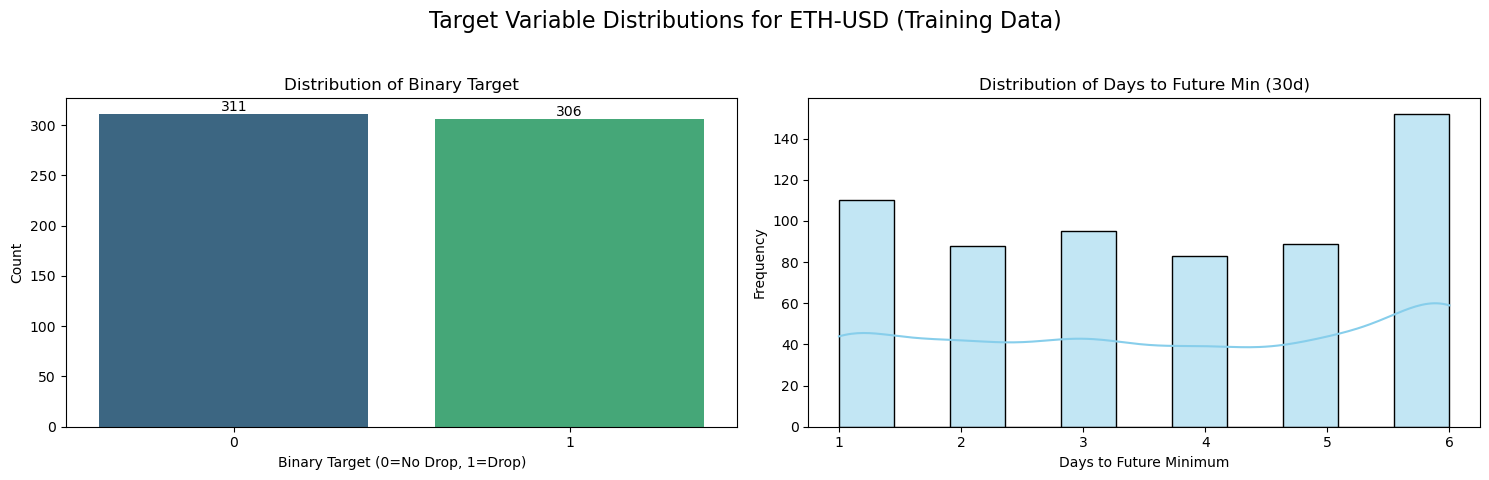

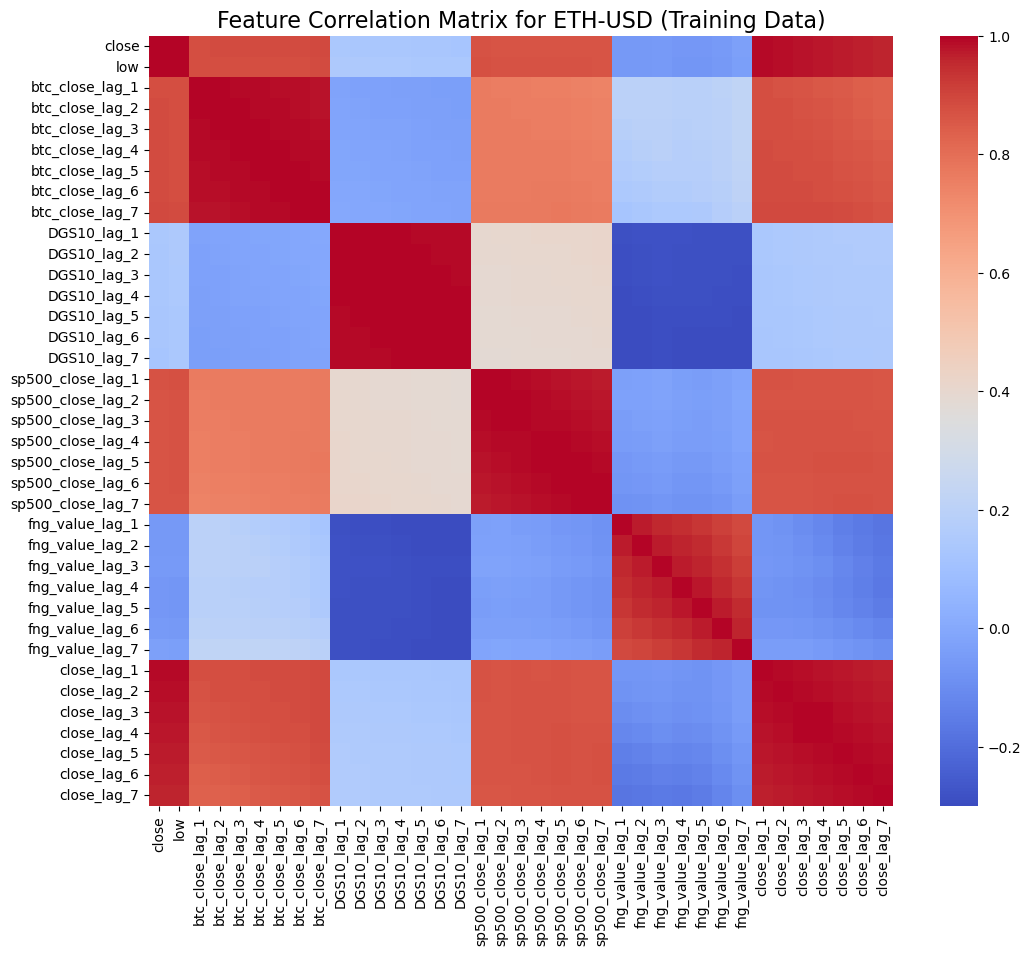

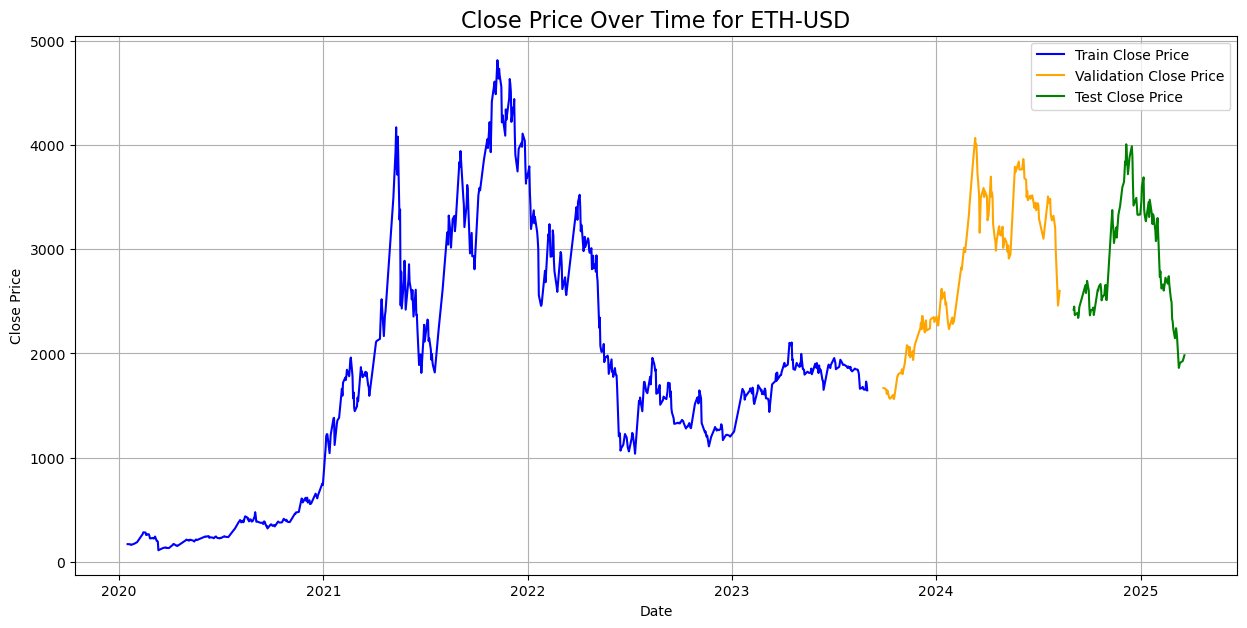

C:\Users\einar\AppData\Local\Temp\ipykernel_1328\3778009241.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target_col, y=feature, data=train_data, ax=axes[i], palette="pastel")
C:\Users\einar\AppData\Local\Temp\ipykernel_1328\3778009241.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target_col, y=feature, data=train_data, ax=axes[i], palette="pastel")
C:\Users\einar\AppData\Local\Temp\ipykernel_1328\3778009241.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target_col, y=feature, data=train_data, ax=axes[i], palette="p

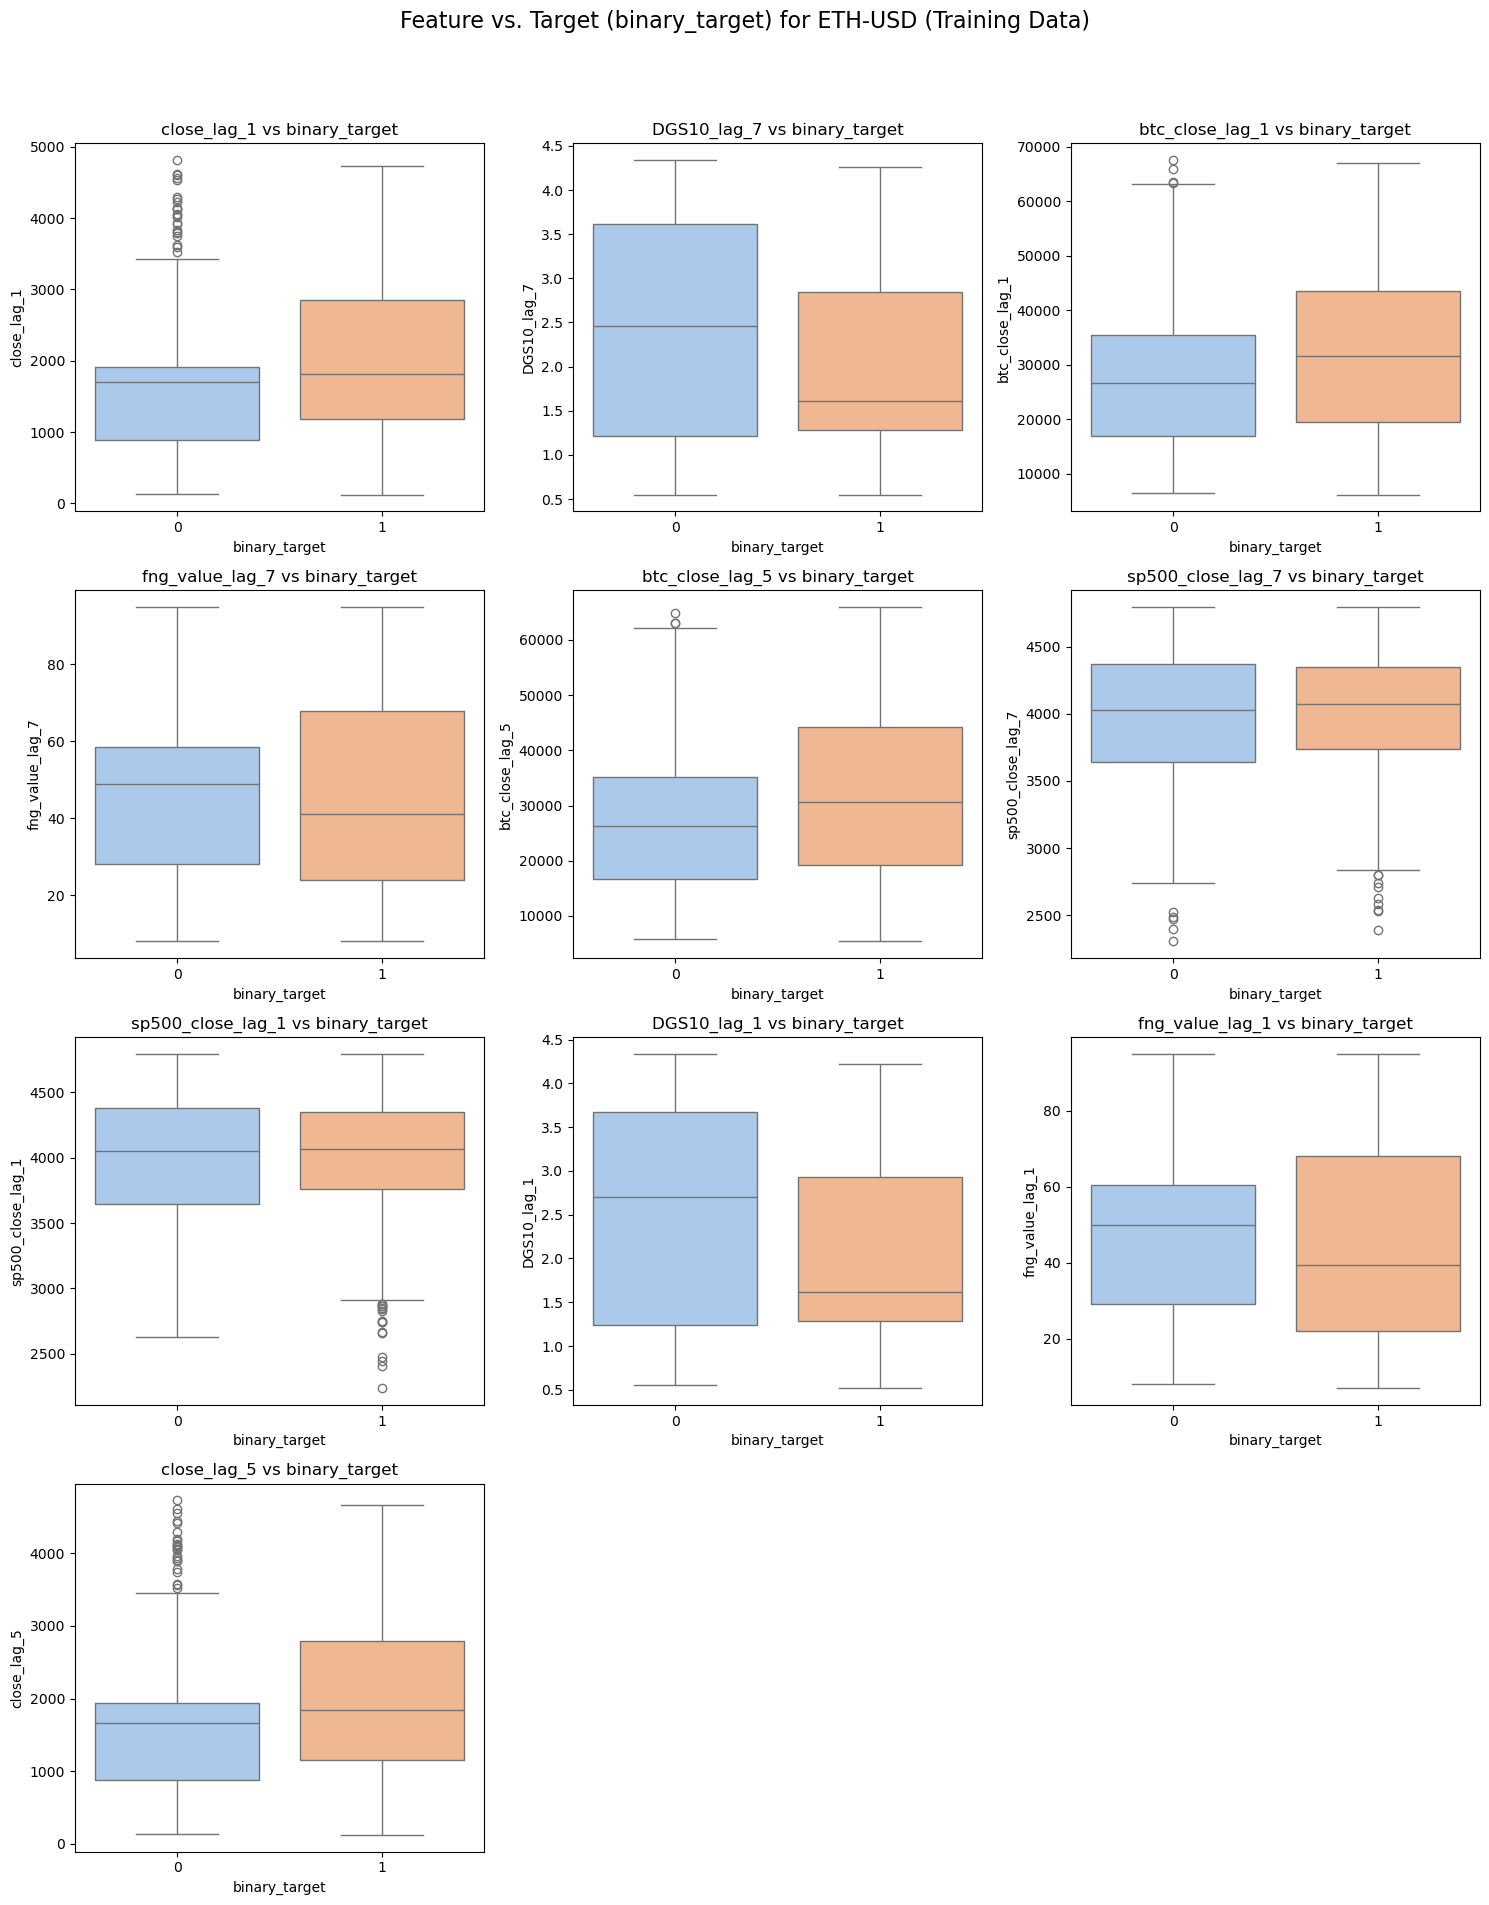


--- EDA Finished ---


In [333]:
print("\n--- Running Exploratory Data Analysis (EDA) ---")
for symbol_eda in symbols_to_process:
    if symbol_eda in all_symbols_processed_dfs_for_eda:
        print(f"\n--- EDA for {symbol_eda} ---")

        # 1. Plot target distributions
        plot_target_distribution(all_symbols_processed_dfs_for_eda, symbol_eda)

        # 2. Plot feature correlations
        if symbol_eda in all_symbols_modeling_data:
            numeric_features_for_symbol = all_symbols_modeling_data[symbol_eda].get('numeric_features', [])
            if numeric_features_for_symbol:
                plot_feature_correlations(all_symbols_processed_dfs_for_eda, symbol_eda, numeric_features_for_symbol)
            else:
                print(f"No numeric features found for {symbol_eda} in all_symbols_modeling_data to plot correlations.")
        else:
            print(f"No modeling data found for {symbol_eda}; cannot plot feature correlations.")

        # 3. Plot price over time
        plot_price_vs_time(all_symbols_processed_dfs_for_eda, symbol_eda, date_col=DATE_COL, price_col=CLOSE_COL)

        # 4. Plot selected features vs. binary target
        features_for_boxplot = []
        if symbol_eda in all_symbols_modeling_data and all_symbols_modeling_data[symbol_eda].get('numeric_features'):
            all_num_feats = all_symbols_modeling_data[symbol_eda]['numeric_features']

            features_for_boxplot.extend([f'{CLOSE_COL}_lag_{i}' for i in [1, 5, 10] if f'{CLOSE_COL}_lag_{i}' in all_num_feats])
            features_for_boxplot.extend([f'btc_{CLOSE_COL}_lag_{i}' for i in [1, 5] if f'btc_{CLOSE_COL}_lag_{i}' in all_num_feats])
            features_for_boxplot.extend([f'{FRED_COL_NAME}_lag_{i}' for i in [1, 7] if f'{FRED_COL_NAME}_lag_{i}' in all_num_feats])
            features_for_boxplot.extend([f'fng_value_lag_{i}' for i in [1, 7] if f'fng_value_lag_{i}' in all_num_feats])
            features_for_boxplot.extend([f'sp500_close_lag_{i}' for i in [1, 7] if f'sp500_close_lag_{i}' in all_num_feats])

            features_for_boxplot = list(set(features_for_boxplot))  # Deduplicate

            if features_for_boxplot:
                plot_selected_features_vs_target(all_symbols_processed_dfs_for_eda, symbol_eda, features_for_boxplot, target_col='binary_target')
            else:
                print(f"No suitable features found for boxplot for {symbol_eda}")
        else:
            print(f"Numeric features not available for {symbol_eda} to generate boxplots.")
    else:
        print(f"No processed data available for EDA for symbol {symbol_eda}")

print("\n--- EDA Finished ---")


--- Running Exploratory Data Analysis (EDA) ---

--- EDA for ETH-USD ---


C:\Users\einar\AppData\Local\Temp\ipykernel_1328\979732112.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='binary_target', data=train_data, ax=axes[0], palette="viridis")


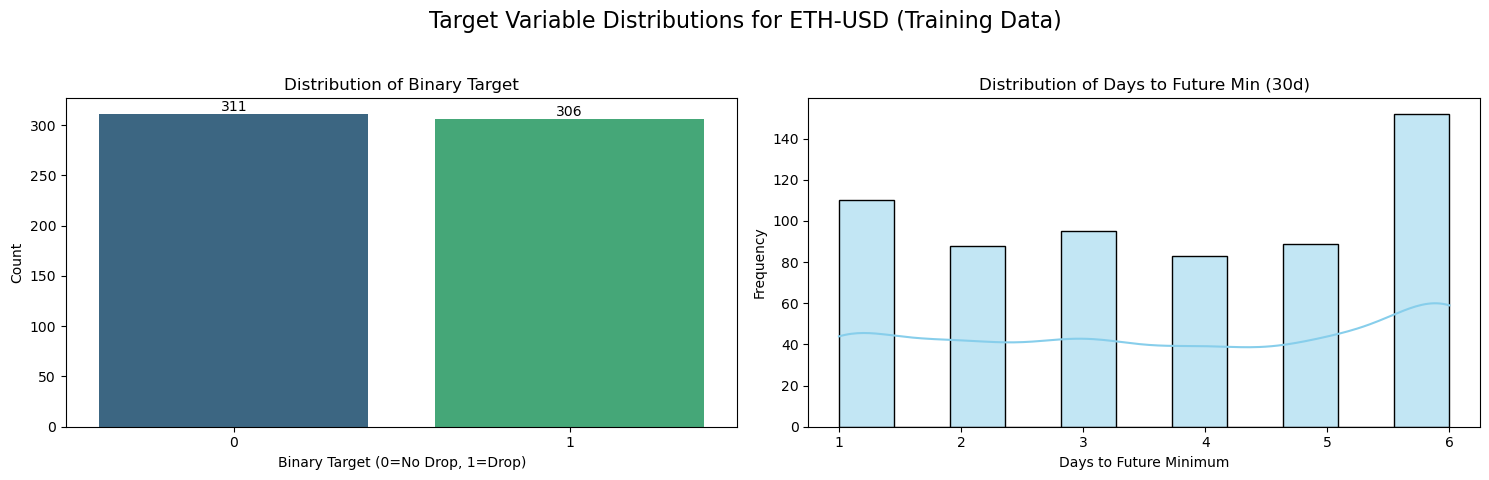

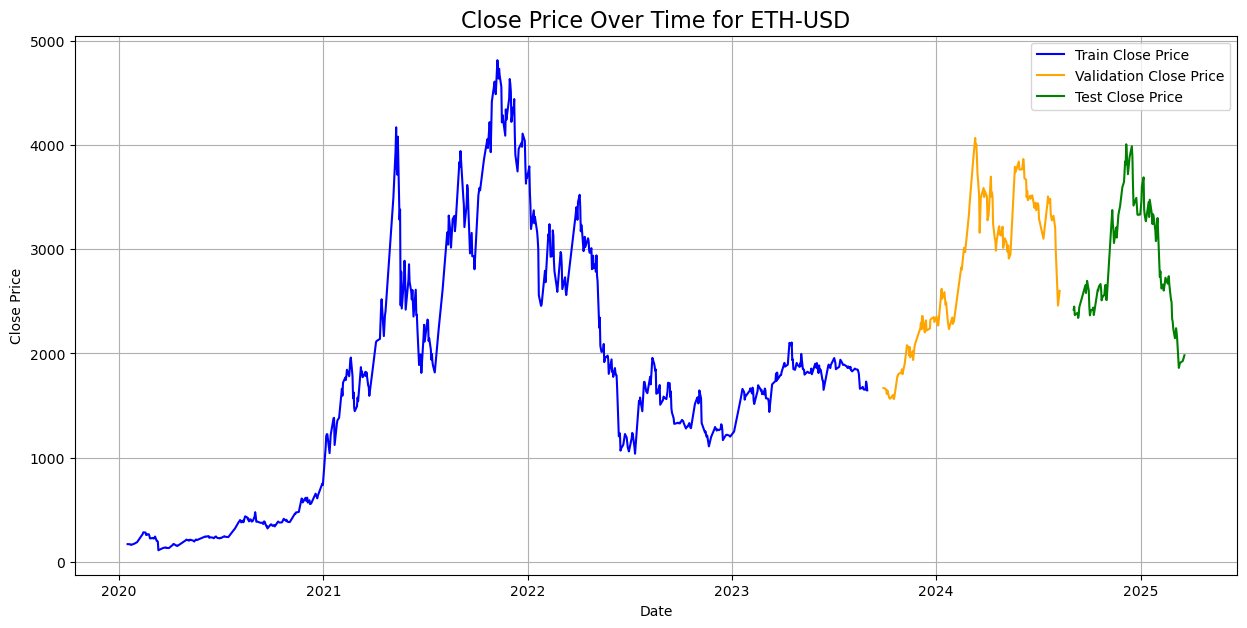

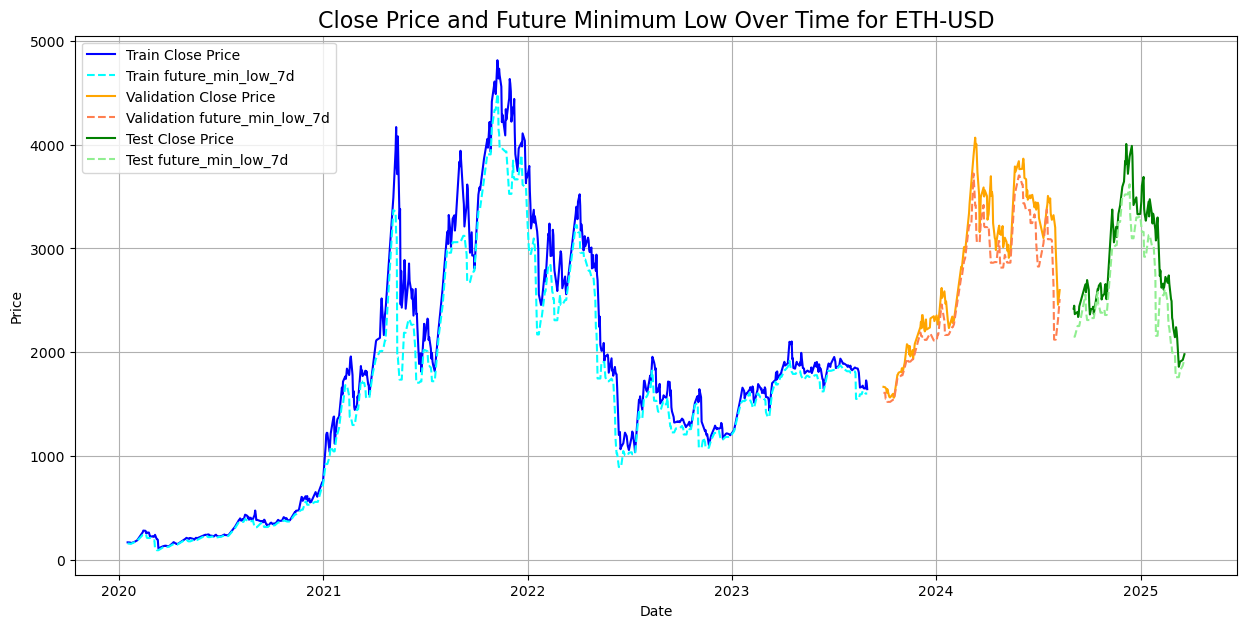

In [334]:
import pandas as pd
import matplotlib.pyplot as plt
def plot_price_with_min_low_over_time(df_dict, symbol, date_col='dates', price_col='close', min_low_col=FUTURE_MIN_COL):
    """
    Plots the closing price and the future minimum low price over time for a given symbol
    across train, validation, and test sets.
    """
    if symbol not in df_dict or 'train' not in df_dict[symbol]:
        print(f"No processed training data for EDA for symbol {symbol}")
        return

    train_data = df_dict[symbol]['train']
    val_data = df_dict[symbol].get('val', pd.DataFrame()) # Handle if val is empty
    test_data = df_dict[symbol].get('test', pd.DataFrame()) # Handle if test is empty

    plt.figure(figsize=(15, 7))

    # Plot Train data
    if not train_data.empty and date_col in train_data.columns and price_col in train_data.columns:
        plt.plot(train_data[date_col], train_data[price_col], label='Train Close Price', color='blue', linestyle='-')
        if min_low_col in train_data.columns:
             plt.plot(train_data[date_col], train_data[min_low_col], label=f'Train {min_low_col}', color='cyan', linestyle='--')

    # Plot Validation data
    if not val_data.empty and date_col in val_data.columns and price_col in val_data.columns:
        plt.plot(val_data[date_col], val_data[price_col], label='Validation Close Price', color='orange', linestyle='-')
        if min_low_col in val_data.columns:
             plt.plot(val_data[date_col], val_data[min_low_col], label=f'Validation {min_low_col}', color='coral', linestyle='--')

    # Plot Test data
    if not test_data.empty and date_col in test_data.columns and price_col in test_data.columns:
        plt.plot(test_data[date_col], test_data[price_col], label='Test Close Price', color='green', linestyle='-')
        if min_low_col in test_data.columns:
            plt.plot(test_data[date_col], test_data[min_low_col], label=f'Test {min_low_col}', color='lightgreen', linestyle='--')


    plt.title(f'Close Price and Future Minimum Low Over Time for {symbol}', fontsize=16)
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.show()

# Add this new plotting call within the EDA loop:
print("\n--- Running Exploratory Data Analysis (EDA) ---")
for symbol_eda in symbols_to_process: # Use the filtered list, e.g., ['ETH-USD']
    if symbol_eda in all_symbols_processed_dfs_for_eda:
        print(f"\n--- EDA for {symbol_eda} ---")

        # 1. Plot target distributions
        plot_target_distribution(all_symbols_processed_dfs_for_eda, symbol_eda)

        # 3. Plot price over time (Original - Close Price Only)
        plot_price_vs_time(all_symbols_processed_dfs_for_eda, symbol_eda, date_col=DATE_COL, price_col=CLOSE_COL)

        # 4. Plot price and Future Minimum Low over time (New Plot)
        plot_price_with_min_low_over_time(all_symbols_processed_dfs_for_eda, symbol_eda, date_col=DATE_COL, price_col=CLOSE_COL, min_low_col=FUTURE_MIN_COL)



--- Running Exploratory Data Analysis (EDA) ---

--- EDA for ETH-USD ---


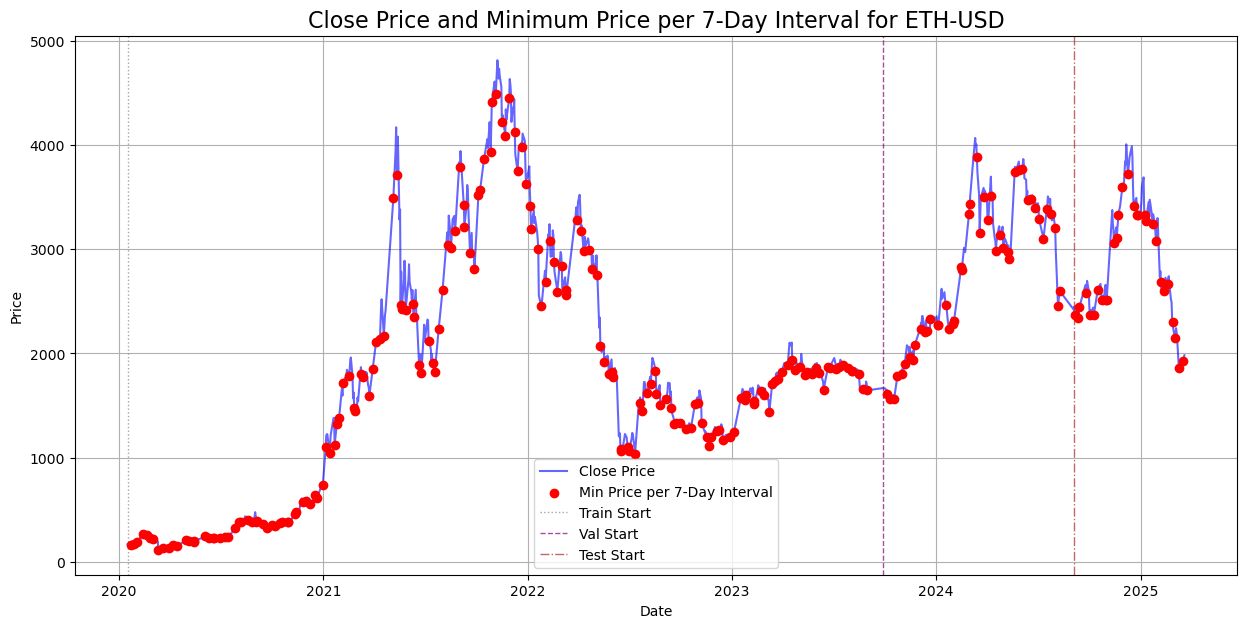


--- EDA Finished ---


In [335]:
import pandas as pd
import numpy as np # Make sure numpy is imported
import matplotlib.pyplot as plt

DATE_COL = 'dates' 

def plot_price_with_interval_minimums(df_dict, symbol, date_col=DATE_COL, price_col='close', interval_days=FUTURE_MIN_WINDOW_DAYS):
    """
    Plots the closing price over time and marks the minimum price within each
    discrete date interval (e.g., 30 days) for a given symbol.
    """
    if symbol not in df_dict or 'train' not in df_dict[symbol]:
        print(f"No processed training data for EDA for symbol {symbol}")
        return

    # Concatenate dataframes for plotting purposes, keeping track of original splits
    all_data_list = []
    split_markers = {}
    current_index = 0

    for split_name in ['train', 'val', 'test']:
        df_split = df_dict[symbol].get(split_name, pd.DataFrame()).copy()
        if not df_split.empty:
            df_split[date_col] = pd.to_datetime(df_split[date_col])
            df_split.sort_values(by=date_col, inplace=True)
            all_data_list.append(df_split)
            split_markers[split_name] = (current_index, current_index + len(df_split))
            current_index += len(df_split)

    if not all_data_list:
        print(f"No data available for symbol {symbol} across any split.")
        return

    all_data = pd.concat(all_data_list, ignore_index=True)

    if all_data.empty or date_col not in all_data.columns or price_col not in all_data.columns:
         print(f"Combined data for {symbol} is empty or missing essential columns ({date_col}, {price_col}).")
         return

    # Calculate the start date for the first interval
    start_date = all_data[date_col].min()

    # Create interval groups
    # We'll group by integer division of the days difference from the start date
    all_data['day_diff'] = (all_data[date_col] - start_date).dt.days
    all_data['interval_group'] = all_data['day_diff'] // interval_days

    # Find the minimum price and its corresponding date within each interval group
    interval_minimums = all_data.loc[all_data.groupby('interval_group')[price_col].idxmin()]

    plt.figure(figsize=(15, 7))

    # Plot the full closing price line
    plt.plot(all_data[date_col], all_data[price_col], label='Close Price', color='blue', linestyle='-', alpha=0.6)

    # Plot the interval minimum points
    if not interval_minimums.empty:
        plt.scatter(interval_minimums[date_col], interval_minimums[price_col], color='red', zorder=5, label=f'Min Price per {interval_days}-Day Interval')

    # Optional: Add vertical lines to mark the start/end of train/val/test splits
    split_colors = {'train': 'grey', 'val': 'purple', 'test': 'brown'}
    split_styles = {'train': ':', 'val': '--', 'test': '-.'}

    for split_name, (start_idx, end_idx) in split_markers.items():
         if start_idx < len(all_data): # Ensure index is within bounds
            split_start_date = all_data.iloc[start_idx][date_col]
            plt.axvline(split_start_date, color=split_colors[split_name], linestyle=split_styles[split_name], linewidth=1, alpha=0.7, label=f'{split_name.capitalize()} Start')
         # Only mark the end of train and val, test ends at the end of the data
         if split_name in ['train', 'val'] and end_idx > 0 and end_idx <= len(all_data):
              split_end_date = all_data.iloc[end_idx - 1][date_col] # End of the *previous* interval's data point

    # Remove duplicate labels from legend
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())


    plt.title(f'Close Price and Minimum Price per {interval_days}-Day Interval for {symbol}', fontsize=16)
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.grid(True)
    plt.show()

# Modify the plotting call within the EDA loop to use the new function
print("\n--- Running Exploratory Data Analysis (EDA) ---")
for symbol_eda in symbols_to_process: # Use the filtered list, e.g., ['ETH-USD']
    if symbol_eda in all_symbols_processed_dfs_for_eda:
        print(f"\n--- EDA for {symbol_eda} ---")
        
        # Plot price and Interval Minimums over time (Using the new function)
        plot_price_with_interval_minimums(all_symbols_processed_dfs_for_eda, symbol_eda, date_col=DATE_COL, price_col=CLOSE_COL, interval_days=FUTURE_MIN_WINDOW_DAYS)

print("\n--- EDA Finished ---")


--- Running Exploratory Data Analysis (EDA) ---

--- EDA for ETH-USD ---


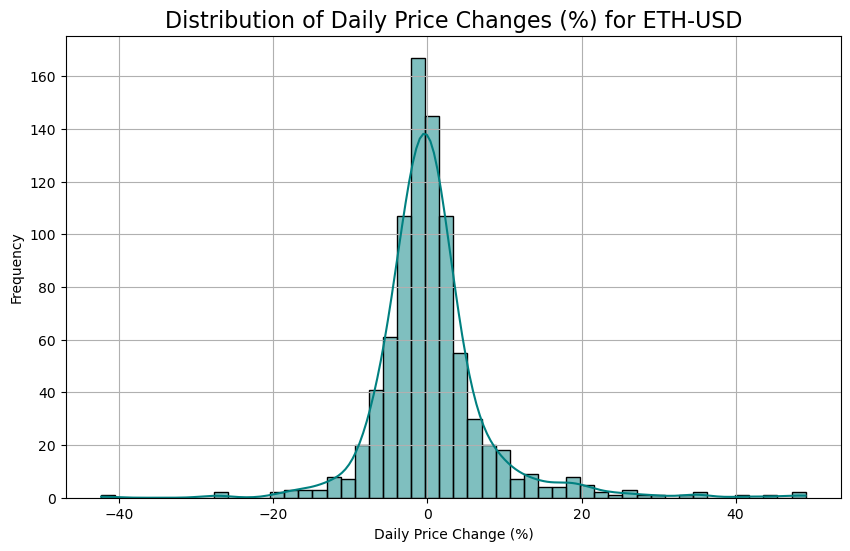


--- EDA Finished ---


In [336]:
import pandas as pd
import matplotlib.pyplot as plt
def plot_daily_pct_change_distribution(df_dict, symbol, price_col='close'):
    """
    Plots the distribution of daily percentage price changes for a given symbol.
    """
    if symbol not in df_dict or 'train' not in df_dict[symbol]:
        print(f"No processed training data for EDA for symbol {symbol}")
        return

    # Concatenate dataframes for plotting purposes
    all_data_list = []
    for split_name in ['train', 'val', 'test']:
        df_split = df_dict[symbol].get(split_name, pd.DataFrame()).copy()
        if not df_split.empty:
            all_data_list.append(df_split)

    if not all_data_list:
        print(f"No data available for symbol {symbol} across any split.")
        return

    all_data = pd.concat(all_data_list, ignore_index=True)

    if all_data.empty or price_col not in all_data.columns:
         print(f"Combined data for {symbol} is empty or missing the price column ({price_col}).")
         return

    # Calculate daily percentage change
    all_data['daily_pct_change'] = all_data[price_col].pct_change() * 100

    # Drop the first row which will have NaN for percentage change
    daily_changes = all_data['daily_pct_change'].dropna()

    if daily_changes.empty:
        print(f"No valid daily percentage changes calculated for {symbol}.")
        return

    plt.figure(figsize=(10, 6))
    sns.histplot(daily_changes, kde=True, bins=50, color="teal") # Adjust bins as needed
    plt.title(f'Distribution of Daily Price Changes (%) for {symbol}', fontsize=16)
    plt.xlabel('Daily Price Change (%)')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

# Add this new plotting call within the EDA loop:
print("\n--- Running Exploratory Data Analysis (EDA) ---")
for symbol_eda in symbols_to_process:
    if symbol_eda in all_symbols_processed_dfs_for_eda:
        print(f"\n--- EDA for {symbol_eda} ---")

        # Plot the distribution of daily price changes in %
        plot_daily_pct_change_distribution(all_symbols_processed_dfs_for_eda, symbol_eda, price_col=CLOSE_COL)

print("\n--- EDA Finished ---")



--- Running Exploratory Data Analysis (EDA) ---

--- EDA for ETH-USD ---
  ETH-USD: Daily % Change value at 40th percentile: -1.12%


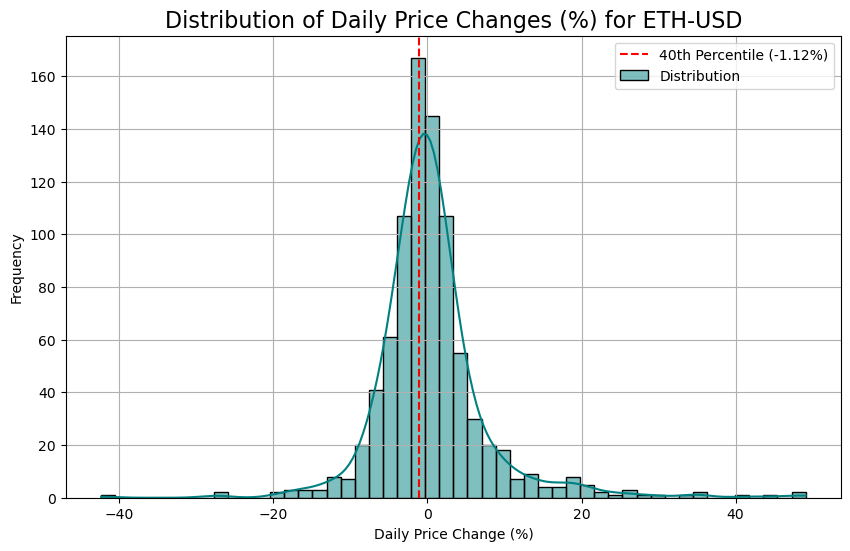


--- EDA Finished ---


In [337]:
def plot_daily_pct_change_distribution(df_dict, symbol, price_col='close', percentile_threshold=None):
    """
    Plots the distribution of daily percentage price changes for a given symbol.
    Optionally highlights bars below a specified percentile threshold and adds a line at that value.
    """
    if symbol not in df_dict or 'train' not in df_dict[symbol]:
        print(f"No processed training data for EDA for symbol {symbol}")
        return

    # Concatenate dataframes for plotting purposes
    all_data_list = []
    for split_name in ['train', 'val', 'test']:
        df_split = df_dict[symbol].get(split_name, pd.DataFrame()).copy()
        if not df_split.empty:
            all_data_list.append(df_split)

    if not all_data_list:
        print(f"No data available for symbol {symbol} across any split.")
        return

    all_data = pd.concat(all_data_list, ignore_index=True)

    if all_data.empty or price_col not in all_data.columns:
         print(f"Combined data for {symbol} is empty or missing the price column ({price_col}).")
         return

    # Calculate daily percentage change
    all_data['daily_pct_change'] = all_data[price_col].pct_change() * 100

    # Drop the first row which will have NaN for percentage change
    daily_changes = all_data['daily_pct_change'].dropna()

    if daily_changes.empty:
        print(f"No valid daily percentage changes calculated for {symbol}.")
        return

    plt.figure(figsize=(10, 6))

    # Plot the main histogram
    hist_plot = sns.histplot(daily_changes, kde=True, bins=50, color="teal", label='Distribution')

    threshold_value = None
    # Calculate and highlight based on percentile threshold
    if percentile_threshold is not None and 0 <= percentile_threshold <= 100:
        try:
            # Calculate the value at the specified percentile
            threshold_value = np.percentile(daily_changes, percentile_threshold)
            print(f"  {symbol}: Daily % Change value at {percentile_threshold}th percentile: {threshold_value:.2f}%")

            # Adding the vertical line at the percentile value
            plt.axvline(threshold_value, color='red', linestyle='--', label=f'{percentile_threshold}th Percentile ({threshold_value:.2f}%)')

            # Get histogram data
            counts, bin_edges = np.histogram(daily_changes, bins=50) # Use the same binning
            bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2


            # Find bins below the threshold value
            bins_below_threshold_indices = bin_centers <= threshold_value

            # Plot bars below the threshold with a different color
            # Ensure this plotting doesn't interfere with the KDE line if desired
            plt.bar(bin_centers[bins_below_threshold_indices], counts[bins_below_threshold_indices],
                    width=(bin_edges[1] - bin_edges[0]), color='orange', alpha=0.7, label=f'Below {percentile_threshold}th Percentile') # Example color

            plt.clf() # Clear the figure to re-plot cleanly
            sns.histplot(daily_changes, kde=True, bins=50, color="teal", label='Distribution')
            plt.axvline(threshold_value, color='red', linestyle='--', label=f'{percentile_threshold}th Percentile ({threshold_value:.2f}%)')
            plt.title(f'Distribution of Daily Price Changes (%) for {symbol}', fontsize=16)
            plt.xlabel('Daily Price Change (%)')
            plt.ylabel('Frequency')
            plt.grid(True)
            plt.legend() # Add legend to show the threshold line label

        except Exception as e:
            warnings.warn(f"Could not calculate or plot percentile threshold for {symbol}: {e}")

    plt.title(f'Distribution of Daily Price Changes (%) for {symbol}', fontsize=16)
    plt.xlabel('Daily Price Change (%)')
    plt.ylabel('Frequency')
    plt.grid(True)
    if threshold_value is not None:
        plt.legend() # Only show legend if threshold was plotted
    plt.show()


print("\n--- Running Exploratory Data Analysis (EDA) ---")

for symbol_eda in symbols_to_process:
    if symbol_eda in all_symbols_processed_dfs_for_eda:
        print(f"\n--- EDA for {symbol_eda} ---")

        # Plot the distribution of daily price changes in % with percentile threshold
        # Pass the global BINARY_TARGET_PERCENTILE as the percentile_threshold
        plot_daily_pct_change_distribution(
            all_symbols_processed_dfs_for_eda,
            symbol_eda,
            price_col=CLOSE_COL,
            percentile_threshold = BINARY_TARGET_PERCENTILE # Pass the desired percentile
        )
print("\n--- EDA Finished ---")


--- Running Exploratory Data Analysis (EDA) ---

--- EDA for ETH-USD ---


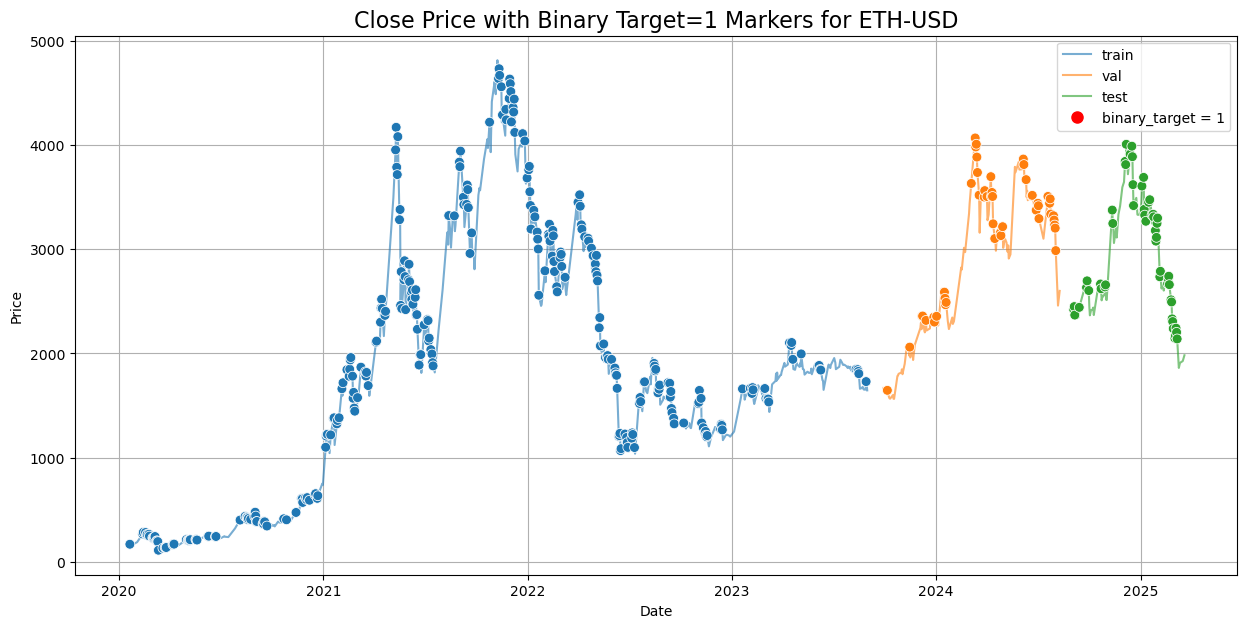


--- EDA Finished ---


In [338]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns # Ensure seaborn is imported
import numpy as np # Ensure numpy is imported

# Assuming DATE_COL, CLOSE_COL, BINARY_TARGET_PERCENTILE are defined globally
# If not, you might need to ensure they are accessible or defined within the cell.

def plot_price_with_binary_target(df_dict, symbol, date_col, price_col, target_col):
    """
    Plots the closing price over time and marks dates where the binary target is 1
    for a given symbol across train, validation, and test sets.
    """
    if symbol not in df_dict or 'train' not in df_dict[symbol]:
        print(f"No processed training data for EDA for symbol {symbol}")
        return

    plt.figure(figsize=(15, 7))

    all_data_list = []
    for split_name in ['train', 'val', 'test']:
        df_split = df_dict[symbol].get(split_name, pd.DataFrame()).copy()
        if not df_split.empty and date_col in df_split.columns and price_col in df_split.columns and target_col in df_split.columns:
            df_split[date_col] = pd.to_datetime(df_split[date_col])
            df_split.sort_values(by=date_col, inplace=True)
            # Add a column to identify the split for plotting legend
            df_split['split'] = split_name
            all_data_list.append(df_split)
        elif not df_split.empty:
            warnings.warn(f"Missing required columns ({date_col}, {price_col}, {target_col}) in {split_name} split for {symbol}. Skipping plot for this split.")


    if not all_data_list:
        print(f"No data available with required columns for symbol {symbol} across any split.")
        return

    all_data = pd.concat(all_data_list, ignore_index=True)

    if all_data.empty:
         print(f"Combined data for {symbol} is empty.")
         return

    # Plot the full closing price line, colored by split
    # REMOVED label='Close Price (Split)' - seaborn handles this with hue
    sns.lineplot(data=all_data, x=date_col, y=price_col, hue='split', linestyle='-', alpha=0.6)


    # Filter for dates where binary target is 1
    target_dates = all_data[all_data[target_col] == 1].copy()

    # Plot points where the binary target is 1, colored by split
    if not target_dates.empty:
        # Using scatterplot with hue for consistent coloring with lineplot
        sns.scatterplot(data=target_dates, x=date_col, y=price_col, hue='split',
                        marker='o', s=50, zorder=5, legend=False) # legend=False to avoid duplicate split legends

        # Add a separate legend entry for the 'Target = 1' points manually
        # This dummy plot creates a handle for the legend entry
        plt.plot([], [], 'o', color='red', markersize=8, label=f'{target_col} = 1')


    plt.title(f'Close Price with Binary Target=1 Markers for {symbol}', fontsize=16)
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend() # Show the combined legend
    plt.grid(True)
    plt.show()

# Add this new plotting call within the EDA loop:
print("\n--- Running Exploratory Data Analysis (EDA) ---")
for symbol_eda in symbols_to_process: # This is ['ETH-USD'] based on your preceding code
    if symbol_eda in all_symbols_processed_dfs_for_eda:
        print(f"\n--- EDA for {symbol_eda} ---")

        # ... (other EDA plots if needed) ...

        # Plot the closing price with markers for binary_target = 1
        plot_price_with_binary_target(
            all_symbols_processed_dfs_for_eda,
            symbol_eda,
            date_col=DATE_COL,
            price_col=CLOSE_COL,
            target_col='binary_target'
        )

        # ... (other EDA plots if needed) ...

print("\n--- EDA Finished ---")

In [360]:
target_symbol = 'ETH-USD'
processed_data_dict = all_symbols_processed_dfs_for_eda.get(target_symbol)

if processed_data_dict:
    all_processed_data_list = []
    # Concatenate train, val, and test sets for the target symbol
    for split_name in ['train', 'val', 'test']:
        df_split = processed_data_dict.get(split_name, pd.DataFrame()).copy()
        if not df_split.empty:
            # Ensure the required columns are present before adding to the list
            required_cols = [DATE_COL] + TARGET_COLS_FINAL
            if all(col in df_split.columns for col in required_cols):
                all_processed_data_list.append(df_split[required_cols])
            else:
                 warnings.warn(f"Missing required target/date columns in {split_name} split for {target_symbol}. Skipping concatenation for this split.")

    if all_processed_data_list:
        # Concatenate all splits
        target_df = pd.concat(all_processed_data_list, ignore_index=True)
        print("DataFrame with date and target variables created successfully.")
        print(target_df.head()) # Display first few rows
    else:
        print(f"No processed data with required target/date columns available for {target_symbol}.")
        target_df = pd.DataFrame(columns=[DATE_COL] + TARGET_COLS_FINAL) # Create an empty DataFrame
else:
    print(f"No processed data found for symbol {target_symbol} in all_symbols_processed_dfs_for_eda.")
    target_df = pd.DataFrame(columns=[DATE_COL] + TARGET_COLS_FINAL) # Create an empty DataFrame

DataFrame with date and target variables created successfully.
       dates  binary_target  days_to_future_min_7d
0 2020-03-02              1                    6.0
1 2020-03-03              1                    6.0
2 2020-03-04              1                    5.0
3 2020-03-05              1                    6.0
4 2020-03-06              1                    6.0


In [226]:
target_df

dates  binary_target  days_to_future_min_7d
0   2020-03-02              1                    6.0
1   2020-03-03              1                    6.0
2   2020-03-04              1                    5.0
3   2020-03-05              1                    6.0
4   2020-03-06              1                    6.0
..         ...            ...                    ...
806 2025-03-07              1                    4.0
807 2025-03-10              0                    1.0
808 2025-03-12              0                    1.0
809 2025-03-17              0                    1.0
810 2025-03-20              0                    1.0

[811 rows x 3 columns]

# Building Deep Learning Models

## Generating Time Step Sequences

In [361]:
def create_sequences(X_df, y_df, time_steps=10):
    """
    Create sequences of features and targets for time series modeling.
    Returns X (3D), y_binary (1D), and y_regression (1D).
    Skips if the number of rows is less than or equal to the time step length.
    """
    Xs, y_bin, y_reg = [], [], []

    if X_df.shape[0] <= time_steps:
        return np.array(Xs), np.array(y_bin), np.array(y_reg)

    for i in range(len(X_df) - time_steps):
        Xs.append(X_df.iloc[i:(i + time_steps)].values)
        y_bin.append(y_df['binary_target'].iloc[i + time_steps])
        y_reg.append(y_df[DAYS_TO_MIN_COL].iloc[i + time_steps])

    return (
        np.array(Xs),
        np.array(y_bin).astype(float),
        np.array(y_reg).astype(float)
    )

## Buliding LSTM

In [363]:
def build_lstm_model(input_shape):
    """
    Build a dual-output LSTM model for binary classification and regression.
    Returns a compiled Keras model with two outputs:
    - 'binary_output' with sigmoid activation
    - 'regression_output' with linear activation
    """

    inp = Input(shape=input_shape)
    x = layers.LSTM(256, return_sequences=True)(inp)
    x = layers.Dropout(0.3)(x)
    x = layers.LSTM(128, return_sequences=True)(x)
    x = layers.Dropout(0.3)(x)
    x = layers.LSTM(64)(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(32, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    out_bin = layers.Dense(1, activation='sigmoid', name='binary_output')(x)
    out_reg = layers.Dense(1, activation='linear', name='regression_output')(x)
    return Model(inputs=inp, outputs=[out_bin, out_reg])

## Building GRU

In [362]:
def build_gru_model(input_shape):
    """
    Build a dual-output GRU model for binary classification and regression.
    Returns a Keras model with:
    - 'binary_output': sigmoid-activated layer for binary target
    - 'regression_output': linear-activated layer for regression target
    """
    inp = Input(shape=input_shape)
    x = layers.GRU(256, return_sequences=True)(inp)
    x = layers.Dropout(0.3)(x)
    x = layers.GRU(128, return_sequences=True)(x)
    x = layers.Dropout(0.3)(x)
    x = layers.GRU(64)(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(32, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    out_bin = layers.Dense(1, activation='sigmoid', name='binary_output')(x)
    out_reg = layers.Dense(1, activation='linear', name='regression_output')(x)
    return Model(inputs=inp, outputs=[out_bin, out_reg])

## Building Hybrid of LSTM & GRU

In [364]:
def build_hybrid_lstm_gru_model(input_shape):
    """
    Build a dual-output hybrid model combining LSTM and GRU layers in parallel.
    The model outputs:
    - 'binary_output' for classification (sigmoid)
    - 'regression_output' for regression (linear)
    """
    inp = Input(shape=input_shape)

    x_lstm = layers.LSTM(128 , return_sequences=True)(inp)
    x_lstm = layers.Dropout(0.3)(x_lstm)
    x_lstm = layers.LSTM(64)(x_lstm)
    x_lstm = layers.Dropout(0.3)(x_lstm)

    x_gru = layers.GRU(128, return_sequences=True)(inp)
    x_gru = layers.Dropout(0.3)(x_gru)
    x_gru = layers.GRU(64)(x_gru)
    x_gru = layers.Dropout(0.3)(x_gru)

    x = layers.Concatenate()([x_lstm, x_gru])
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.3)(x)

    out_bin = layers.Dense(1, activation='sigmoid', name='binary_output')(x)
    out_reg = layers.Dense(1, activation='linear', name='regression_output')(x)

    return Model(inputs=inp, outputs=[out_bin, out_reg])

## Model With "Multi-Head Self-Attention (Transformer Style)

In [365]:
def transformer_encoder(inputs, head_size=64, num_heads=2, ff_dim=64, dropout=0.3):
    """
    Transformer encoder block with multi-head self-attention and feed-forward layers.
    Includes residual connections and layer normalization.
    """
    x = layers.MultiHeadAttention(num_heads=num_heads, key_dim=head_size)(inputs, inputs)
    x = layers.Dropout(dropout)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x + inputs)

    x_ff = layers.Dense(ff_dim, activation="relu")(x)
    x_ff = layers.Dropout(dropout)(x_ff)
    x_ff = layers.Dense(inputs.shape[-1])(x_ff)
    return layers.LayerNormalization(epsilon=1e-6)(x_ff + x)


def asymmetric_loss(y_true, y_pred, under_penalty=2.0, over_penalty=0.5):
    """
    Custom asymmetric loss for regression.
    Penalizes under-predictions more than over-predictions using weighted squared error.
    """
    error = y_true - y_pred
    loss = tf.where(
        error < 0,
        over_penalty * tf.square(error),   # Less penalty for over-prediction
        under_penalty * tf.square(error)   # Higher penalty for under-prediction
    )
    return tf.reduce_mean(loss)


def focal_loss(y_true, y_pred, alpha=0.25, gamma=2.0):
    """
    Focal loss for binary classification with class imbalance.
    Down-weights easy examples and focuses learning on hard ones.
    """
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred, from_logits=False)
    pt = tf.exp(-bce)
    loss = alpha * tf.pow(1 - pt, gamma) * bce
    return tf.reduce_mean(loss)


In [366]:
def build_hybrid_attention_model(input_shape):
    """
    Build a hybrid LSTM-GRU model with Multi-Head Self-Attention for dual-output prediction.

    Architecture:
    - Parallel LSTM and GRU branches with decreasing depth
    - Concatenated sequence passed through transformer encoder (multi-head attention)
    - Global context extracted via pooling and dense layers
    - Two outputs:
        * 'binary_output': sigmoid-activated classifier
        * 'regression_output': linear-activated regressor
    """
    inp = Input(shape=input_shape)

    # --- LSTM Branch ---
    x_lstm = layers.LSTM(128, return_sequences=True)(inp)
    x_lstm = layers.Dropout(0.3)(x_lstm)
    x_lstm = layers.LSTM(64, return_sequences=True)(x_lstm)
    x_lstm = layers.Dropout(0.3)(x_lstm)
    x_lstm = layers.LSTM(32, return_sequences=True)(x_lstm)

    # --- GRU Branch ---
    x_gru = layers.GRU(128, return_sequences=True)(inp)
    x_gru = layers.Dropout(0.3)(x_gru)
    x_gru = layers.GRU(64, return_sequences=True)(x_gru)
    x_gru = layers.Dropout(0.3)(x_gru)
    x_gru = layers.GRU(32, return_sequences=True)(x_gru)

    # --- Multi-Head Self-Attention ---
    x_combined = layers.Concatenate(axis=-1)([x_lstm, x_gru])
    x_attention = transformer_encoder(x_combined, head_size=32, num_heads=2)

    # --- Context Extraction ---
    x_global = layers.GlobalAveragePooling1D()(x_attention)
    x_global = layers.Dense(32, activation='relu')(x_global)
    x_global = layers.Dropout(0.3)(x_global)

    # --- Outputs ---
    out_bin = layers.Dense(1, activation='sigmoid', name='binary_output')(x_global)
    out_reg = layers.Dense(1, activation='linear', name='regression_output')(x_global)

    return Model(inputs=inp, outputs=[out_bin, out_reg])

# Constructing TSM and Super-hybrid Models

### Building and Testing TCN MODEL

In [367]:
def build_tcn_model(input_shape):
    """
    Build a Temporal Convolutional Network (TCN) model with dual outputs:
    - 'binary_output': for binary classification (sigmoid activation)
    - 'regression_output': for continuous prediction (linear activation)

    The model uses causal convolutions with dilated stacks, layer normalization,
    and a series of dense layers for feature compression.
    """
    inp = Input(shape=input_shape)

    # TCN block
    tcn_out = TCN(
        nb_filters=256,
        kernel_size=2,
        nb_stacks=1,
        dilations=[1, 2, 4, 8, 16],
        padding='causal',
        use_skip_connections=True,
        dropout_rate=0.1,
        return_sequences=False,
        activation='relu',
        use_batch_norm=False,
        use_layer_norm=True
    )(inp)

    # Dense compression block
    x = Dense(512, activation='relu')(tcn_out)
    x = Dropout(0.3)(x)

    x = Dense(256, activation='relu')(x)
    x = Dropout(0.3)(x)

    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)

    x = Dense(64, activation='relu')(x)
    x = Dropout(0.3)(x)

    x = Dense(32, activation='relu')(x)
    x = Dropout(0.3)(x)
    # Output layers
    binary_output = Dense(1, activation='sigmoid', name='binary_output')(x)
    regression_output = Dense(1, activation='linear', name='regression_output')(x)

    model = Model(inputs=inp, outputs=[binary_output, regression_output])
    return model


### Super Hybrid Model Build

In [368]:
def build_hybrid_tcn_lstm_gru_model(input_shape):
    """
    Build a hybrid model that combines TCN, LSTM, and GRU branches in parallel.
    Each branch processes the input independently and their outputs are concatenated.
    Final dense layers produce two outputs:
    - 'binary_output': sigmoid-activated binary classifier
    - 'regression_output': linear regressor
    """
    inp = Input(shape=input_shape)

    # --- LSTM Branch ---
    lstm_out = LSTM(128, return_sequences=False, dropout=0.3, recurrent_dropout=0.3)(inp)
    lstm_out = Dropout(0.3)(lstm_out)
    lstm_out = Dense(64, activation='relu')(lstm_out)
    lstm_out = Dropout(0.3)(lstm_out)
    lstm_out = Dense(32, activation='relu')(lstm_out)

    # --- GRU Branch ---
    gru_out = GRU(128, return_sequences=False, dropout=0.3, recurrent_dropout=0.3)(inp)
    gru_out = Dropout(0.3)(gru_out)
    gru_out = Dense(64, activation='relu')(gru_out)
    gru_out = Dropout(0.3)(gru_out)
    gru_out = Dense(32, activation='relu')(gru_out)

    # --- TCN Branch ---
    tcn_out = TCN(
        nb_filters=256,
        kernel_size=2,
        nb_stacks=1,
        dilations=[1, 2, 4, 8, 16],
        padding='causal',
        use_skip_connections=True,
        dropout_rate=0.3,
        return_sequences=False,
        activation='relu',
        use_batch_norm=False,
        use_layer_norm=True
    )(inp)
    tcn_out = Dropout(0.3)(tcn_out)
    tcn_out = Dense(128, activation='relu')(tcn_out)
    tcn_out = Dropout(0.3)(tcn_out)
    tcn_out = Dense(32, activation='relu')(tcn_out)

    # --- Concatenate ---
    combined_output = Concatenate()([lstm_out, gru_out, tcn_out])

    # --- Top Dense Layers ---
    x = Dense(256, activation='relu')(combined_output)
    x = Dropout(0.3)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.3)(x)

    # --- Outputs ---
    binary_output = Dense(1, activation='sigmoid', name='binary_output')(x)
    regression_output = Dense(1, activation='linear', name='regression_output')(x)

    return Model(inputs=inp, outputs=[binary_output, regression_output])

# Plotting and Evaluating Deep Learning Models

In [369]:
def plot_and_evaluate(model, history, X_val_data, y_val_binary_true, y_val_regr_true, experiment_name="Experiment"):
    """
    Evaluate a dual-output model on validation data, print metrics and classification report,
    and plot training history, prediction outputs, and performance diagnostics.

    Parameters:
        model            : Trained Keras model
        history          : History object from model.fit
        X_val_data       : Validation input features
        y_val_binary_true: Ground truth binary labels
        y_val_regr_true  : Ground truth regression targets
        experiment_name  : Optional label for titles and printouts

    Returns:
        dict with accuracy, MAE, and classification report
    """
    if X_val_data.size == 0 or y_val_binary_true.size == 0:
        print(f"\n📊 {experiment_name} - No validation data to evaluate (X_val_data empty: {X_val_data.size == 0}, y_val_binary_true empty: {y_val_binary_true.size == 0}).")
        return {"accuracy": np.nan, "mae_days": np.nan, "report": "No validation data."}

    y_val_binary_true = np.array(y_val_binary_true).flatten()
    y_val_regr_true = np.array(y_val_regr_true).flatten()

    binary_preds_proba, regression_preds = model.predict(X_val_data, verbose=0)
    binary_preds_final = (binary_preds_proba.flatten() > 0.5).astype(int)
    regression_preds_flat = regression_preds.flatten()

    total_val_samples = len(y_val_binary_true)
    positive_val_samples = np.sum(y_val_binary_true)

    print(f"\n📊 {experiment_name} - Validation Statistics:")
    if total_val_samples > 0:
        print(f"  Total validation samples: {total_val_samples}")
        print(f"  Positive binary targets (actual): {positive_val_samples} ({positive_val_samples/total_val_samples:.2%})")
        print(f"  Positive binary targets (predicted): {np.sum(binary_preds_final)} ({np.sum(binary_preds_final)/total_val_samples:.2%})")
    else:
        print("  Total validation samples: 0")

    acc = accuracy_score(y_val_binary_true, binary_preds_final) if total_val_samples > 0 else np.nan
    mae = mean_absolute_error(y_val_regr_true, regression_preds_flat) if total_val_samples > 0 else np.nan
    print(f"\n✅ Classification Accuracy: {acc:.4f}")
    print(f"📈 Regression MAE (days): {mae:.4f}")

    print("\n📋 Classification Report (Validation):")
    if total_val_samples > 0:
        print(classification_report(y_val_binary_true, binary_preds_final, zero_division=0, target_names=['Class 0 (No Drop)', 'Class 1 (Drop)']))
        report_dict = classification_report(y_val_binary_true, binary_preds_final, zero_division=0, output_dict=True)
    else:
        print("No samples for classification report.")
        report_dict = {}

    # --- Plot Training History ---
    fig, axs = plt.subplots(1, 3, figsize=(18, 5))
    if history and history.history:
        axs[0].plot(history.history.get('loss', []), label='Train Loss')
        axs[0].plot(history.history.get('val_loss', []), label='Val Loss')
        axs[0].set_title('Total Model Loss')
        axs[0].set_xlabel('Epochs'); axs[0].set_ylabel('Loss'); axs[0].legend(); axs[0].grid(True)

        axs[1].plot(history.history.get('binary_output_loss', []), label='Train Binary Loss')
        axs[1].plot(history.history.get('val_binary_output_loss', []), label='Val Binary Loss')
        if 'binary_output_accuracy' in history.history:
            axs[1].plot(history.history.get('binary_output_accuracy', []), label='Train Binary Acc', linestyle=':')
            axs[1].plot(history.history.get('val_binary_output_accuracy', []), label='Val Binary Acc', linestyle=':')
        axs[1].set_title('Binary Output Loss & Accuracy')
        axs[1].set_xlabel('Epochs'); axs[1].set_ylabel('Loss / Accuracy'); axs[1].legend(); axs[1].grid(True)

        axs[2].plot(history.history.get('regression_output_loss', []), label='Train Regr. Loss')
        axs[2].plot(history.history.get('val_regression_output_loss', []), label='Val Regr. Loss')
        if 'regression_output_mae' in history.history:
            axs[2].plot(history.history.get('regression_output_mae', []), label='Train Regr. MAE', linestyle=':')
            axs[2].plot(history.history.get('val_regression_output_mae', []), label='Val Regr. MAE', linestyle=':')
        axs[2].set_title('Regression Output Loss & MAE')
        axs[2].set_xlabel('Epochs'); axs[2].set_ylabel('Loss / MAE'); axs[2].legend(); axs[2].grid(True)

    plt.tight_layout(); plt.show()

    # --- Plot Binary Predictions ---
    if total_val_samples > 0:
        plt.figure(figsize=(12, 5))
        plt.plot(y_val_binary_true, label='True Binary Labels', alpha=0.7, drawstyle='steps-post')
        plt.plot(binary_preds_proba.flatten(), label='Predicted Probability', alpha=0.7)
        plt.title(f'{experiment_name} - Binary Classification Output (Validation)')
        plt.xlabel('Sample Index'); plt.ylabel('Probability / Class'); plt.legend(); plt.grid(True); plt.show()

        # --- Plot Regression Predictions ---
        plt.figure(figsize=(12, 5))
        sample_size_plot = min(len(y_val_regr_true), 500)
        indices_to_plot = np.random.choice(len(y_val_regr_true), sample_size_plot, replace=False) if len(y_val_regr_true) > sample_size_plot else np.arange(len(y_val_regr_true))
        plt.scatter(np.arange(len(indices_to_plot)), y_val_regr_true[indices_to_plot], label='True Days', alpha=0.6, s=30)
        plt.scatter(np.arange(len(indices_to_plot)), regression_preds_flat[indices_to_plot], label='Predicted Days', alpha=0.6, marker='x', s=30)
        plt.title(f'{experiment_name} - Regression Output (Days to Future Min - Validation)')
        plt.xlabel('Sample Index (subset)'); plt.ylabel('Days'); plt.legend(); plt.grid(True); plt.show()

    return {"accuracy": acc, "mae_days": mae, "report": report_dict}

# Training Deep Learning Model

##Constant Variables

In [370]:
EPOCHS = 2000
BATCH_SIZE = 8

PATIENCE_EARLY_STOPPING = 200

all_models_history = {}
all_models_evaluation = {}
all_trained_models = {}

## Starting Model Training Loop


--- Training models for ETH-USD ---

-- Training LSTM for ETH-USD --
Epoch 1/2000
74/74 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - binary_output_accuracy: 0.4705 - binary_output_loss: 0.7676 - binary_output_precision: 0.4465 - binary_output_recall: 0.2848 - loss: 1.4940 - regression_output_loss: 2.2205 - regression_output_mae: 2.2204 - val_binary_output_accuracy: 0.5841 - val_binary_output_loss: 0.6727 - val_binary_output_precision: 0.0000e+00 - val_binary_output_recall: 0.0000e+00 - val_loss: 1.2222 - val_regression_output_loss: 1.6691 - val_regression_output_mae: 1.7650 - learning_rate: 0.0010
Epoch 2/2000
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - binary_output_accuracy: 0.4948 - binary_output_loss: 0.7385 - binary_output_precision: 0.4545 - binary_output_recall: 0.3620 - loss: 1.2650 - regression_output_loss: 1.7915 - regression_output_mae: 1.7915 - val_binary_output_accuracy: 0.5841 - val_binary_output_loss: 0.6838 - val_binary_output_precision: 0.0000e+00 - val_binary_output_recall: 0.0

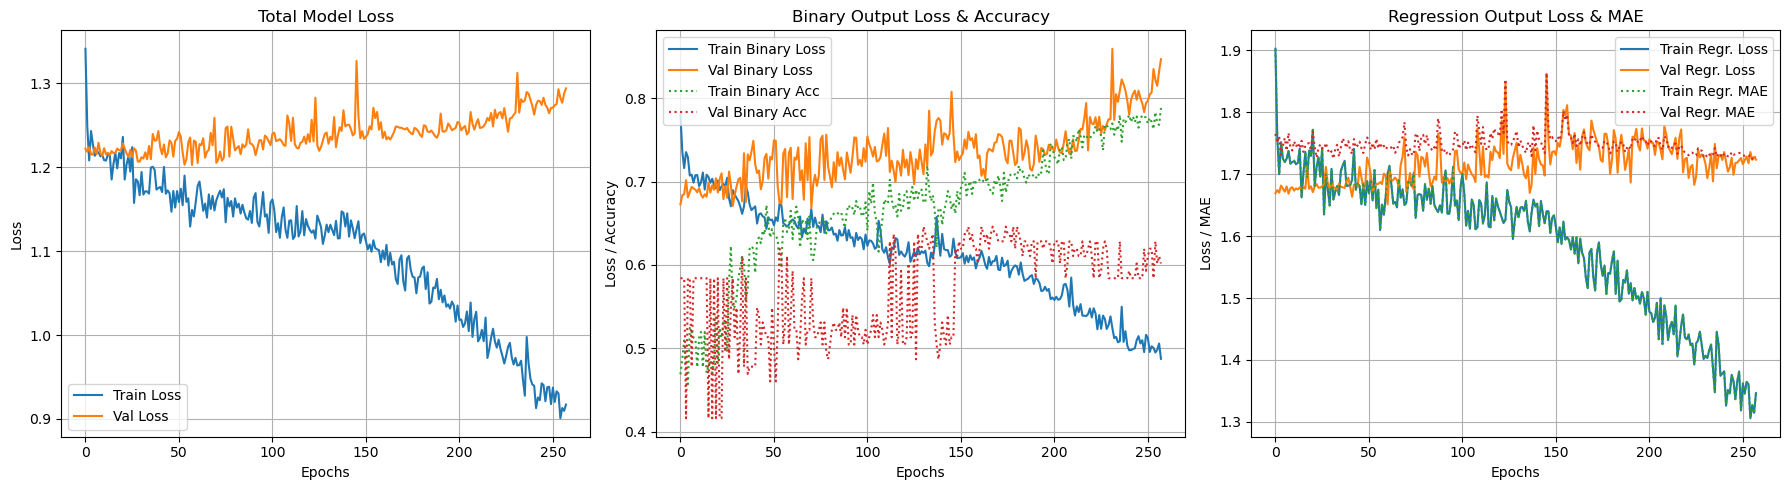

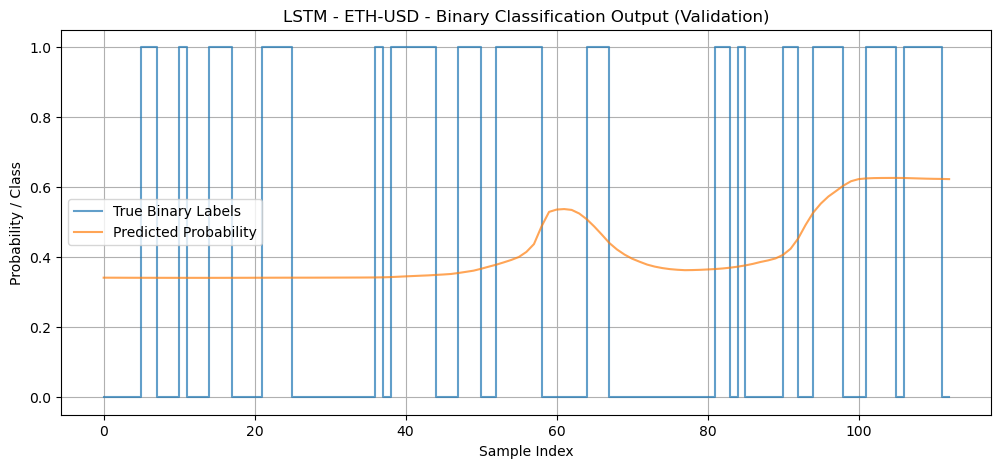

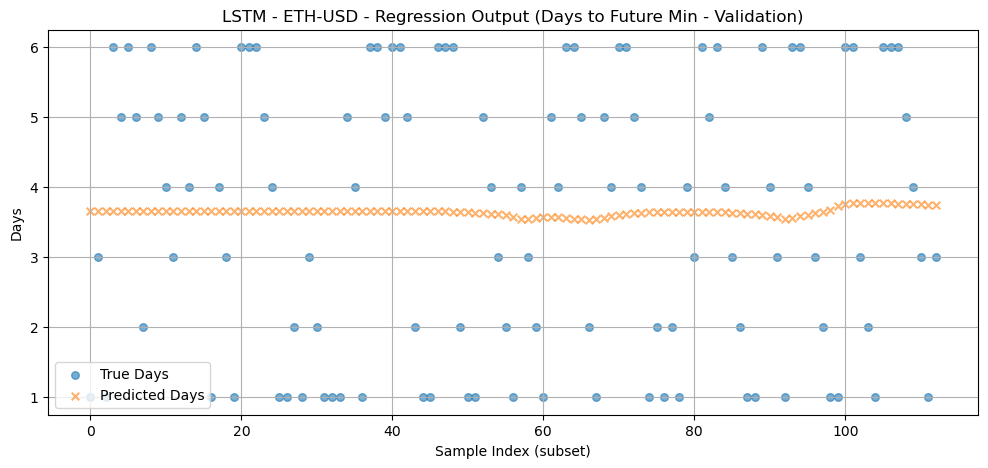


-- Training GRU for ETH-USD --
Epoch 1/2000
74/74 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - binary_output_accuracy: 0.5163 - binary_output_loss: 0.7719 - binary_output_precision: 0.5125 - binary_output_recall: 0.4965 - loss: 1.3433 - regression_output_loss: 1.9148 - regression_output_mae: 1.9148 - val_binary_output_accuracy: 0.5841 - val_binary_output_loss: 0.6706 - val_binary_output_precision: 0.0000e+00 - val_binary_output_recall: 0.0000e+00 - val_loss: 1.2208 - val_regression_output_loss: 1.6734 - val_regression_output_mae: 1.7647 - learning_rate: 0.0010
Epoch 2/2000
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - binary_output_accuracy: 0.5074 - binary_output_loss: 0.7577 - binary_output_precision: 0.4769 - binary_output_recall: 0.4022 - loss: 1.3058 - regression_output_loss: 1.8539 - regression_output_mae: 1.8539 - val_binary_output_accuracy: 0.4159 - val_binary_output_loss: 0.7184 - val_binary_output_precision: 0.4159 - val_binary_output_recall: 1.0000 - val_loss: 1.2314 - val_regression_ou

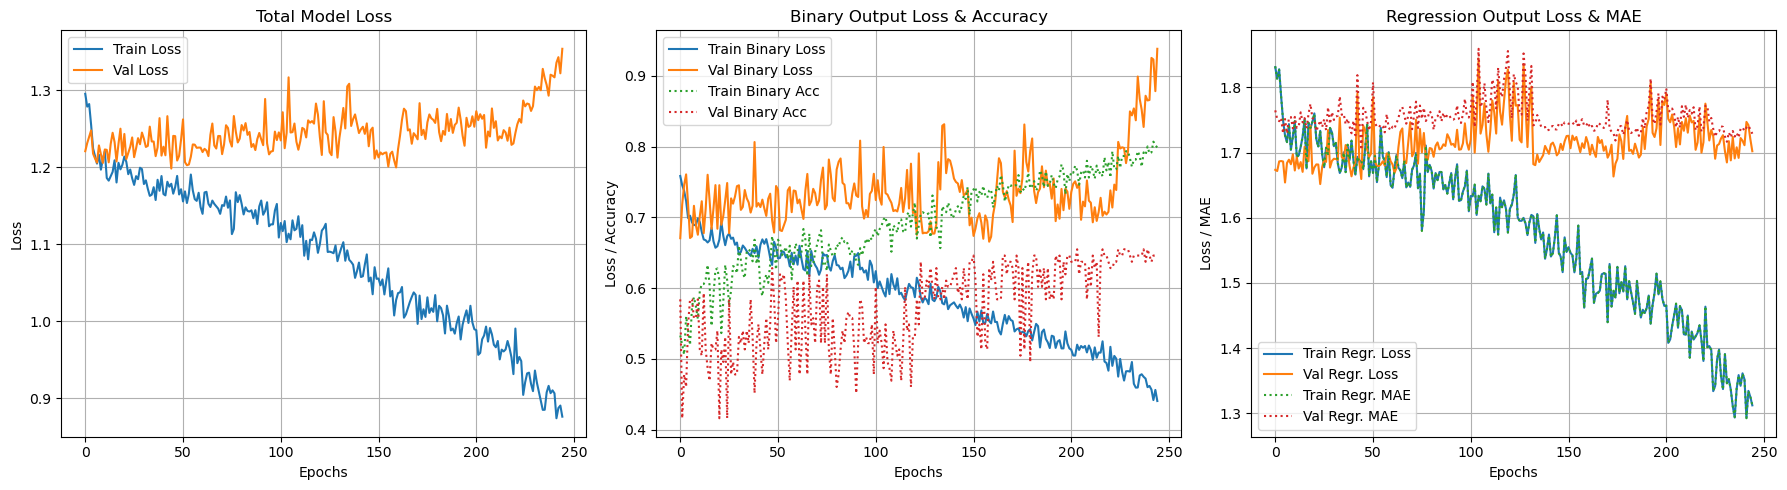

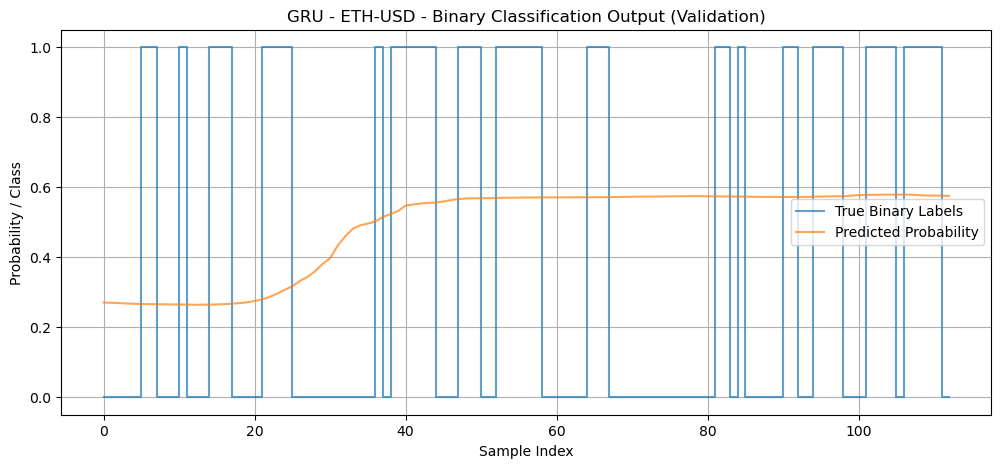

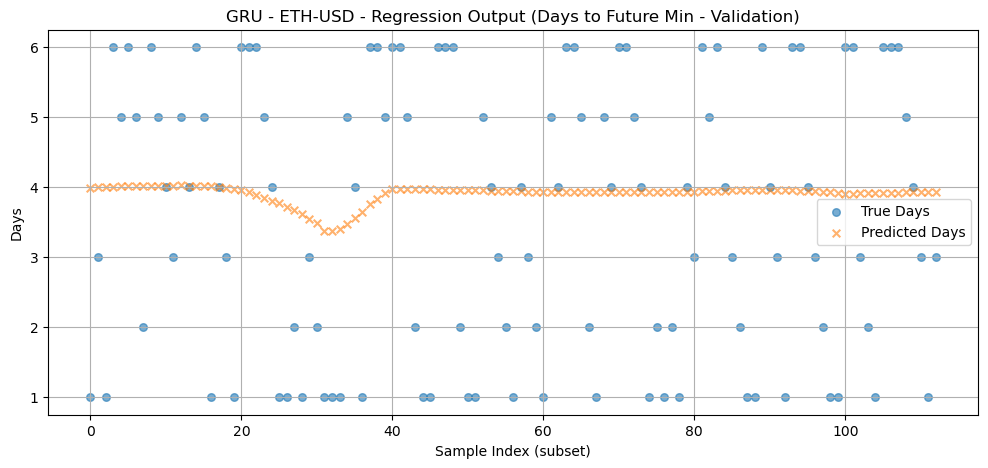


-- Training Hybrid_LSTM_GRU for ETH-USD --
Epoch 1/2000
74/74 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - binary_output_accuracy: 0.4618 - binary_output_loss: 0.7539 - binary_output_precision: 0.4373 - binary_output_recall: 0.3964 - loss: 1.4022 - regression_output_loss: 2.0504 - regression_output_mae: 2.0504 - val_binary_output_accuracy: 0.4513 - val_binary_output_loss: 0.7050 - val_binary_output_precision: 0.4312 - val_binary_output_recall: 1.0000 - val_loss: 1.2216 - val_regression_output_loss: 1.6773 - val_regression_output_mae: 1.7423 - learning_rate: 0.0010
Epoch 2/2000
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - binary_output_accuracy: 0.5296 - binary_output_loss: 0.7249 - binary_output_precision: 0.5059 - binary_output_recall: 0.4166 - loss: 1.2294 - regression_output_loss: 1.7338 - regression_output_mae: 1.7338 - val_binary_output_accuracy: 0.4159 - val_binary_output_loss: 0.7420 - val_binary_output_precision: 0.4159 - val_binary_output_recall: 1.0000 - val_loss: 1.2424 - val_regressio

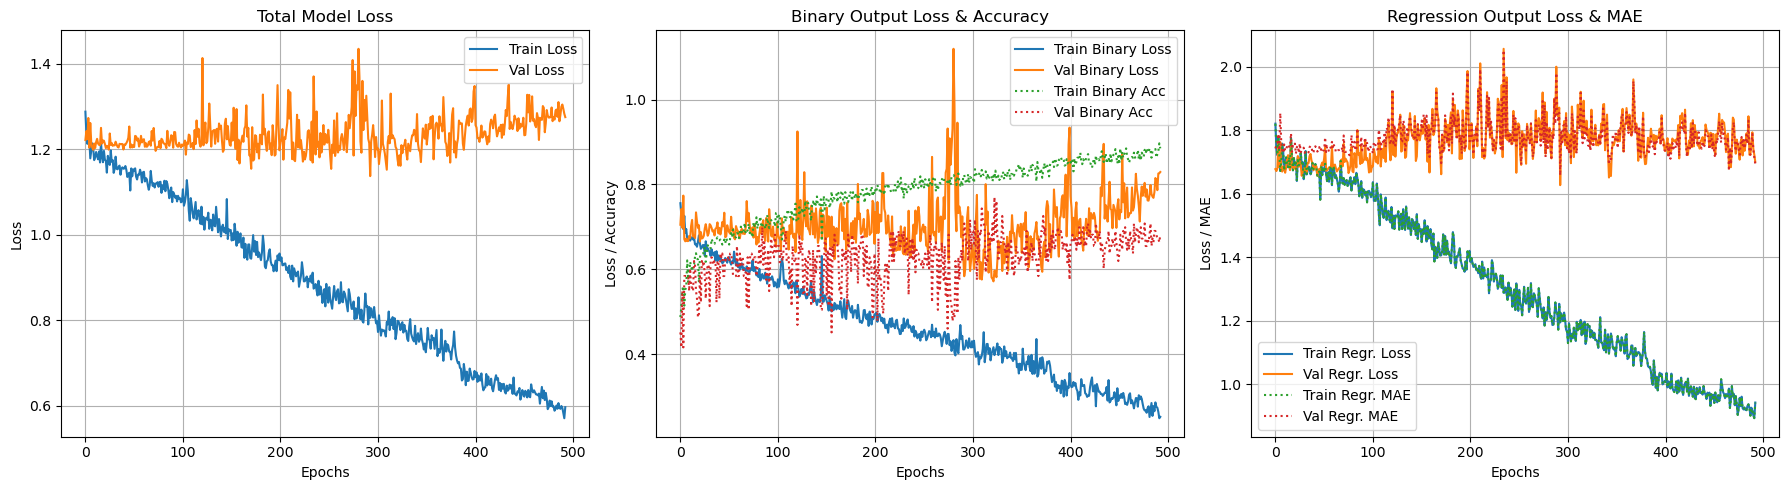

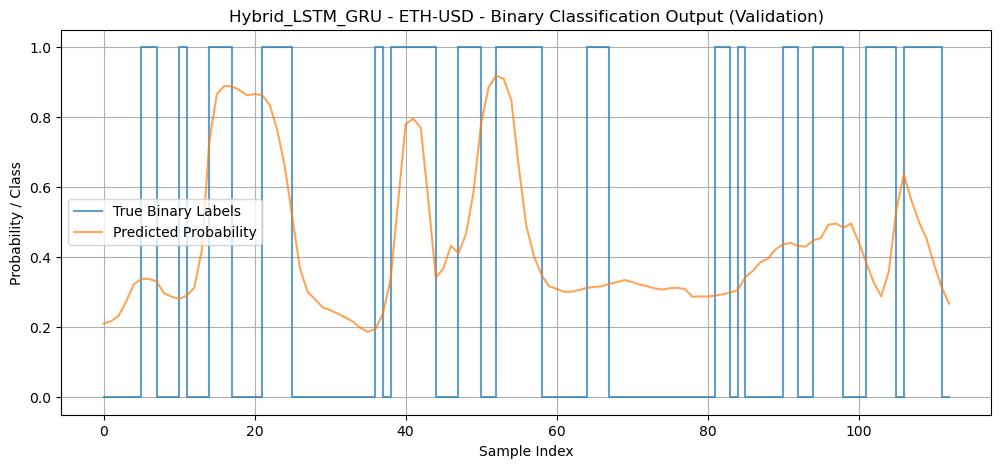

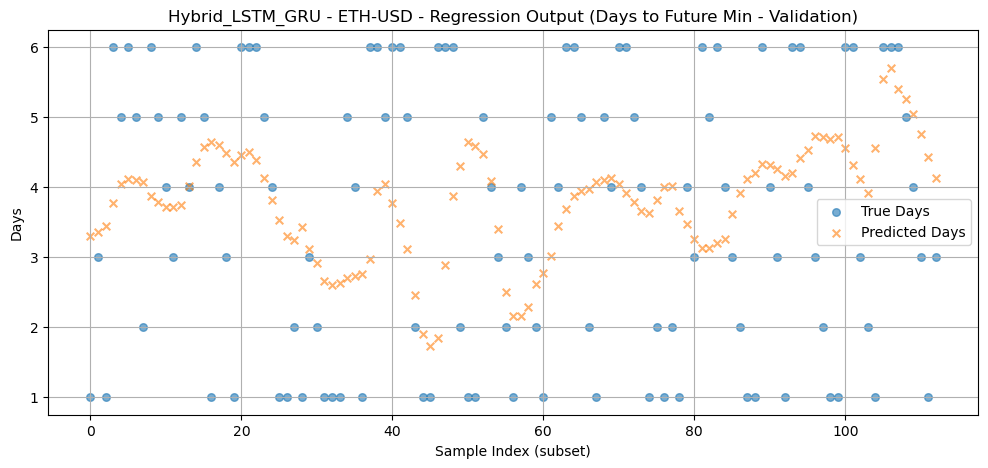


-- Training TCN for ETH-USD --
Epoch 1/2000
74/74 ━━━━━━━━━━━━━━━━━━━━ 14s 47ms/step - binary_output_accuracy: 0.5208 - binary_output_loss: 1.1300 - binary_output_precision: 0.5144 - binary_output_recall: 0.7177 - loss: 1.8544 - regression_output_loss: 2.5788 - regression_output_mae: 2.5788 - val_binary_output_accuracy: 0.4159 - val_binary_output_loss: 0.7091 - val_binary_output_precision: 0.4159 - val_binary_output_recall: 1.0000 - val_loss: 1.4101 - val_regression_output_loss: 2.0573 - val_regression_output_mae: 2.1143 - learning_rate: 0.0010
Epoch 2/2000
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - binary_output_accuracy: 0.4557 - binary_output_loss: 0.8612 - binary_output_precision: 0.4125 - binary_output_recall: 0.4764 - loss: 1.5244 - regression_output_loss: 2.1876 - regression_output_mae: 2.1876 - val_binary_output_accuracy: 0.5841 - val_binary_output_loss: 0.6717 - val_binary_output_precision: 0.0000e+00 - val_binary_output_recall: 0.0000e+00 - val_loss: 1.2884 - val_regression_o

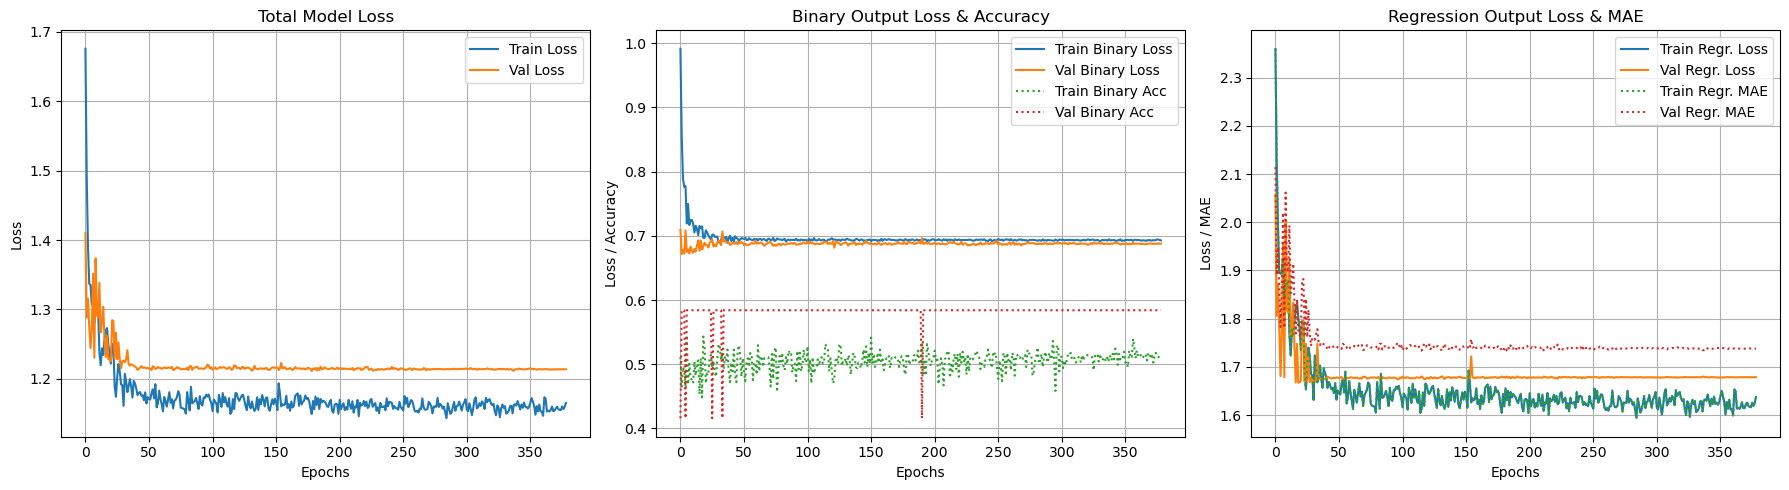

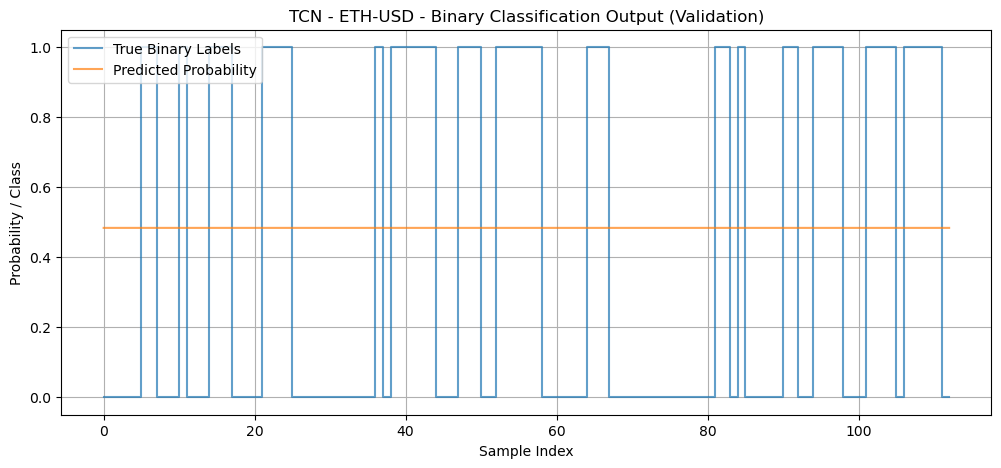

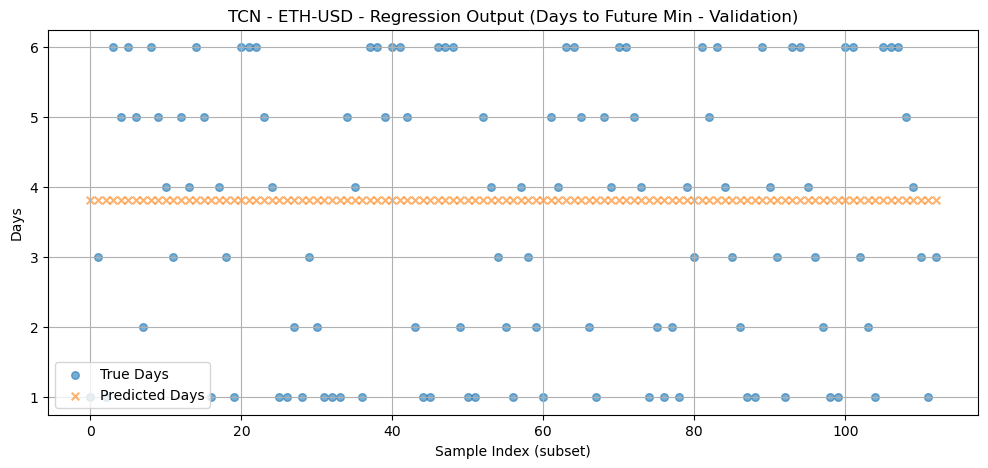


-- Training Mega TCN for ETH-USD --
Epoch 1/2000
74/74 ━━━━━━━━━━━━━━━━━━━━ 21s 65ms/step - binary_output_accuracy: 0.5347 - binary_output_loss: 0.8401 - binary_output_precision: 0.5089 - binary_output_recall: 0.5369 - loss: 1.5649 - regression_output_loss: 2.2896 - regression_output_mae: 2.2896 - val_binary_output_accuracy: 0.5841 - val_binary_output_loss: 0.6871 - val_binary_output_precision: 0.0000e+00 - val_binary_output_recall: 0.0000e+00 - val_loss: 1.3184 - val_regression_output_loss: 1.8702 - val_regression_output_mae: 1.9492 - learning_rate: 0.0010
Epoch 2/2000
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - binary_output_accuracy: 0.5116 - binary_output_loss: 0.7975 - binary_output_precision: 0.4804 - binary_output_recall: 0.4329 - loss: 1.3876 - regression_output_loss: 1.9778 - regression_output_mae: 1.9778 - val_binary_output_accuracy: 0.5841 - val_binary_output_loss: 0.6839 - val_binary_output_precision: 0.0000e+00 - val_binary_output_recall: 0.0000e+00 - val_loss: 1.3901 - val

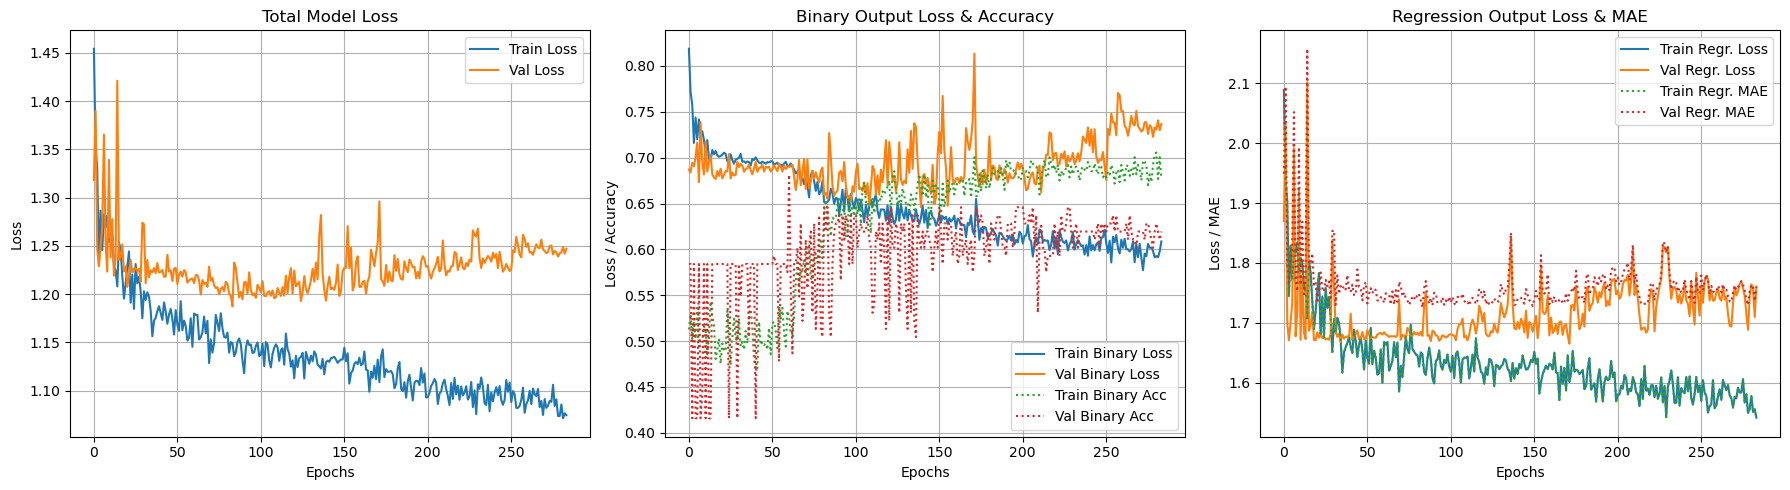

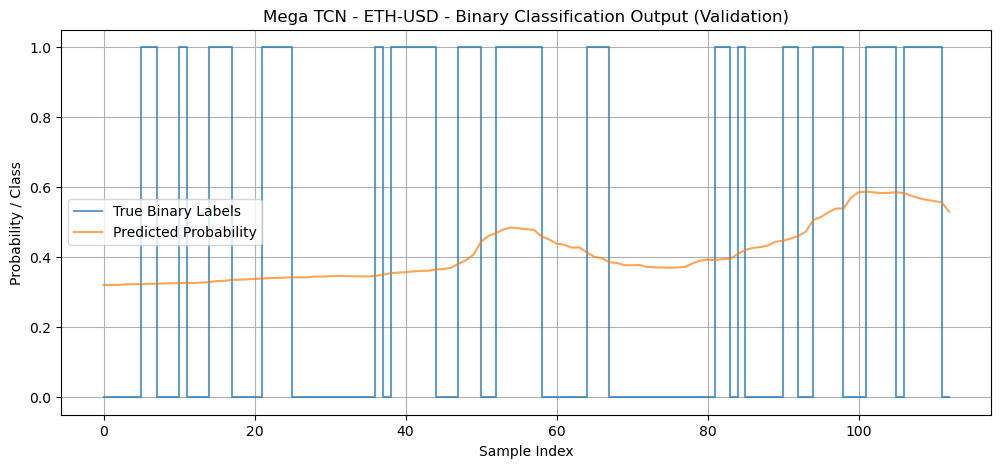

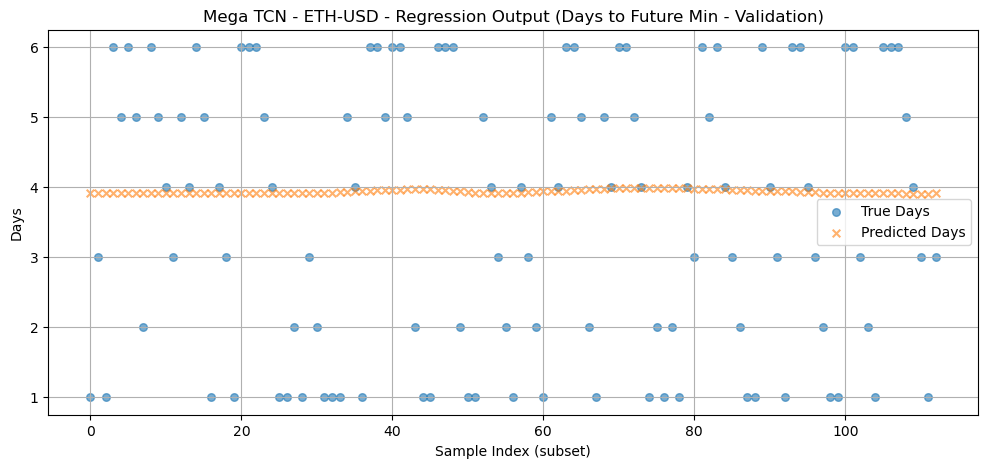


-- Training Hybridatt for ETH-USD --
Epoch 1/2000
74/74 ━━━━━━━━━━━━━━━━━━━━ 16s 32ms/step - binary_output_accuracy: 0.5071 - binary_output_loss: 0.7523 - binary_output_precision: 0.5057 - binary_output_recall: 0.4587 - loss: 1.5737 - regression_output_loss: 2.3950 - regression_output_mae: 2.3950 - val_binary_output_accuracy: 0.5841 - val_binary_output_loss: 0.6683 - val_binary_output_precision: 0.0000e+00 - val_binary_output_recall: 0.0000e+00 - val_loss: 1.2213 - val_regression_output_loss: 1.6785 - val_regression_output_mae: 1.7658 - learning_rate: 0.0010
Epoch 2/2000
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - binary_output_accuracy: 0.4947 - binary_output_loss: 0.7619 - binary_output_precision: 0.4848 - binary_output_recall: 0.3894 - loss: 1.2478 - regression_output_loss: 1.7337 - regression_output_mae: 1.7337 - val_binary_output_accuracy: 0.4159 - val_binary_output_loss: 0.7077 - val_binary_output_precision: 0.4159 - val_binary_output_recall: 1.0000 - val_loss: 1.2328 - val_regres

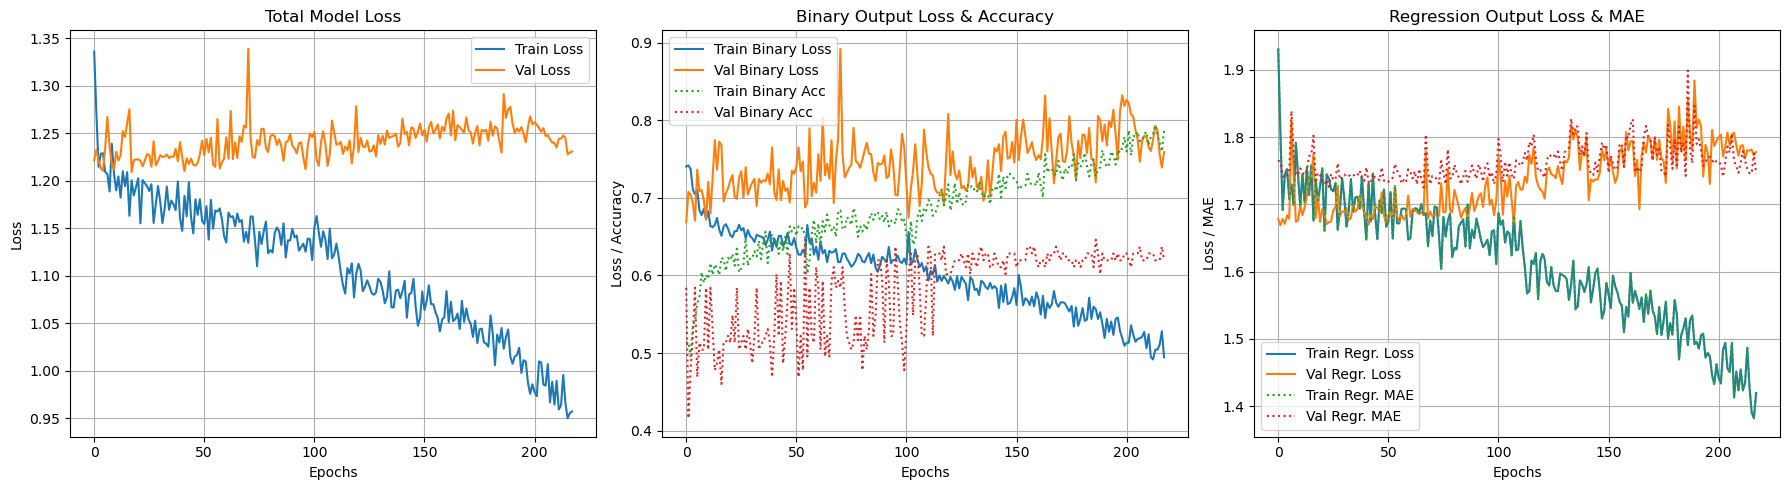

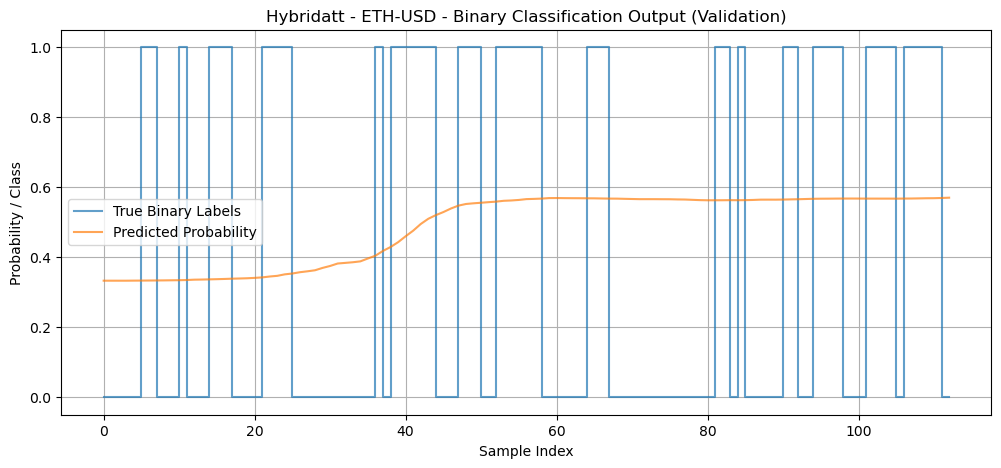

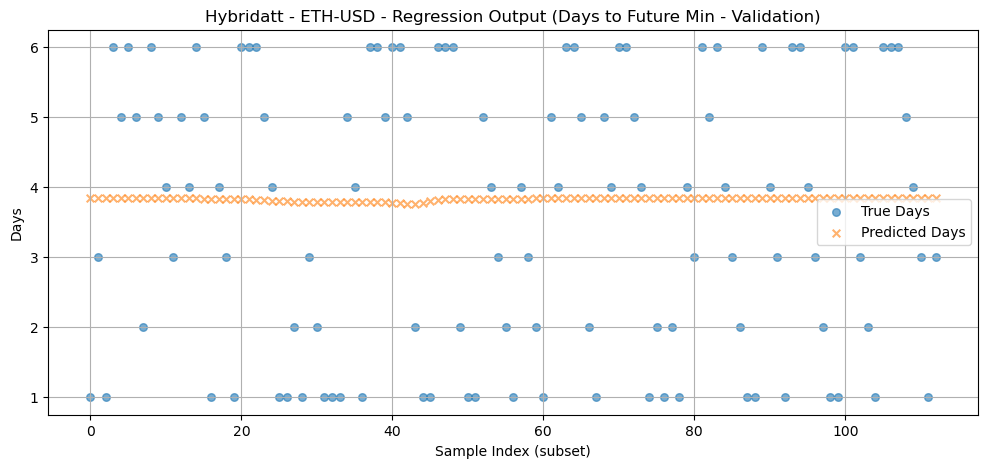

In [371]:
# Define model constructors once
model_builders = {
    "LSTM": build_lstm_model,
    "GRU": build_gru_model,
    "Hybrid_LSTM_GRU": build_hybrid_lstm_gru_model,
    "TCN": build_tcn_model,
    "Mega TCN": build_hybrid_tcn_lstm_gru_model,
    "Hybridatt": build_hybrid_attention_model
}

# Loop through all symbols
for symbol, data in all_symbols_modeling_data.items():
    print(f"\n--- Training models for {symbol} ---")

    X_train, y_bin_train, y_reg_train = data['X_train_seq'], data['y_train_bin_seq'], data['y_train_reg_seq']
    X_val, y_bin_val, y_reg_val = data['X_val_seq'], data['y_val_bin_seq'], data['y_val_reg_seq']
    input_shape = data.get('input_shape')

    if X_train.size == 0 or not input_shape:
        print(f"Skipping {symbol}: No training data or invalid input shape.")
        continue

    # Prepare storage for the symbol
    all_models_history[symbol] = {}
    all_models_evaluation[symbol] = {}
    all_trained_models[symbol] = {}

    # Set up early stopping
    monitor_metric = 'val_loss' if X_val.size > 0 else 'loss'
    early_stop = EarlyStopping(
        monitor=monitor_metric,
        patience=PATIENCE_EARLY_STOPPING,
        restore_best_weights=True,
        verbose=1
    )
    lr_schedule = ReduceLROnPlateau(
        monitor=monitor_metric, 
        factor=0.5, 
        patience=90
    )

    # Train all models
    for model_name, build_fn in model_builders.items():
        print(f"\n-- Training {model_name} for {symbol} --")
        keras.backend.clear_session()

        model = build_fn(input_shape)
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
            loss={
                'binary_output': 'binary_crossentropy',
                'regression_output': 'mae'
            },
            loss_weights={
                'binary_output': 0.5,
                'regression_output': 0.5
            },
            metrics={
                'binary_output': ['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()],
                'regression_output': 'mae'
            }
        )

        val_data = (X_val, {'binary_output': y_bin_val, 'regression_output': y_reg_val}) if X_val.size > 0 else None
        if not val_data:
            print(f"{model_name} for {symbol} will train without validation data.")

        history = model.fit(
            X_train,
            {'binary_output': y_bin_train, 'regression_output': y_reg_train},
            validation_data=val_data,
            epochs=EPOCHS,
            batch_size=BATCH_SIZE,
            callbacks=[early_stop, lr_schedule],
            verbose=1
        )

        all_models_history[symbol][model_name] = history
        all_trained_models[symbol][model_name] = model

        print(f"\n-- Evaluating {model_name} for {symbol} --")
        eval_result = plot_and_evaluate(
            model, history,
            X_val, y_bin_val, y_reg_val,
            experiment_name=f"{model_name} - {symbol}"
        )
        all_models_evaluation[symbol][model_name] = eval_result


# Model Performance Summary

In [372]:
print("\n\n--- Model Performance Summary (MAE in Days & Accuracy on Validation Set) ---")

for symbol, eval_results in all_models_evaluation.items():
    print(f"\nSymbol: {symbol}")

    if not eval_results:
        print("  No evaluation data.")
        continue

    for model_name, metrics in eval_results.items():
        if not metrics:
            print(f"  {model_name}: No metrics available.")
            continue

        mae = metrics.get('mae_days')
        acc = metrics.get('accuracy')

        mae_str = f"{mae:.2f} days" if mae is not None and not np.isnan(mae) else "N/A"
        acc_str = f"{acc:.2%}" if acc is not None and not np.isnan(acc) else "N/A"

        print(f"  {model_name:<15}: MAE = {mae_str:<10}, Accuracy = {acc_str}")



--- Model Performance Summary (MAE in Days & Accuracy on Validation Set) ---

Symbol: ETH-USD
  LSTM           : MAE = 1.74 days , Accuracy = 61.06%
  GRU            : MAE = 1.70 days , Accuracy = 55.75%
  Hybrid_LSTM_GRU: MAE = 1.66 days , Accuracy = 69.03%
  TCN            : MAE = 1.73 days , Accuracy = 58.41%
  Mega TCN       : MAE = 1.73 days , Accuracy = 64.60%
  Hybridatt      : MAE = 1.73 days , Accuracy = 51.33%


**Troubleshooting Data**

In [373]:
print("\n--- Starting Final Model Evaluation on Test Data ---")

# Sikre at nødvendige globale variabler eksisterer
required_globals = {
    'all_trained_models': {},
    'all_symbols_processed_dfs_for_eda': {},
    'all_symbols_modeling_data': {},
    'symbols_to_process': [],
    #'model_types': {}

    #Vi har allerede model_builders for 'model_types'
}

for var_name, default_value in required_globals.items():
    if var_name not in globals():
        warnings.warn(f"Global variable '{var_name}' not found. Defaulting to empty.")
        globals()[var_name] = default_value

# Hent modellnavn som skal evalueres (kun hvis model_types er gyldig)
model_names_to_evaluate = list(model_builders.keys()) if model_builders else []


--- Starting Final Model Evaluation on Test Data ---


**Helper Method #1**

In [374]:
def prepare_test_data(test_df_processed, scaler, numeric_features, time_steps, target_cols):
    """
    Scales test features and creates time sequences.

    Args:
        test_df_processed (pd.DataFrame): The preprocessed test DataFrame.
        scaler (MinMaxScaler): The scaler fitted on the training data.
        numeric_features (list): List of numeric feature column names.
        time_steps (int): The number of time steps for sequences.
        target_cols (list): List of target column names.

    Returns:
        tuple: (X_test_seq, y_test_bin_seq, y_test_reg_seq) or (None, None, None) if insufficient data or error.
    """
    if test_df_processed.empty or scaler is None or numeric_features is None or time_steps is None:
        print("Prepare Test Data: Missing essential inputs (empty df, scaler, features, or time_steps).")
        return None, None, None

    # Separate features and targets
    X_test_raw = test_df_processed[numeric_features]
    y_test_df = test_df_processed[target_cols]

    # Check if enough data exists for sequences
    if len(X_test_raw) <= time_steps:
        print(f"Prepare Test Data: Not enough data ({len(X_test_raw)} rows) to create sequences with time_steps={time_steps}.")
        return None, None, None

    # Apply the *same* scaler fitted on training data to the test features
    X_test_scaled = scaler.transform(X_test_raw)
    X_test_final = pd.DataFrame(X_test_scaled, columns=numeric_features, index=X_test_raw.index)

    # Create sequences for the test data
    try:
        # Assuming create_sequences function is accessible in this scope
        X_test_seq, y_test_bin_seq, y_test_reg_seq = create_sequences(X_test_final, y_test_df, time_steps)
        if X_test_seq.size == 0:
             print("Prepare Test Data: Test sequences are empty after creation.")
             return None, None, None
        print(f"Prepare Test Data: Test sequences created. Shape: {X_test_seq.shape}")
        return X_test_seq, y_test_bin_seq, y_test_reg_seq

    except NameError:
         print("Prepare Test Data Error: 'create_sequences' function not found. Please ensure it's defined.")
         return None, None, None
    except Exception as e:
         print(f"Prepare Test Data Error creating test sequences: {e}")
         return None, None, None

**Helper Method #2**

In [375]:
from sklearn.metrics import confusion_matrix, classification_report, mean_absolute_error, accuracy_score, roc_curve, auc, mean_squared_error # Import roc_curve, auc, and mean_squared_error



def evaluate_model_on_test_data(model, X_test_seq, y_test_bin_seq, y_test_reg_seq, symbol, model_name):
    """
    Evaluates a trained model on test sequences, calculates metrics, and generates plots.

    Args:
        model: The trained Keras model.
        X_test_seq (np.ndarray): Test feature sequences.
        y_test_bin_seq (np.ndarray): True binary test targets.
        y_test_reg_seq (np.ndarray): True regression test targets.
        symbol (str): The symbol being evaluated (for plotting titles).
        model_name (str): The name of the model being evaluated (for plotting titles).

    Returns:
        dict: A dictionary containing evaluation results.
    """
    current_eval_results = {} # Dictionary to store results for this model/symbol

    if X_test_seq is None or X_test_seq.size == 0:
        print(f"Evaluate Model: Skipping evaluation for model '{model_name}' on {symbol} due to empty test sequences.")
        current_eval_results['status'] = 'Skipped - Empty Test Sequences'
        return current_eval_results

    print(f"\n--- Evaluating Model '{model_name}' for {symbol} ---")

    # 1. Make Predictions
    try:
        # Assuming your model outputs predictions for both targets in this order
        predictions = model.predict(X_test_seq)

        # Assuming the first output is binary (classification) and the second is regression
        # Ensure predictions is a list or tuple even if only one output exists
        if not isinstance(predictions, (list, tuple)):
             predictions = [predictions] # Wrap in list if single output

        # Adjust indices based on which output is which in your model
        # Assuming binary is first, regression is second
        bin_predictions_proba = predictions[0]
        # For binary output from a model with potentially multiple outputs,
        # ensure you get the probabilities for the positive class (class 1)
        # If predictions[0] is shape (n_samples, 2) for one-hot, take[:, 1]
        # If predictions[0] is shape (n_samples, 1) for sigmoid, flatten()
        if bin_predictions_proba.ndim > 1 and bin_predictions_proba.shape[-1] == 2:
            bin_predictions_proba = bin_predictions_proba[:, 1] # Probabilities for class 1
        elif bin_predictions_proba.ndim > 1 and bin_predictions_proba.shape[-1] == 1:
             bin_predictions_proba = bin_predictions_proba.flatten() # Flatten sigmoid output

        reg_predictions = predictions[1] # Predicted days for regression output

        # Convert binary probabilities to class predictions (0 or 1)
        bin_predictions_classes = (bin_predictions_proba > 0.5).astype(int) # Assuming sigmoid output for binary

    except Exception as e:
        print(f"Evaluate Model Error during prediction for model '{model_name}' on {symbol}: {e}")
        current_eval_results['status'] = f'Prediction Error: {e}'
        return current_eval_results

    # 2. Calculate Metrics and Generate Plots

    # --- Binary Classification Evaluation ---
    print("\nBinary Target ('binary_target'):")

    if len(y_test_bin_seq) > 0 and len(bin_predictions_classes) > 0:
        try:
            # Print and store Classification Report
            class_report_str = classification_report(y_test_bin_seq, bin_predictions_classes, zero_division=0)
            print("Classification Report:")
            print(class_report_str)
            current_eval_results['binary_classification_report'] = class_report_str # Store the string report

            # Calculate and store individual metrics
            accuracy = accuracy_score(y_test_bin_seq, bin_predictions_classes)
            current_eval_results['binary_accuracy'] = accuracy

            # --- Confusion Matrix Plot ---
            cm = confusion_matrix(y_test_bin_seq, bin_predictions_classes)
            plt.figure(figsize=(6, 5))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                        xticklabels=['Predicted 0', 'Predicted 1'],
                        yticklabels=['Actual 0', 'Actual 1'])
            plt.title(f'Model "{model_name}": Confusion Matrix ({symbol} Test Set)')
            plt.xlabel('Predicted Label')
            plt.ylabel('True Label')
            plt.show()

            # --- Prediction Probability Distribution Plot ---
            if len(bin_predictions_proba) == len(y_test_bin_seq): # Ensure probabilities match targets
                plt.figure(figsize=(10, 6))
                sns.histplot(bin_predictions_proba[y_test_bin_seq == 0], color='skyblue', label='Actual 0', kde=True, stat='density', common_norm=False)
                sns.histplot(bin_predictions_proba[y_test_bin_seq == 1], color='lightcoral', label='Actual 1', kde=True, stat='density', common_norm=False)
                plt.title(f'Model "{model_name}": Prediction Probability Distribution ({symbol} Test Set)')
                plt.xlabel('Predicted Probability of Class 1')
                plt.ylabel('Density')
                plt.legend()
                plt.grid(True)
                plt.show()

                # --- ROC Curve and AUC ---
                # Ensure there's variance in the true targets and predictions for ROC
                if len(np.unique(y_test_bin_seq)) > 1 and len(np.unique(bin_predictions_proba)) > 1:
                    fpr, tpr, thresholds = roc_curve(y_test_bin_seq, bin_predictions_proba)
                    roc_auc = auc(fpr, tpr)

                    plt.figure(figsize=(8, 8))
                    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
                    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
                    plt.xlim([0.0, 1.0])
                    plt.ylim([0.0, 1.05])
                    plt.xlabel('False Positive Rate')
                    plt.ylabel('True Positive Rate')
                    plt.title(f'Model "{model_name}": Receiver Operating Characteristic ({symbol} Test Set)')
                    plt.legend(loc="lower right")
                    plt.grid(True)
                    plt.show()
                    current_eval_results['binary_roc_auc'] = roc_auc
                else:
                     print("Not enough variance in true targets or probabilities to plot ROC curve.")
                     current_eval_results['binary_roc_auc'] = np.nan # Store NaN if not plottable


            current_eval_results['status'] = 'Completed' # Mark as completed if plots succeed

        except Exception as e:
            print(f"Evaluate Model Error calculating binary metrics or plotting for model '{model_name}': {e}")
            current_eval_results['binary_metrics_error'] = str(e)
            current_eval_results['status'] = f'Binary Eval Error: {e}' # Mark as error
    else:
        print("Evaluate Model: Not enough data to calculate binary metrics.")
        current_eval_results['binary_metrics_info'] = "Not enough data"
        current_eval_results['status'] = 'Completed - Insufficient Binary Data'


    # --- Regression Evaluation ---
    print("\nRegression Target ('days_to_future_min_7d'):")

    if len(y_test_reg_seq) > 0 and len(reg_predictions) > 0:
         try:
            # Ensure reg_predictions has the same shape as y_test_reg_seq
            if reg_predictions.ndim > 1:
                reg_predictions = reg_predictions.flatten() # Adjust shape if necessary

            mae = mean_absolute_error(y_test_reg_seq, reg_predictions)
            print(f"Mean Absolute Error (MAE): {mae:.4f}")
            current_eval_results['regression_mae'] = mae

            # Calculate and store RMSE
            rmse = np.sqrt(mean_squared_error(y_test_reg_seq, reg_predictions))
            print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
            current_eval_results['regression_rmse'] = rmse

            # Calculate MAPE (handle division by zero if actual is 0)
            # Using a small epsilon to avoid division by zero
            mape = np.mean(np.abs((y_test_reg_seq - reg_predictions) / (y_test_reg_seq + 1e-8))) * 100
            print(f"Mean Absolute Percentage Error (MAPE): {mape:.4f}%")
            current_eval_results['regression_mape'] = mape


            # --- Regression Error Distribution Plot ---
            errors = y_test_reg_seq - reg_predictions
            plt.figure(figsize=(10, 6))
            sns.histplot(errors, kde=True, bins=30) # Added bins for better visualization
            plt.title(f'Model "{model_name}": Distribution of Regression Errors ({symbol} Test Set)')
            plt.xlabel('Error (True Days - Predicted Days)')
            plt.ylabel('Frequency')
            plt.grid(True)
            plt.show()

            # --- True vs Predicted Plot (already included) ---
            plt.figure(figsize=(12, 6))
            plt.scatter(y_test_reg_seq, reg_predictions, alpha=0.5)
            plt.xlabel("True Days to Min")
            plt.ylabel("Predicted Days to Min")
            plt.title(f"Model '{model_name}': True vs Predicted Days to Future Min ({symbol} Test Set)")
            plt.plot([y_test_reg_seq.min(), y_test_reg_seq.max()], [y_test_reg_seq.min(), y_test_reg_seq.max()], 'r--') # Diagonal line
            plt.grid(True)
            plt.show()

            # --- Residual Plot (Errors vs Predicted Values) ---
            plt.figure(figsize=(12, 6))
            plt.scatter(reg_predictions, errors, alpha=0.5)
            plt.axhline(0, color='r', linestyle='--', lw=2) # Add a horizontal line at 0 error
            plt.xlabel("Predicted Days to Min")
            plt.ylabel("Error (True Days - Predicted Days)")
            plt.title(f'Model "{model_name}": Residual Plot ({symbol} Test Set)')
            plt.grid(True)
            plt.show()


            if 'status' not in current_eval_results or current_eval_results['status'].startswith('Binary'):
                 current_eval_results['status'] = 'Completed' # Mark as completed if plots succeed here and no prior error

         except Exception as e:
            print(f"Evaluate Model Error calculating regression metrics or plotting for model '{model_name}': {e}")
            current_eval_results['regression_metrics_error'] = str(e)
            current_eval_results['status'] = f'Regression Eval Error: {e}' # Mark as error
    else:
        print("Evaluate Model: Not enough data to calculate regression metrics.")
        current_eval_results['regression_metrics_info'] = "Not enough data"
        if 'status' not in current_eval_results:
             current_eval_results['status'] = 'Completed - Insufficient Regression Data'


    return current_eval_results

**Main Evalution Loop**


--- Starting Final Model Evaluation on Test Data ---

--- Processing for Symbol: ETH-USD ---
Prepare Test Data: Test sequences created. Shape: (73, 10, 152)

--- Evaluating Model 'LSTM' for ETH-USD ---
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step

Binary Target ('binary_target'):
Classification Report:
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        30
         1.0       0.59      1.00      0.74        43

    accuracy                           0.59        73
   macro avg       0.29      0.50      0.37        73
weighted avg       0.35      0.59      0.44        73



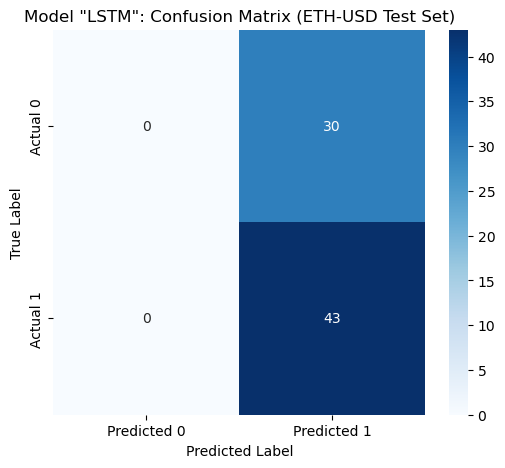

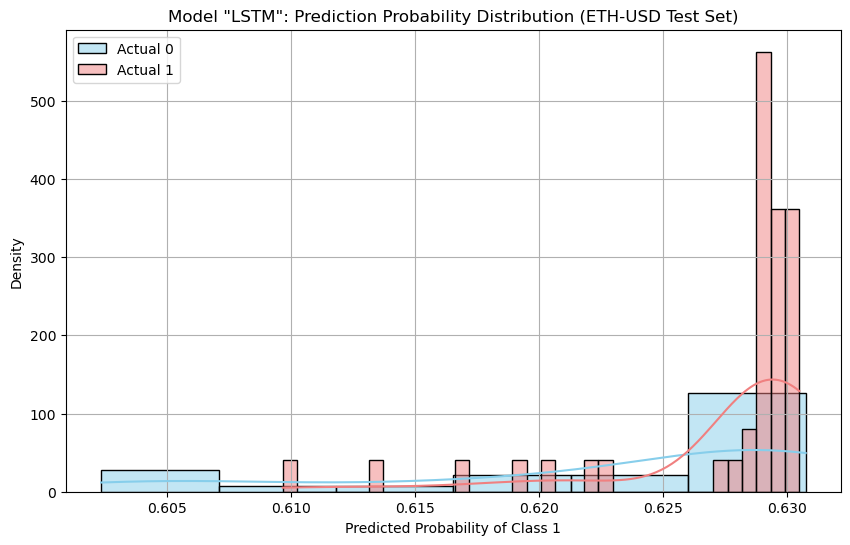

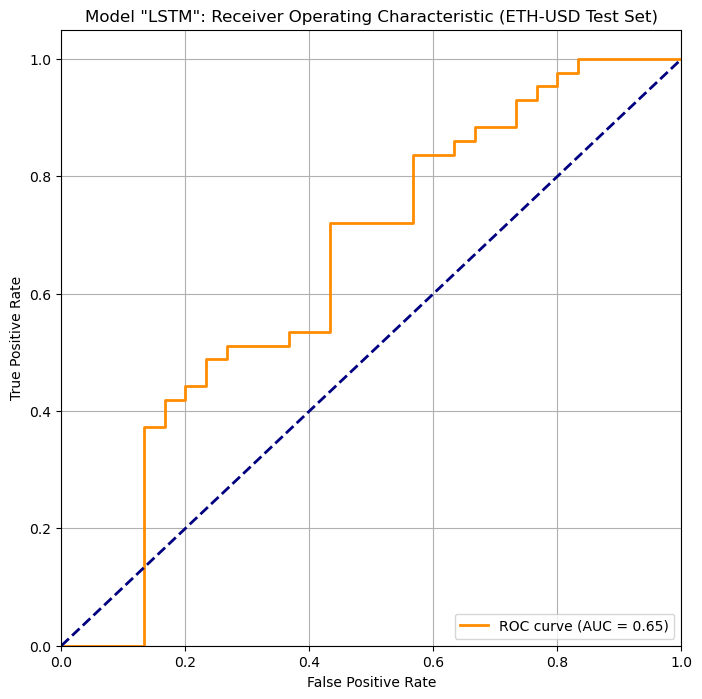


Regression Target ('days_to_future_min_7d'):
Mean Absolute Error (MAE): 1.5281
Root Mean Squared Error (RMSE): 1.7738
Mean Absolute Percentage Error (MAPE): 70.4178%


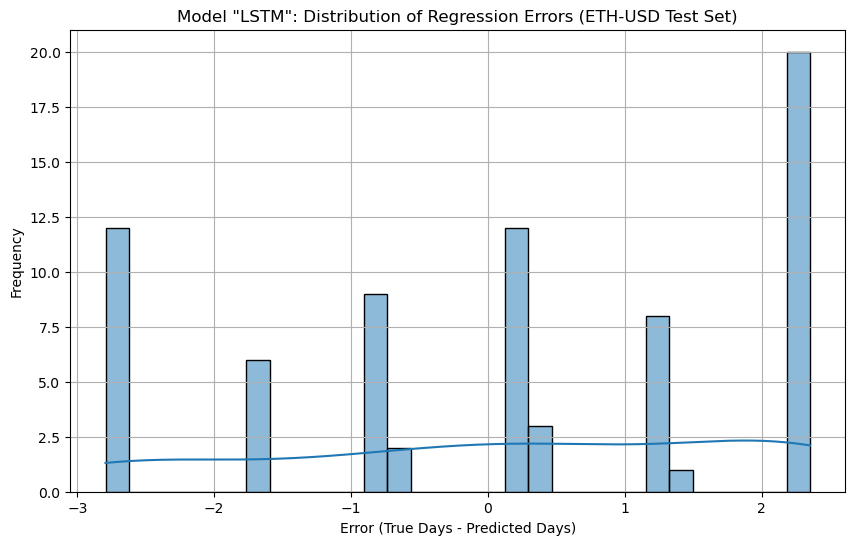

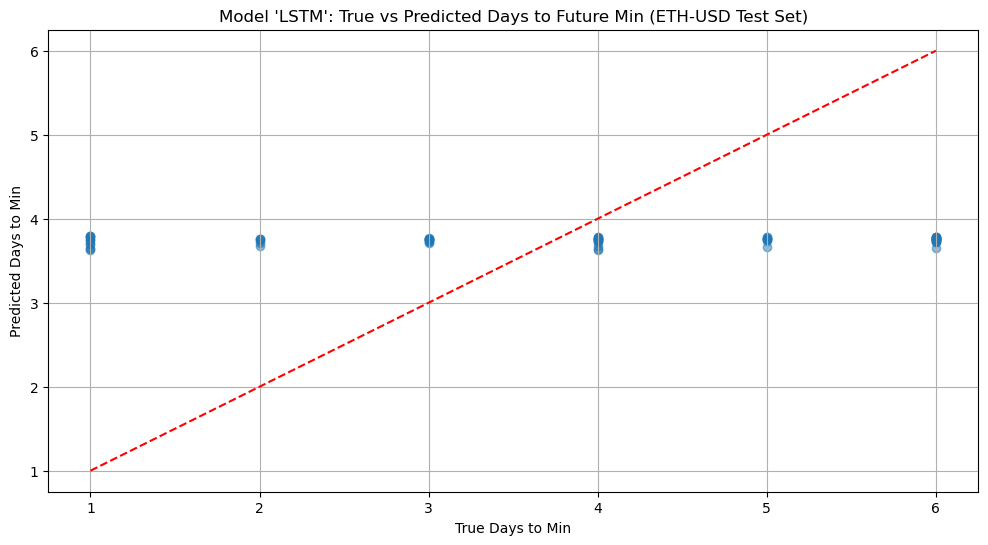

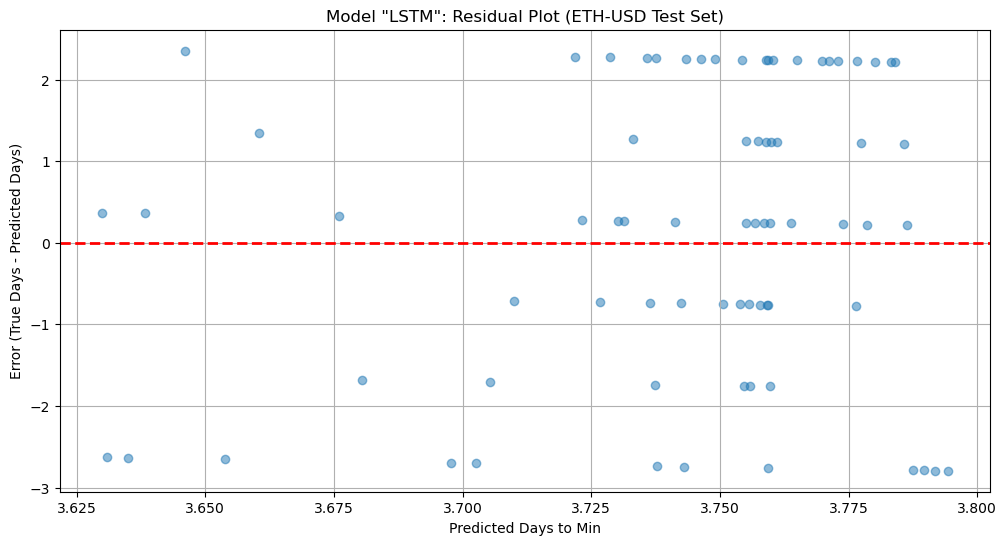


--- Evaluating Model 'GRU' for ETH-USD ---
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step

Binary Target ('binary_target'):
Classification Report:
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        30
         1.0       0.59      1.00      0.74        43

    accuracy                           0.59        73
   macro avg       0.29      0.50      0.37        73
weighted avg       0.35      0.59      0.44        73



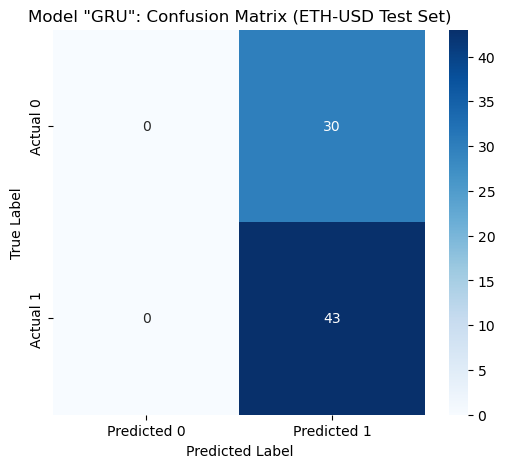

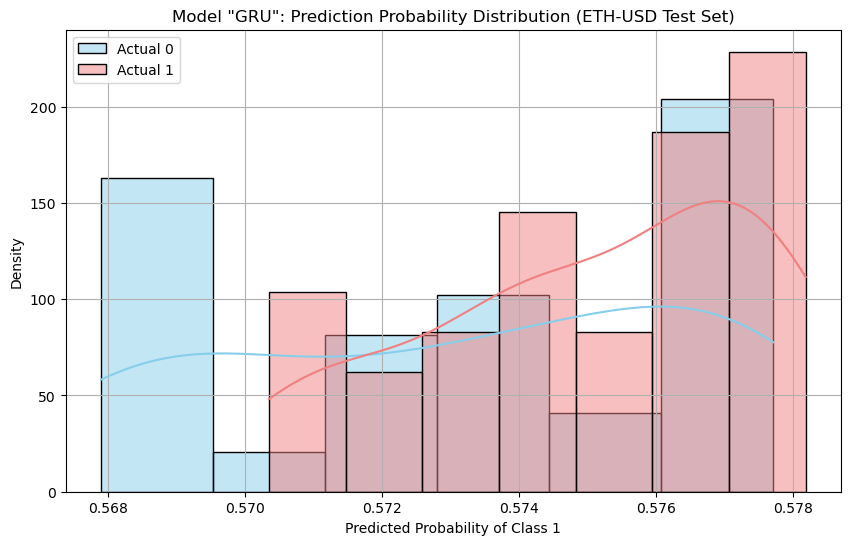

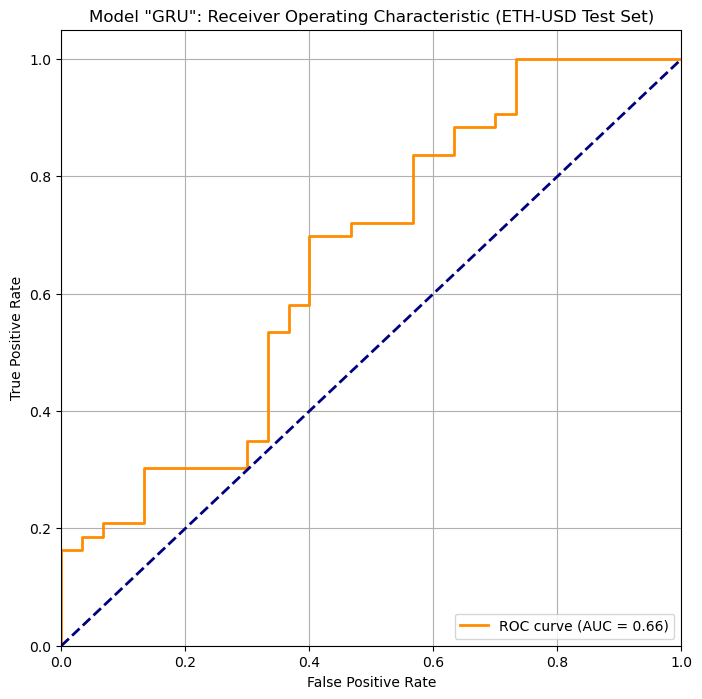


Regression Target ('days_to_future_min_7d'):
Mean Absolute Error (MAE): 1.4950
Root Mean Squared Error (RMSE): 1.7835
Mean Absolute Percentage Error (MAPE): 73.4972%


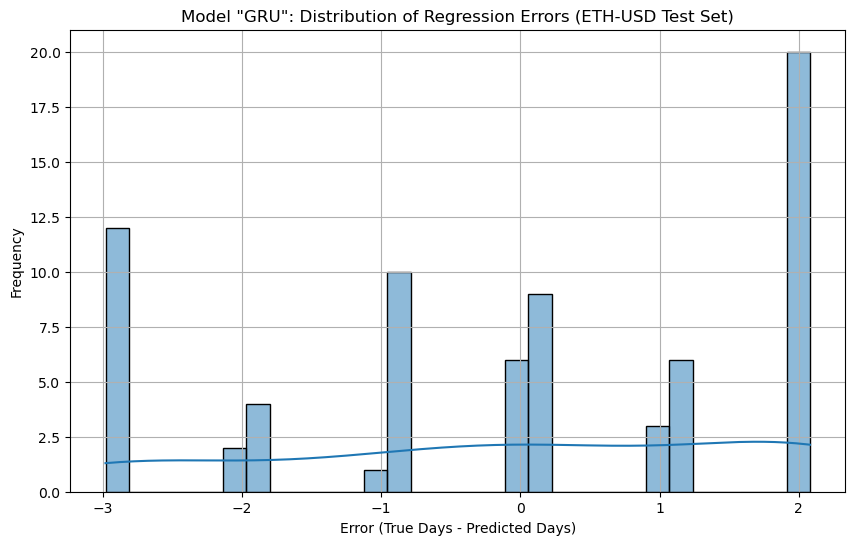

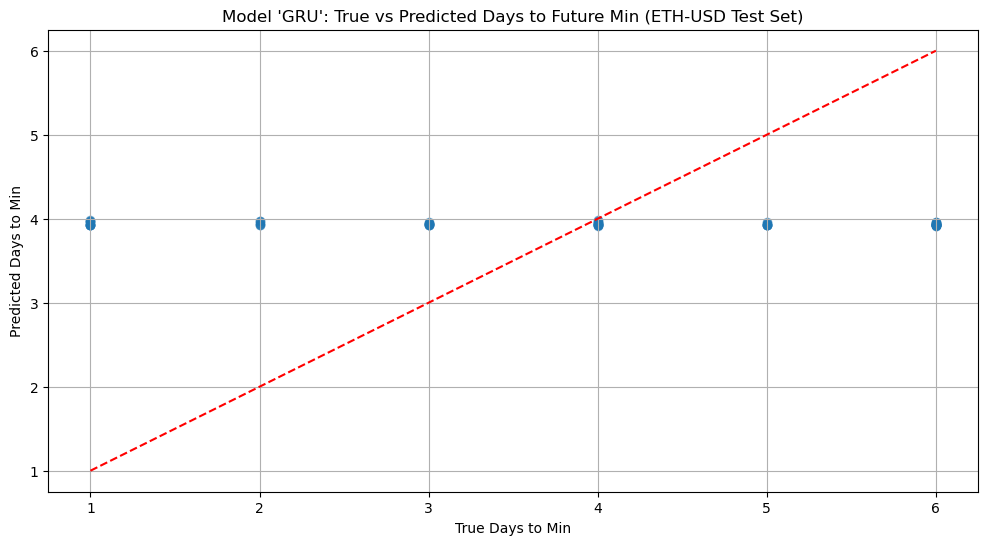

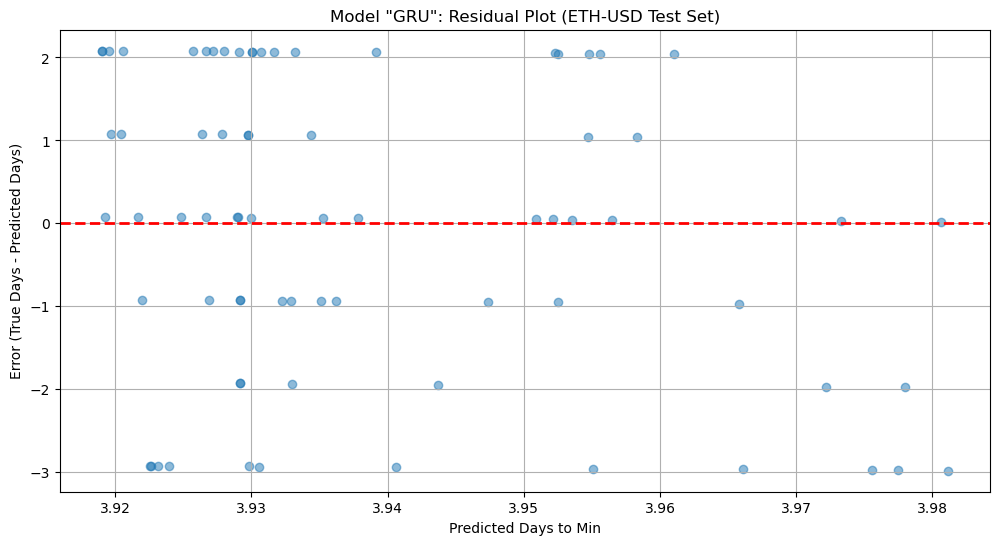


--- Evaluating Model 'Hybrid_LSTM_GRU' for ETH-USD ---
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step

Binary Target ('binary_target'):
Classification Report:
              precision    recall  f1-score   support

         0.0       0.36      0.47      0.41        30
         1.0       0.53      0.42      0.47        43

    accuracy                           0.44        73
   macro avg       0.44      0.44      0.44        73
weighted avg       0.46      0.44      0.44        73



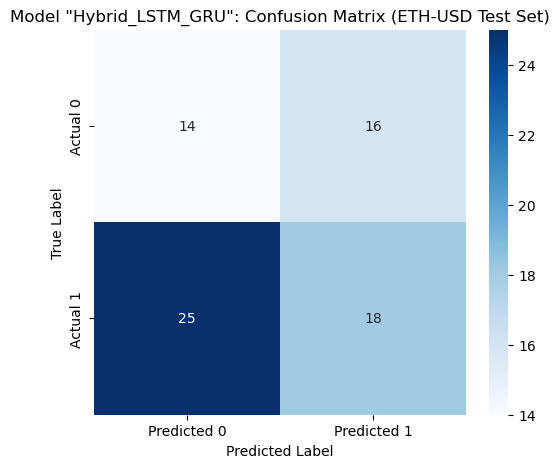

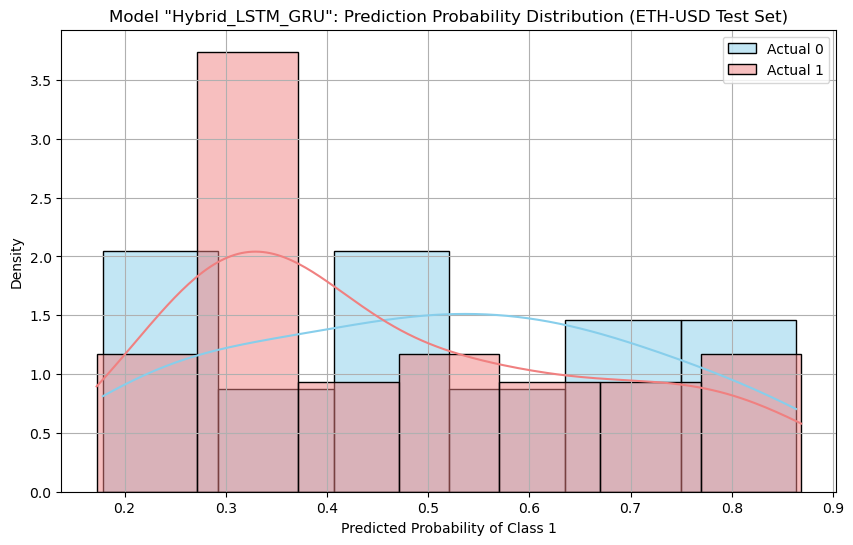

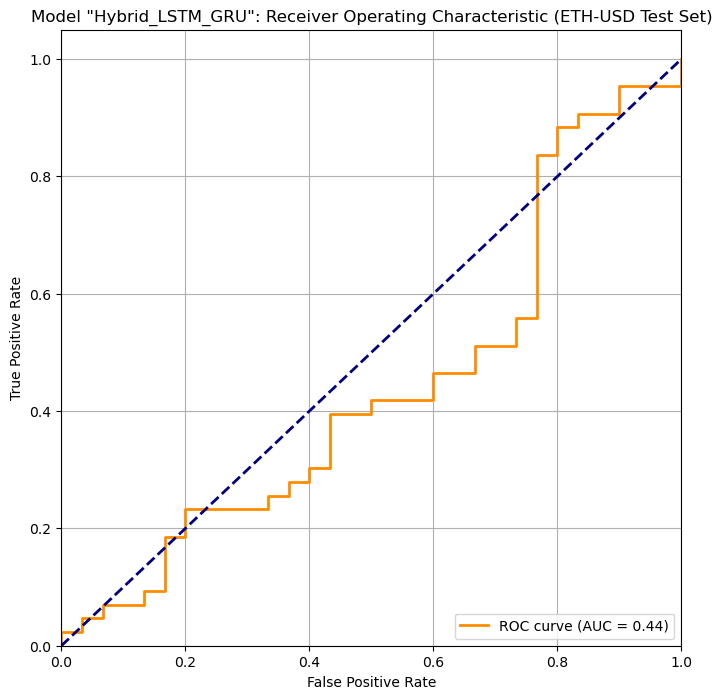


Regression Target ('days_to_future_min_7d'):
Mean Absolute Error (MAE): 1.6194
Root Mean Squared Error (RMSE): 1.9130
Mean Absolute Percentage Error (MAPE): 67.0879%


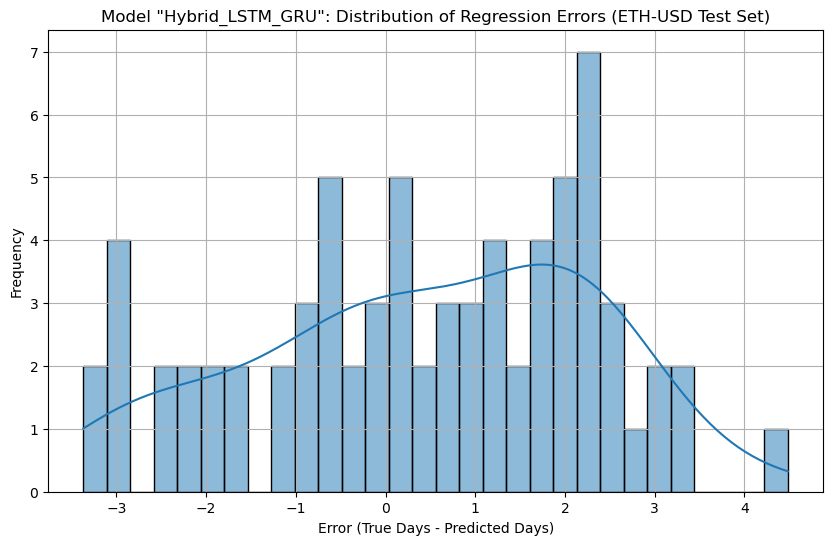

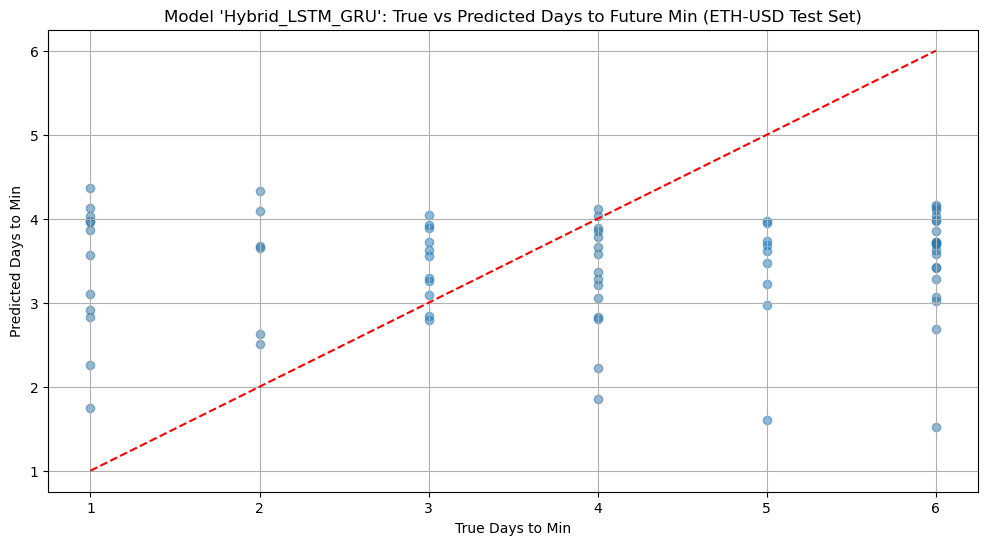

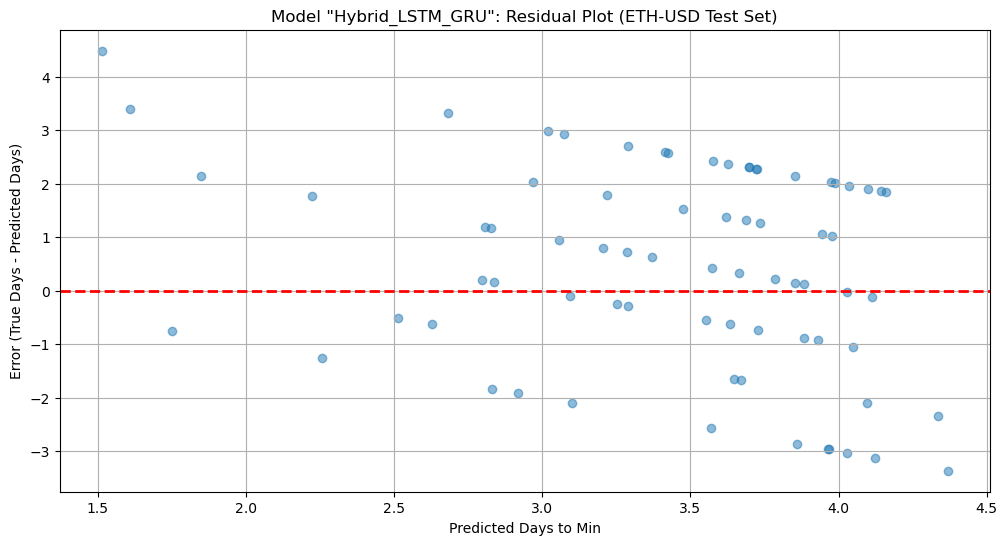


--- Evaluating Model 'TCN' for ETH-USD ---
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step

Binary Target ('binary_target'):
Classification Report:
              precision    recall  f1-score   support

         0.0       0.41      1.00      0.58        30
         1.0       0.00      0.00      0.00        43

    accuracy                           0.41        73
   macro avg       0.21      0.50      0.29        73
weighted avg       0.17      0.41      0.24        73



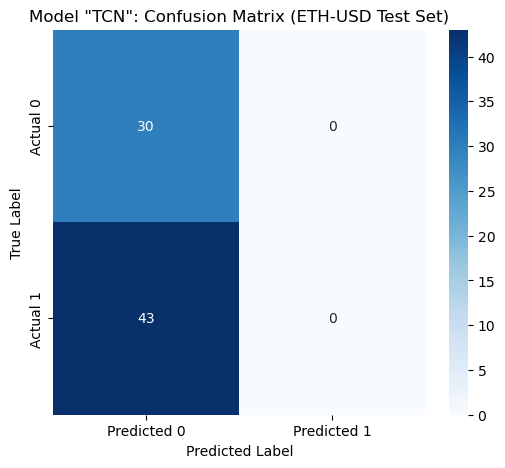

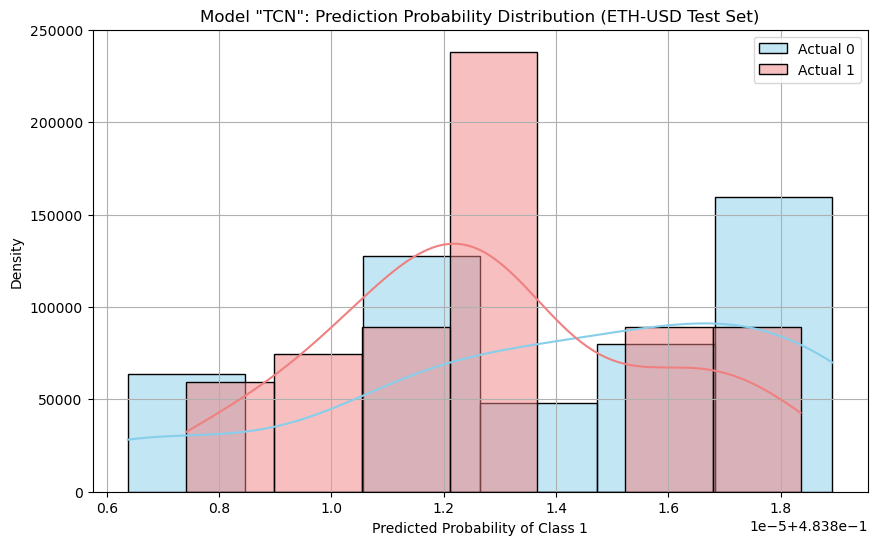

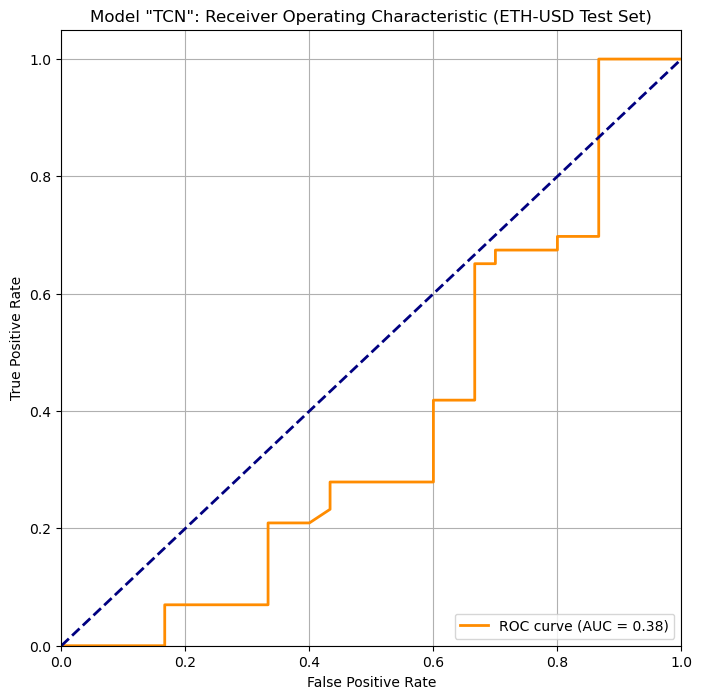


Regression Target ('days_to_future_min_7d'):
Mean Absolute Error (MAE): 1.5179
Root Mean Squared Error (RMSE): 1.7782
Mean Absolute Percentage Error (MAPE): 71.6435%


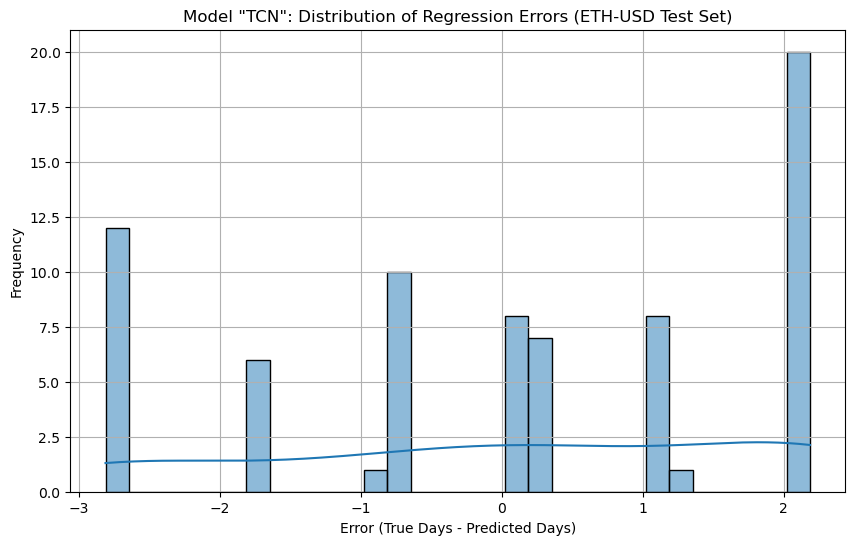

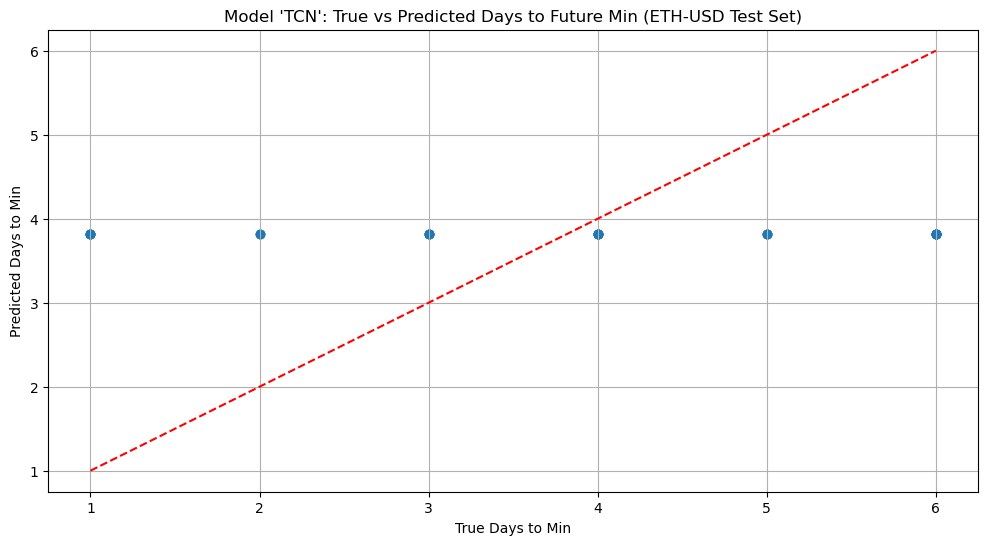

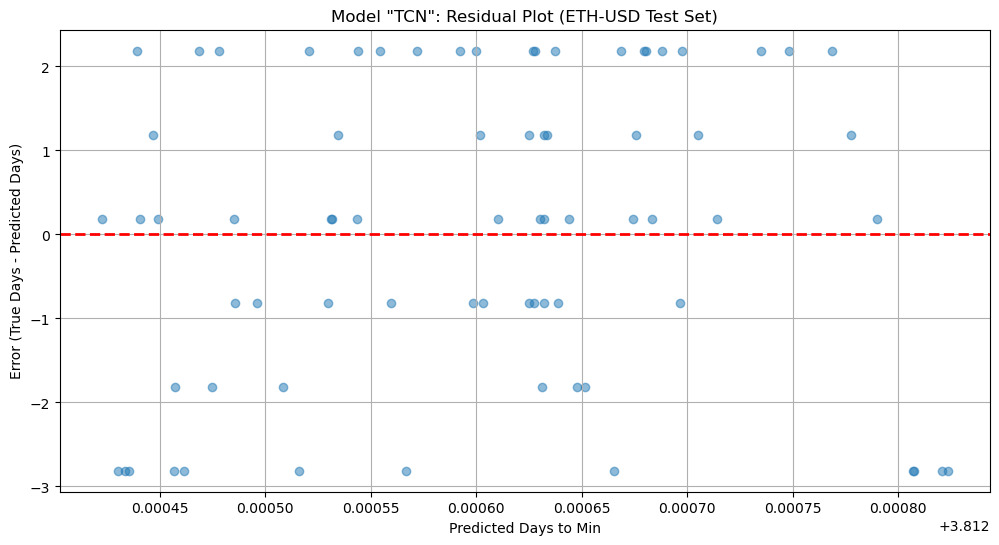


--- Evaluating Model 'Mega TCN' for ETH-USD ---
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 236ms/step

Binary Target ('binary_target'):
Classification Report:
              precision    recall  f1-score   support

         0.0       0.64      0.23      0.34        30
         1.0       0.63      0.91      0.74        43

    accuracy                           0.63        73
   macro avg       0.63      0.57      0.54        73
weighted avg       0.63      0.63      0.58        73



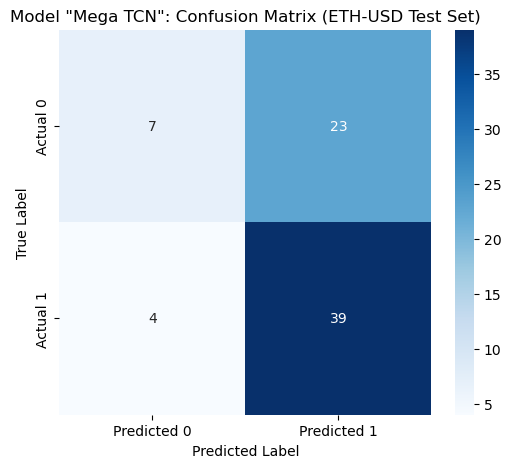

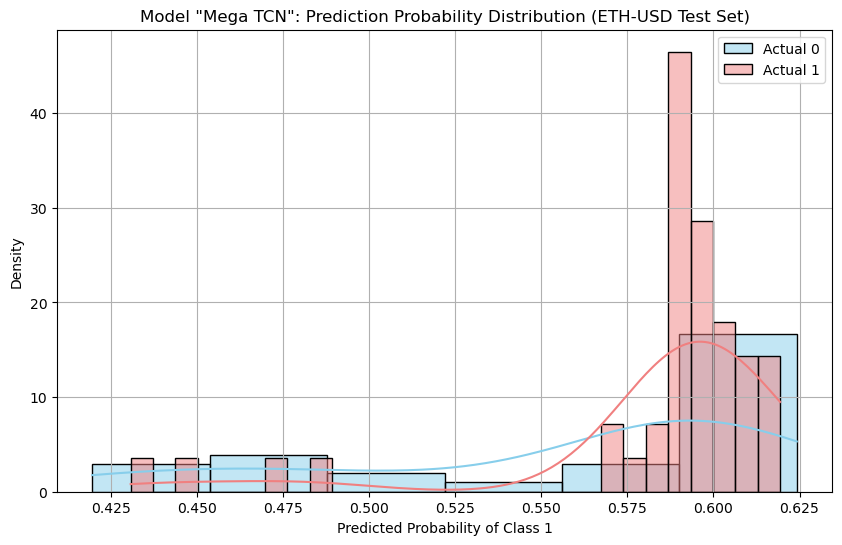

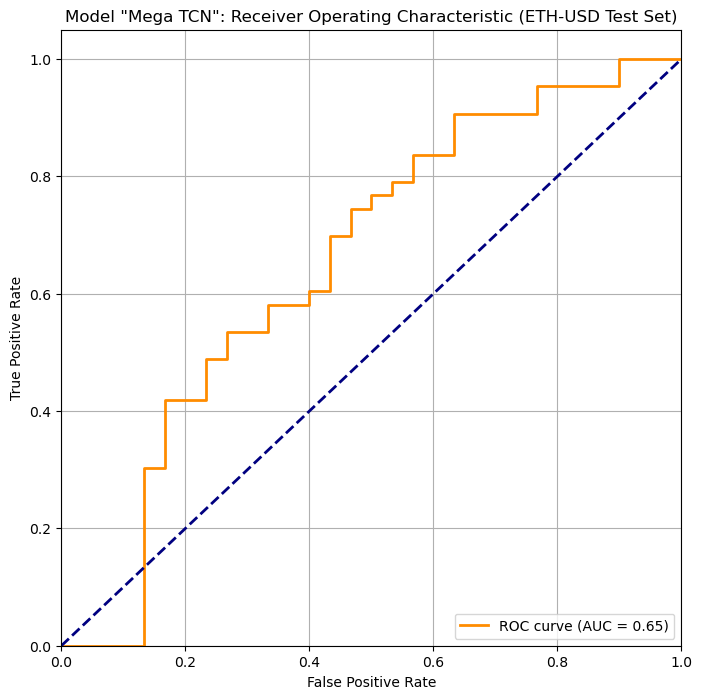


Regression Target ('days_to_future_min_7d'):
Mean Absolute Error (MAE): 1.5010
Root Mean Squared Error (RMSE): 1.7816
Mean Absolute Percentage Error (MAPE): 73.0990%


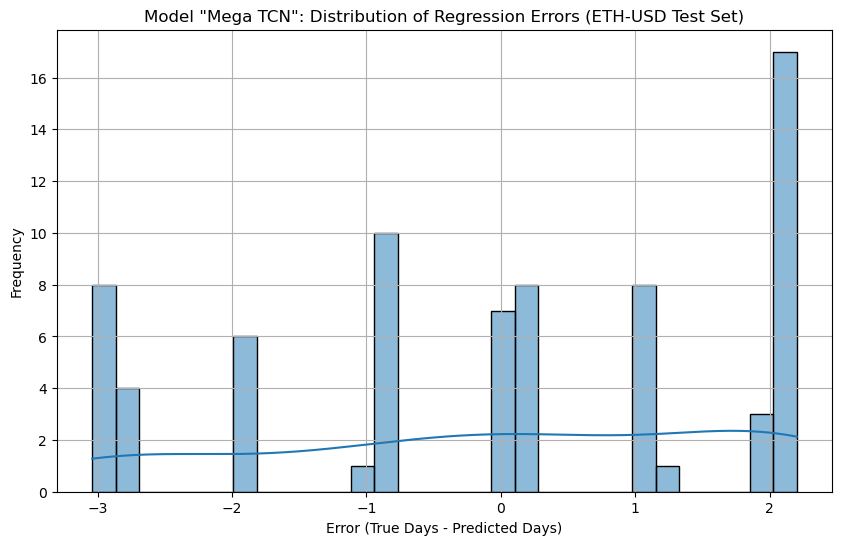

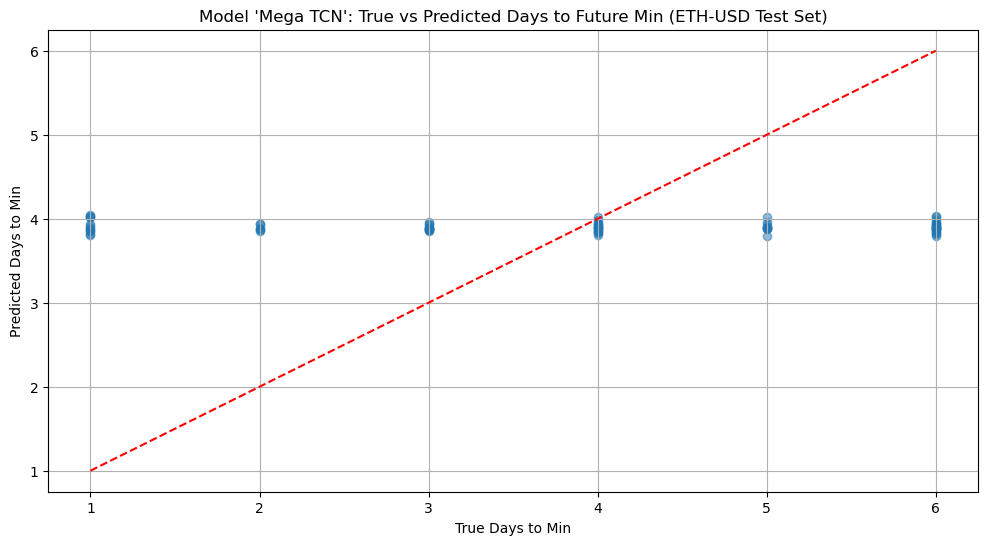

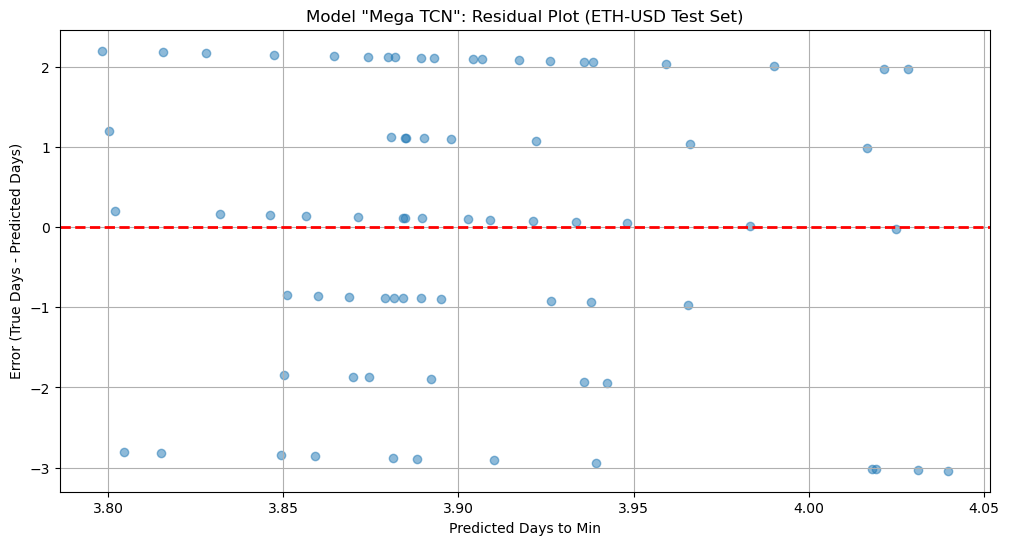


--- Evaluating Model 'Hybridatt' for ETH-USD ---
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

Binary Target ('binary_target'):
Classification Report:
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        30
         1.0       0.59      1.00      0.74        43

    accuracy                           0.59        73
   macro avg       0.29      0.50      0.37        73
weighted avg       0.35      0.59      0.44        73



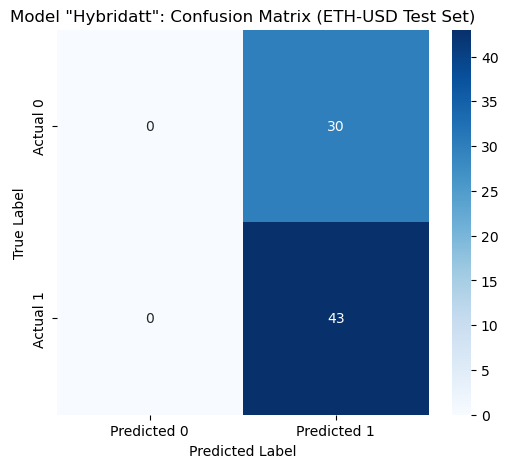

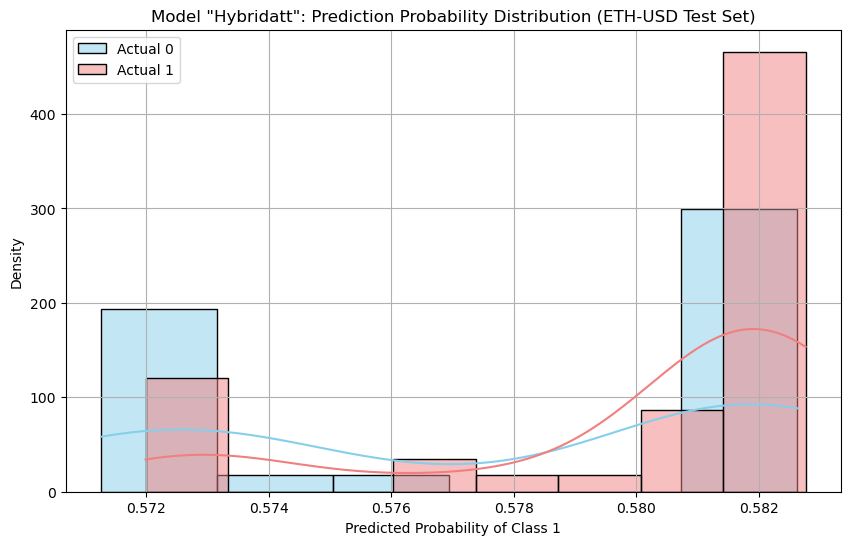

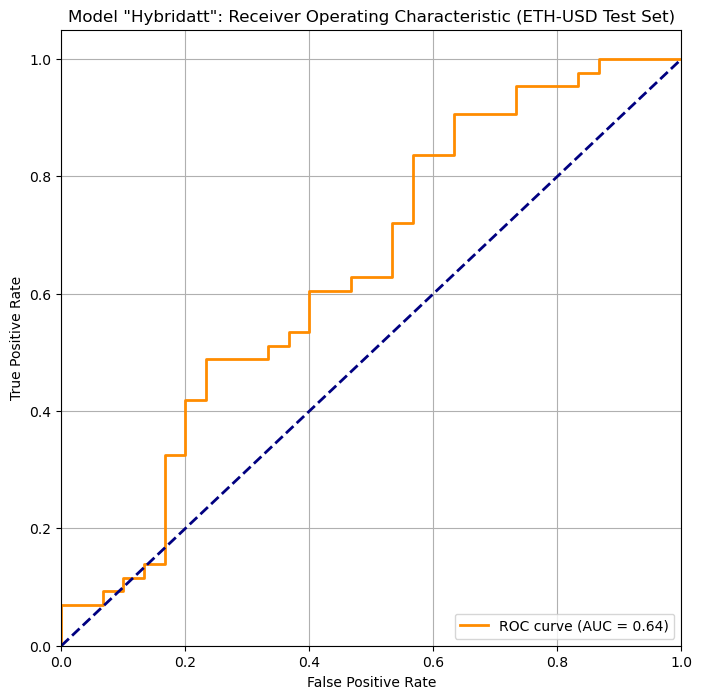


Regression Target ('days_to_future_min_7d'):
Mean Absolute Error (MAE): 1.5141
Root Mean Squared Error (RMSE): 1.7782
Mean Absolute Percentage Error (MAPE): 71.9285%


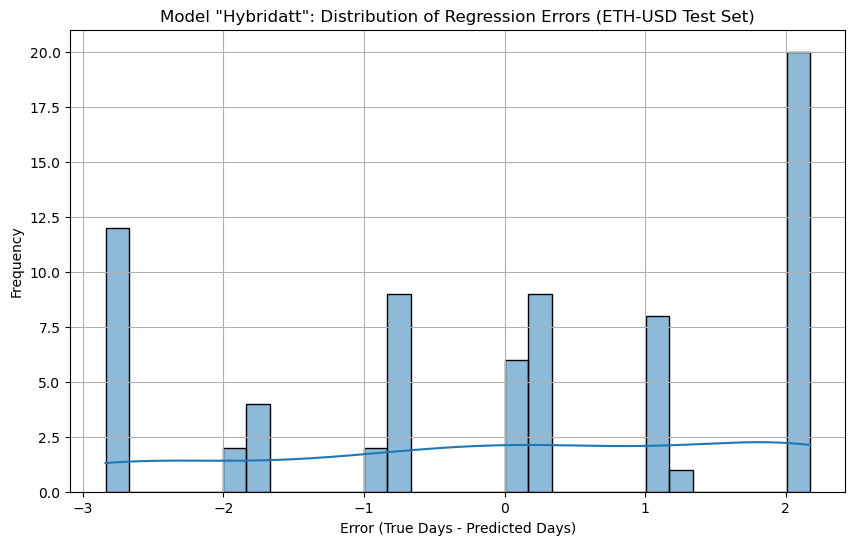

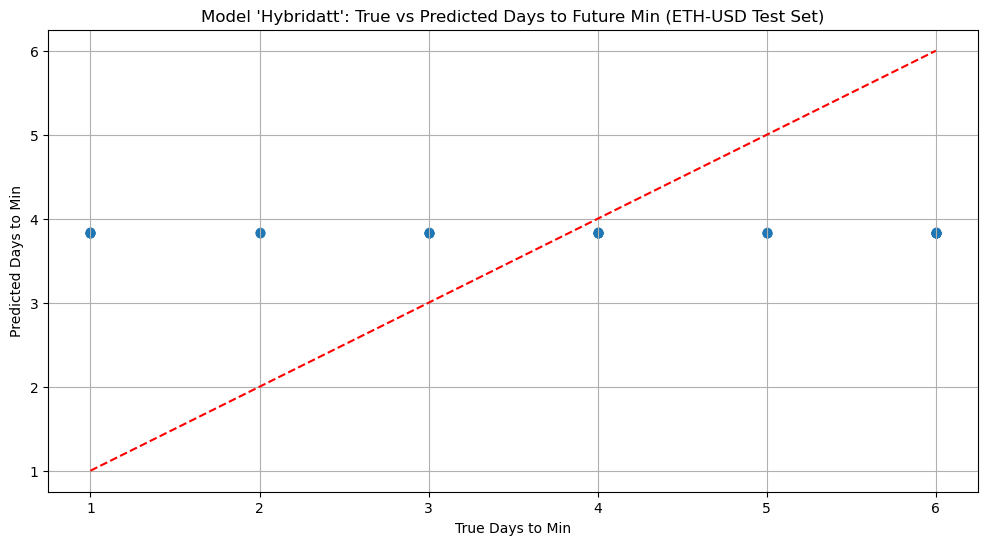

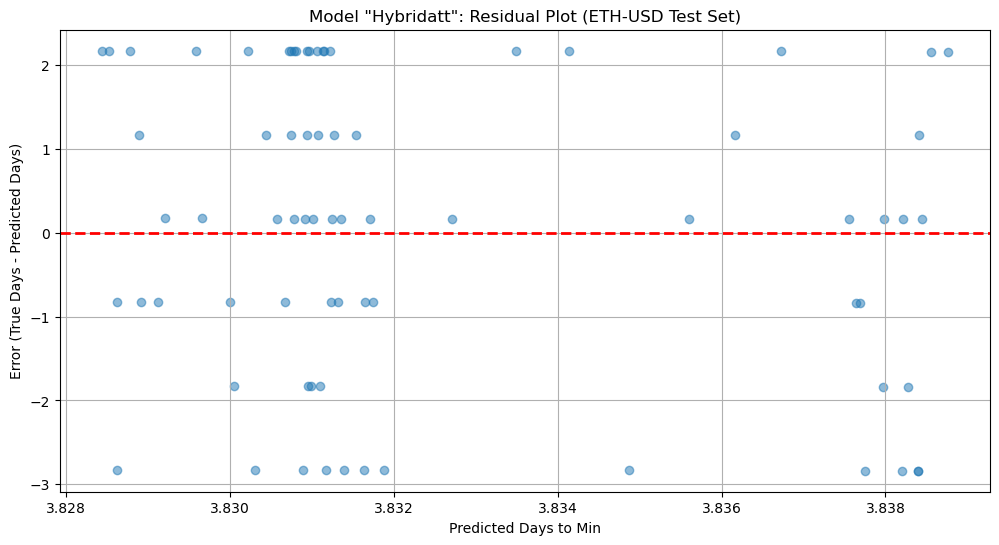


--- Final Model Evaluation Finished ---


In [376]:
def run_final_evaluation(symbols, model_types_dict, all_trained_models_dict,
                         processed_dfs_for_eda_dict, modeling_data_dict, target_cols):
    """
    Orchestrates the final model evaluation process on the test set for multiple symbols and models.

    Args:
        symbols (list): List of symbols to evaluate.
        model_types_dict (dict): Dictionary mapping model names (keys) to builder functions (values).
        all_trained_models_dict (dict): Dictionary storing trained model objects.
        processed_dfs_for_eda_dict (dict): Dictionary storing processed train/val/test dataframes.
        modeling_data_dict (dict): Dictionary storing scaler, features, time_steps etc. for each symbol.
        target_cols (list): List of final target column names.

    Returns:
        dict: A nested dictionary containing evaluation results for each symbol and model.
    """
    print("\n--- Starting Final Model Evaluation on Test Data ---")
    final_test_results = {}
    model_names_to_evaluate = list(model_types_dict.keys())

    # Check if essential dictionaries/variables exist
    if not symbols:
        print("No symbols to process. Evaluation skipped.")
        return final_test_results
    if not model_names_to_evaluate:
        print("No model names to evaluate from model_types. Evaluation skipped.")
        return final_test_results
    if not all_trained_models_dict or not processed_dfs_for_eda_dict or not modeling_data_dict:
         print("Missing one or more required input dictionaries. Evaluation skipped.")
         return final_test_results
    if target_cols is None or not isinstance(target_cols, list) or not target_cols:
         print("Target columns list is missing or empty. Evaluation skipped.")
         return final_test_results


    for symbol_eval in symbols:
        print(f"\n--- Processing for Symbol: {symbol_eval} ---")

        # --- Get Data and Prepare Test Sequences (once per symbol) ---
        test_df_processed = processed_dfs_for_eda_dict.get(symbol_eval, {}).get('test')
        symbol_modeling_data = modeling_data_dict.get(symbol_eval, {})

        if test_df_processed is None or not symbol_modeling_data:
            print(f"Skipping {symbol_eval}: Missing processed test dataframe or modeling data.")
            continue

        scaler = symbol_modeling_data.get('scaler')
        numeric_features = symbol_modeling_data.get('numeric_features')
        time_steps = symbol_modeling_data.get('time_steps')

        # Prepare Test Data
        X_test_seq, y_test_bin_seq, y_test_reg_seq = prepare_test_data(
            test_df_processed, scaler, numeric_features, time_steps, target_cols
        )

        if X_test_seq is None: # Check if prepare_test_data failed or returned empty sequences
            print(f"Skipping model evaluation for {symbol_eval}: Test data preparation failed.")
            continue

        # --- Evaluate Each Model for the Symbol ---
        if symbol_eval not in final_test_results:
                 final_test_results[symbol_eval] = {}

        for model_name in model_names_to_evaluate: # Loop through specific model names from model_types keys
            if symbol_eval not in all_trained_models_dict or model_name not in all_trained_models_dict[symbol_eval]:
                print(f"Skipping model '{model_name}': Not found for symbol {symbol_eval}.")
                continue

            model = all_trained_models_dict[symbol_eval][model_name] # Get the specific trained model

            # Perform the evaluation
            eval_results = evaluate_model_on_test_data(
                model, X_test_seq, y_test_bin_seq, y_test_reg_seq, symbol_eval, model_name
            )

            # Store the results
            final_test_results[symbol_eval][model_name] = eval_results


    print("\n--- Final Model Evaluation Finished ---")
    return final_test_results


# --- How to Call the Main Evaluation Function ---

# Ensure all necessary inputs are defined and populated from previous steps
# For example:
# symbols_to_process = ['ETH-USD'] # Make sure this list is defined
# model_types = {...} # Make sure this dictionary is defined
# all_trained_models = {...} # Make sure this dictionary is populated after training
# all_symbols_processed_dfs_for_eda = {...} # Make sure this dictionary is populated after preprocessing
# all_symbols_modeling_data = {...} # Make sure this dictionary is populated after preprocessing
# TARGET_COLS_FINAL = [...] # Make sure this list is defined

# Run the evaluation
final_test_results = run_final_evaluation(
    symbols_to_process,
    model_builders,
    all_trained_models,
    all_symbols_processed_dfs_for_eda,
    all_symbols_modeling_data,
    TARGET_COLS_FINAL # Pass the target column list
)

# You can now access the results in the 'final_test_results' dictionary

# Further Evaluation of Test Results on Models

**Summarized Table**

In [377]:
## Summarize Final Test Results in a DataFrame

print("\n--- Summarizing Final Test Results ---")

summary_list = []

if 'final_test_results' in globals() and final_test_results:
    for symbol, model_results in final_test_results.items():
        for model_name, results in model_results.items():
            # Extract key metrics
            summary_data = {
                'Symbol': symbol,
                'Model': model_name,
                'Status': results.get('status', 'N/A'), # Get the status (e.g., Completed, Error)
                'Binary_Accuracy': results.get('binary_accuracy', np.nan),
                'Binary_ROC_AUC': results.get('binary_roc_auc', np.nan),
                'Regression_MAE': results.get('regression_mae', np.nan),
                'Regression_RMSE': results.get('regression_rmse', np.nan),
                'Regression_MAPE': results.get('regression_mape', np.nan),
                # You could add more metrics from the classification report if needed
                # 'Binary_Precision_1': results.get('binary_classification_report', {}).get('1', {}).get('precision', np.nan),
                # 'Binary_Recall_1': results.get('binary_classification_report', {}).get('1', {}).get('recall', np.nan),
                # ... etc.
            }
            summary_list.append(summary_data)

    if summary_list:
        results_summary_df = pd.DataFrame(summary_list)
        print("\nFinal Test Results Summary:")
        display(results_summary_df) # Use display in Jupyter for nice formatting
    else:
        print("No results found to summarize.")
        results_summary_df = pd.DataFrame() # Create empty df

else:
    print("The 'final_test_results' dictionary is not found or is empty.")
    results_summary_df = pd.DataFrame() # Create empty df

print("\n--- Summary Complete ---")


--- Summarizing Final Test Results ---

Final Test Results Summary:


Symbol            Model     Status  Binary_Accuracy  Binary_ROC_AUC  \
0  ETH-USD             LSTM  Completed         0.589041        0.645736   
1  ETH-USD              GRU  Completed         0.589041        0.655039   
2  ETH-USD  Hybrid_LSTM_GRU  Completed         0.438356        0.440310   
3  ETH-USD              TCN  Completed         0.410959        0.376357   
4  ETH-USD         Mega TCN  Completed         0.630137        0.652713   
5  ETH-USD        Hybridatt  Completed         0.589041        0.638760   

   Regression_MAE  Regression_RMSE  Regression_MAPE  
0        1.528060         1.773809        70.417807  
1        1.495012         1.783482        73.497234  
2        1.619377         1.912962        67.087905  
3        1.517950         1.778151        71.643513  
4        1.501044         1.781619        73.099004  
5        1.514086         1.778248        71.928517


--- Summary Complete ---


**Comparisons of Test Graphically**


--- Plotting Model Performance Comparisons ---


C:\Users\einar\AppData\Local\Temp\ipykernel_1328\2151846976.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='Binary_Accuracy', data=eth_results, ax=axes[0], palette='viridis')
C:\Users\einar\AppData\Local\Temp\ipykernel_1328\2151846976.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='Regression_MAE', data=eth_results, ax=axes[1], palette='viridis')


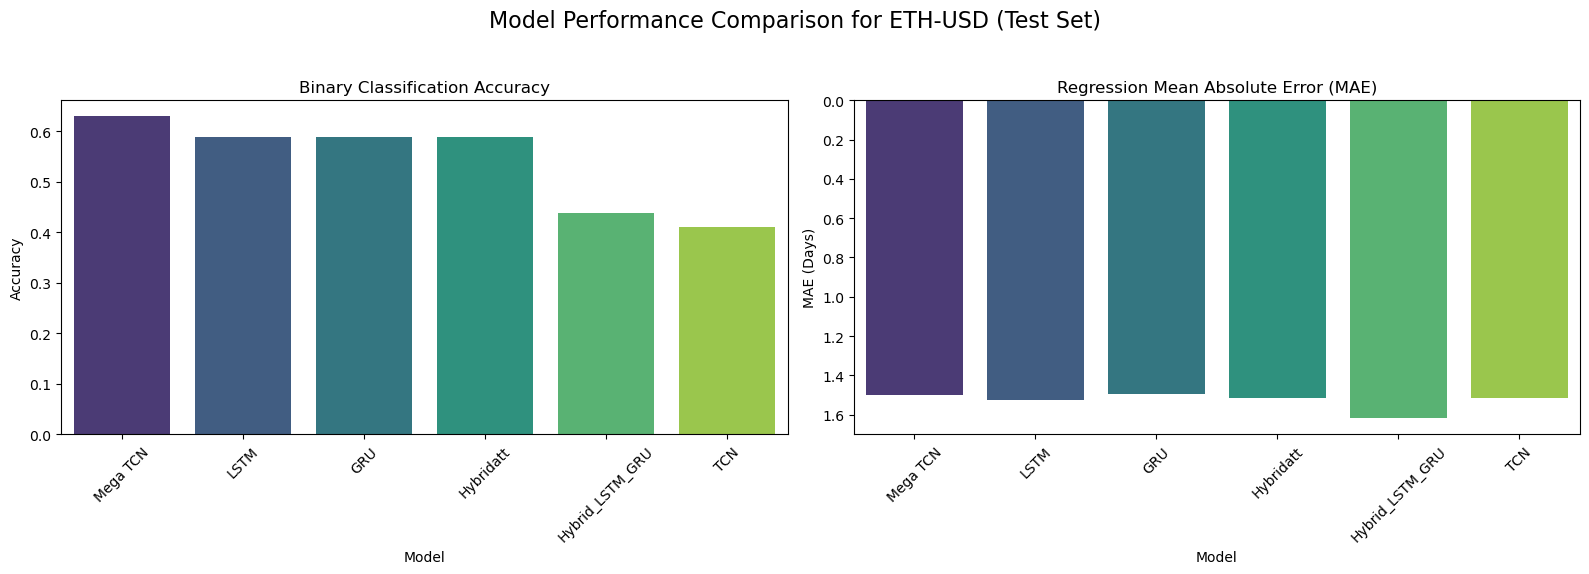


--- Performance Comparison Plots Generated ---


In [378]:
## Compare Model Performance Graphically

if 'results_summary_df' in locals() and not results_summary_df.empty:
    print("\n--- Plotting Model Performance Comparisons ---")

    # Example: Compare Binary Accuracy and Regression MAE for ETH-USD
    if 'ETH-USD' in results_summary_df['Symbol'].unique():
        eth_results = results_summary_df[results_summary_df['Symbol'] == 'ETH-USD'].sort_values('Binary_Accuracy', ascending=False)

        if not eth_results.empty:
            fig, axes = plt.subplots(1, 2, figsize=(16, 6))
            fig.suptitle(f'Model Performance Comparison for ETH-USD (Test Set)', fontsize=16)

            # Plot Binary Accuracy
            sns.barplot(x='Model', y='Binary_Accuracy', data=eth_results, ax=axes[0], palette='viridis')
            axes[0].set_title('Binary Classification Accuracy')
            axes[0].set_ylabel('Accuracy')
            axes[0].tick_params(axis='x', rotation=45) # Rotate labels if needed

            # Plot Regression MAE
            sns.barplot(x='Model', y='Regression_MAE', data=eth_results, ax=axes[1], palette='viridis')
            axes[1].set_title('Regression Mean Absolute Error (MAE)')
            axes[1].set_ylabel('MAE (Days)')
            axes[1].tick_params(axis='x', rotation=45) # Rotate labels if needed
            axes[1].invert_yaxis() # Lower MAE is better, so invert axis

            plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to make space for suptitle
            plt.show()

        else:
              print("No evaluation results available for ETH-USD to plot.")

    else:
          print("ETH-USD not found in the summary results DataFrame.")

    # Add more plots here for other symbols or different metrics as needed
    # Example: Compare MAE across symbols for a specific model type ('LSTM')
    # lstm_mae_comparison = results_summary_df[results_summary_df['Model'] == 'LSTM'].sort_values('Regression_MAE')
    # if not lstm_mae_comparison.empty:
    #     plt.figure(figsize=(10, 6))
    #     sns.barplot(x='Symbol', y='Regression_MAE', data=lstm_mae_comparison, palette='plasma')
    #     plt.title('LSTM Regression MAE Across Symbols')
    #     plt.ylabel('MAE (Days)')
    #     plt.show()


    print("\n--- Performance Comparison Plots Generated ---")
else:
    print("Summary DataFrame not available or empty, skipping plotting.")

**Deep Dive (*Splash*) into Classification Reports on Test**

In [379]:
## Inspect Specific Classification Reports

print("\n--- Inspecting Specific Classification Reports ---")
symbol_to_inspect = 'ETH-USD'
models_to_inspect = model_builders.keys() # Get all model names from model_types

for model_to_inspect in models_to_inspect:
  if symbol_to_inspect in final_test_results and model_to_inspect in final_test_results[symbol_to_inspect]:
      report_str = final_test_results[symbol_to_inspect][model_to_inspect].get('binary_classification_report')
      if report_str:
          print(f"Classification Report for {model_to_inspect} on {symbol_to_inspect}:")
          print(report_str)
      else:
          print(f"Classification report not found for {model_to_inspect} on {symbol_to_inspect}.")
  else:
      print(f"Results for {model_to_inspect} on {symbol_to_inspect} not found.")

  print("\n--- Inspection Complete ---")


--- Inspecting Specific Classification Reports ---
Classification Report for LSTM on ETH-USD:
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        30
         1.0       0.59      1.00      0.74        43

    accuracy                           0.59        73
   macro avg       0.29      0.50      0.37        73
weighted avg       0.35      0.59      0.44        73


--- Inspection Complete ---
Classification Report for GRU on ETH-USD:
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        30
         1.0       0.59      1.00      0.74        43

    accuracy                           0.59        73
   macro avg       0.29      0.50      0.37        73
weighted avg       0.35      0.59      0.44        73


--- Inspection Complete ---
Classification Report for Hybrid_LSTM_GRU on ETH-USD:
              precision    recall  f1-score   support

         0.0       0.36      0.47      0.4

# Get-method for Model Outputs

In [380]:
## Get Model Outputs (Predictions)
def get_model_outputs(target_model_name, target_symbol):
    """
    Retrieves a trained model and makes binary class and regression predictions.

    Args:
        target_model_name (str): The name of the trained model to use.
        target_symbol (str): The cryptocurrency symbol for which the model was trained.

    Returns:
        tuple: A tuple containing two numpy arrays:
               - binary_predictions_classes (predicted classes 0 or 1)
               - regression_predictions (predicted days)
               Returns (None, None) if the model or data is not found.
    """
    # Check if the trained model exists
    if target_symbol in all_trained_models and target_model_name in all_trained_models[target_symbol]:
        # Get the trained model object
        model_to_use = all_trained_models[target_symbol][target_model_name]

        # Get the corresponding input data (using validation data as an example)
        if target_symbol in all_symbols_modeling_data:
            data_for_prediction = all_symbols_modeling_data[target_symbol]
            # Using validation data - replace with 'X_test_seq' for test set predictions
            X_data_for_prediction = data_for_prediction.get('X_val_seq')

            # Check if data for prediction exists and is not empty
            if X_data_for_prediction is not None and X_data_for_prediction.size > 0:
                print(f"Making predictions using model '{target_model_name}' for '{target_symbol}'...")

                # Use the predict method of the model
                # Since the model has two outputs, predict returns a list of arrays
                predictions = model_to_use.predict(X_data_for_prediction, verbose=0)

                # 'predictions' is a list: [binary_output_predictions, regression_output_predictions]
                binary_predictions_proba = predictions[0] # Probabilities for binary classification
                regression_predictions = predictions[1] # Predicted days (regression)

                print("Prediction successful.")
                print("Binary output probabilities shape:", binary_predictions_proba.shape)
                print("Regression output predictions shape:", regression_predictions.shape)

                # Convert binary probabilities to classes (0 or 1)
                binary_predictions_classes = (binary_predictions_proba > 0.5).astype(int).flatten()
                regression_predictions_flat = regression_predictions.flatten()

                # Return the predictions
                return binary_predictions_classes, regression_predictions_flat

            else:
                print(f"No sequential data available for prediction for symbol '{target_symbol}'.")
                return None, None

        else:
            print(f"Modeling data not found for symbol '{target_symbol}'. Cannot get data for prediction.")
            return None, None

    else:
        print(f"Trained model '{target_model_name}' not found for symbol '{target_symbol}'.")
        return None, None



In [381]:

binary_preds, regression_preds = get_model_outputs('Mega TCN', 'ETH-USD')

if binary_preds is not None and regression_preds is not None:
    print("\nReturned Binary Predictions (first 10):", binary_preds[:10])
    print("Returned Regression Predictions (first 10):", regression_preds[:10])

Making predictions using model 'Mega TCN' for 'ETH-USD'...
Prediction successful.
Binary output probabilities shape: (113, 1)
Regression output predictions shape: (113, 1)

Returned Binary Predictions (first 10): [0 0 0 0 0 0 0 0 0 0]
Returned Regression Predictions (first 10): [3.9143996 3.916264  3.9157567 3.917456  3.9181376 3.917584  3.9187717
 3.919411  3.9201207 3.920397 ]


In [382]:
import numpy as np
import pandas as pd

# Initialize an empty dictionary to store model outputs keyed by symbol and model name
model_predictions_dict = {}

# Assume 'all_trained_models', 'symbols_to_process', and 'all_symbols_modeling_data' are already defined
# and populated from the preceding code.
# Assume the 'prepare_test_data' function is defined and available.

print("\n--- Retrieving and Storing Model Predictions on Test Set ---")

# Loop through each symbol that was processed
for symbol in symbols_to_process:
    print(f"\nProcessing predictions for Symbol: {symbol}")

    # Get the processed test data and modeling data for the current symbol
    test_df_processed = all_symbols_processed_dfs_for_eda.get(symbol, {}).get('test')
    symbol_modeling_data = all_symbols_modeling_data.get(symbol, {})

    # Check if test data and modeling data are available
    if test_df_processed is None or test_df_processed.empty or not symbol_modeling_data:
        print(f"  Skipping {symbol}: Missing processed test dataframe or modeling data.")
        continue

    # Prepare the test data sequences (features and targets)
    scaler = symbol_modeling_data.get('scaler')
    numeric_features = symbol_modeling_data.get('numeric_features')
    time_steps = symbol_modeling_data.get('time_steps')
    target_cols = TARGET_COLS_FINAL # Assuming TARGET_COLS_FINAL is defined globally

    X_test_seq, y_test_bin_seq, y_test_reg_seq = prepare_test_data(
        test_df_processed, scaler, numeric_features, time_steps, target_cols
    )

    # Check if test sequences were successfully created
    if X_test_seq is None or X_test_seq.size == 0:
        print(f"  Skipping models for {symbol}: Test data preparation failed or resulted in empty sequences.")
        continue

    # Store the true test targets for later comparison/dataframe creation
    # Align true targets with the sequences (they start 'time_steps' days later)
    # Find the corresponding dates for the sequences
    test_dates_for_sequences = test_df_processed[DATE_COL].iloc[time_steps:].reset_index(drop=True)
    test_lows_for_sequences = test_df_processed[LOW_COL].iloc[time_steps:].reset_index(drop=True) # Might be useful
    test_closes_for_sequences = test_df_processed[CLOSE_COL].iloc[time_steps:].reset_index(drop=True) # Might be useful


    # Add the true targets to the dictionary keyed by symbol
    if symbol not in model_predictions_dict:
         model_predictions_dict[symbol] = {}
    model_predictions_dict[symbol]['True_Binary'] = y_test_bin_seq
    model_predictions_dict[symbol]['True_Regression'] = y_test_reg_seq
    model_predictions_dict[symbol]['Dates'] = test_dates_for_sequences
    model_predictions_dict[symbol]['Lows'] = test_lows_for_sequences
    model_predictions_dict[symbol]['Closes'] = test_closes_for_sequences


    # Loop through each trained model for the current symbol
    if symbol in all_trained_models:
        for model_name, trained_model in all_trained_models[symbol].items():
            print(f"  Making predictions with model: {model_name}")

            try:
                # Make predictions using the trained model on the test sequences
                predictions = trained_model.predict(X_test_seq, verbose=0)

                # Assuming the order of outputs is [binary, regression]
                if isinstance(predictions, list) and len(predictions) >= 2:
                     binary_preds_proba = predictions[0]
                     regression_preds = predictions[1]

                     # Convert binary probabilities to class predictions (0 or 1)
                     if binary_preds_proba.ndim > 1 and binary_preds_proba.shape[-1] == 2:
                         binary_preds_classes = (binary_preds_proba[:, 1] > 0.5).astype(int) # Probabilities for class 1
                     elif binary_preds_proba.ndim > 1 and binary_preds_proba.shape[-1] == 1:
                         binary_preds_classes = (binary_preds_proba.flatten() > 0.5).astype(int) # Flatten sigmoid output
                     else: # Assume it's already a flattened array of probabilities
                         binary_preds_classes = (binary_preds_proba > 0.5).astype(int)


                     regression_preds_flat = regression_preds.flatten()

                     # Store the predictions in the dictionary
                     model_predictions_dict[symbol][f'{model_name}_Binary_Pred'] = binary_preds_classes
                     model_predictions_dict[symbol][f'{model_name}_Regr_Pred'] = regression_preds_flat
                     print(f"    Predictions for {model_name} stored.")

                else:
                     print(f"    Warning: Unexpected prediction output shape for model {model_name}. Skipping storage.")
                     print(f"    Output type: {type(predictions)}, Length: {len(predictions) if isinstance(predictions, (list, tuple)) else 'N/A'}")


            except Exception as e:
                print(f"  Error during prediction for model {model_name} on {symbol}: {e}")
                model_predictions_dict[symbol][f'{model_name}_Binary_Pred'] = np.nan # Store NaN on error
                model_predictions_dict[symbol][f'{model_name}_Regr_Pred'] = np.nan # Store NaN on error


    else:
        print(f"  No trained models found for symbol: {symbol}")


# --- Create and Save the DataFrame ---
print("\n--- Creating and Saving DataFrame of Predictions ---")

all_predictions_df_list = []

for symbol, data in model_predictions_dict.items():
    # Create a DataFrame for the current symbol's predictions
    # Ensure all arrays/series have the same length before creating DataFrame
    df_symbol_predictions = pd.DataFrame({
        DATE_COL: data.get('Dates'),
        SYMBOL_COL: symbol, # Add symbol column
        LOW_COL: data.get('Lows'), # Add original Lows if desired
        CLOSE_COL: data.get('Closes'), # Add original Closes if desired
        'True_Binary_Target': data.get('True_Binary'),
        'True_Regression_Target': data.get('True_Regression'),
    })

    # Add model predictions, ensuring column existence checks
    for key, value in data.items():
        if key.endswith('_Pred'):
             # Check if the length of the prediction array matches the length of the base DataFrame
             if value is not None and isinstance(value, np.ndarray) and len(value) == len(df_symbol_predictions):
                 df_symbol_predictions[key] = value
             else:
                 # If lengths don't match or value is invalid, fill with NaN
                 print(f"Warning: Prediction array length mismatch for {key} in {symbol}. Filling with NaN.")
                 df_symbol_predictions[key] = np.nan

    # Append the symbol's DataFrame to the list
    if not df_symbol_predictions.empty:
        all_predictions_df_list.append(df_symbol_predictions)
    else:
        print(f"Warning: Empty DataFrame created for symbol {symbol}. Not adding to list.")


# Concatenate all DataFrames into one final DataFrame
if all_predictions_df_list:
    final_predictions_df = pd.concat(all_predictions_df_list, ignore_index=True)
    print("\nFinal DataFrame created.")
    print("Shape:", final_predictions_df.shape)
    print("Columns:", final_predictions_df.columns.tolist())
    # Display the first few rows
    print("\nFirst 5 rows of the final DataFrame:")
    display(final_predictions_df.head())


    # Save the DataFrame to a CSV file
    csv_filename = 'model_predictions_on_test_data.csv'
    try:
        final_predictions_df.to_csv(csv_filename, index=False)
        print(f"\nDataFrame saved to '{csv_filename}' successfully.")

        # Optional: Download the file if running in Colab
        try:
            from google.colab import files
            files.download(csv_filename)
            print(f"File '{csv_filename}' downloaded.")
        except ImportError:
            print("Running outside Colab. File not automatically downloaded.")


    except Exception as e:
        print(f"Error saving DataFrame to CSV: {e}")

else:
    print("\nNo data available to create a final predictions DataFrame.")
    final_predictions_df = pd.DataFrame() # Ensure df exists even if empty

print("\n--- Process Complete ---")


--- Retrieving and Storing Model Predictions on Test Set ---

Processing predictions for Symbol: ETH-USD
Prepare Test Data: Test sequences created. Shape: (73, 10, 152)
  Making predictions with model: LSTM
    Predictions for LSTM stored.
  Making predictions with model: GRU
    Predictions for GRU stored.
  Making predictions with model: Hybrid_LSTM_GRU
    Predictions for Hybrid_LSTM_GRU stored.
  Making predictions with model: TCN
    Predictions for TCN stored.
  Making predictions with model: Mega TCN
    Predictions for Mega TCN stored.
  Making predictions with model: Hybridatt
    Predictions for Hybridatt stored.

--- Creating and Saving DataFrame of Predictions ---

Final DataFrame created.
Shape: (73, 18)
Columns: ['dates', 'symbol', 'low', 'close', 'True_Binary_Target', 'True_Regression_Target', 'LSTM_Binary_Pred', 'LSTM_Regr_Pred', 'GRU_Binary_Pred', 'GRU_Regr_Pred', 'Hybrid_LSTM_GRU_Binary_Pred', 'Hybrid_LSTM_GRU_Regr_Pred', 'TCN_Binary_Pred', 'TCN_Regr_Pred', 'Mega TCN

dates   symbol          low        close  True_Binary_Target  \
0 2024-10-28  ETH-USD  2470.268311  2565.348145                 0.0   
1 2024-10-29  ETH-USD  2560.153809  2637.957520                 1.0   
2 2024-10-30  ETH-USD  2600.609619  2657.372559                 1.0   
3 2024-10-31  ETH-USD  2501.572266  2515.799316                 0.0   
4 2024-11-01  ETH-USD  2467.819336  2511.885498                 0.0   

   True_Regression_Target  LSTM_Binary_Pred  LSTM_Regr_Pred  GRU_Binary_Pred  \
0                     6.0                 1        3.743485                1   
1                     6.0                 1        3.735867                1   
2                     5.0                 1        3.733157                1   
3                     4.0                 1        3.730151                1   
4                     3.0                 1        3.726752                1   

   GRU_Regr_Pred  Hybrid_LSTM_GRU_Binary_Pred  Hybrid_LSTM_GRU_Regr_Pred  \
0       3.954788                            0                   3.288242   
1       3.955577                            0                   3.073701   
2       3.954712                            0                   2.970210   
3       3.953507                            0                   2.828487   
4       3.952517                            0                   2.797051   

   TCN_Binary_Pred  TCN_Regr_Pred  Mega TCN_Binary_Pred  Mega TCN_Regr_Pred  \
0                0       3.812554                     1            3.904131   
1                0       3.812544                     0            3.917275   
2                0       3.812534                     0            3.922103   
3                0       3.812531                     0            3.921169   
4                0       3.812530                     0            3.926481   

   Hybridatt_Binary_Pred  Hybridatt_Regr_Pred  
0                      1             3.838757  
1                      1             3.838552  
2                      1             3.838408  
3                      1             3.837980  
4                      1             3.837689


DataFrame saved to 'model_predictions_on_test_data.csv' successfully.
Running outside Colab. File not automatically downloaded.

--- Process Complete ---




> Thought, we need to adjust the "True_Regression_Target" the values are too "dynamic". Due to the rolling window, it gets updated too often, such that the training on the values seems arbitrary. We could move by 10 days, then suddenly the rolling window find a smaller "min", then gets adjusted to target after that.



*   Suggestion 1: Have discrete window-periods, such as "the min price for a given month". Where the values are in range of [-15, 15]. Which could indicate whether we are coming towrds the min point or away from it.
** Issue 1: For a given discrete time window, there could be multible min values for the given percentile treshold.
** Fix to the issue: For a given discrete window, mark the "treshold-min-dates".

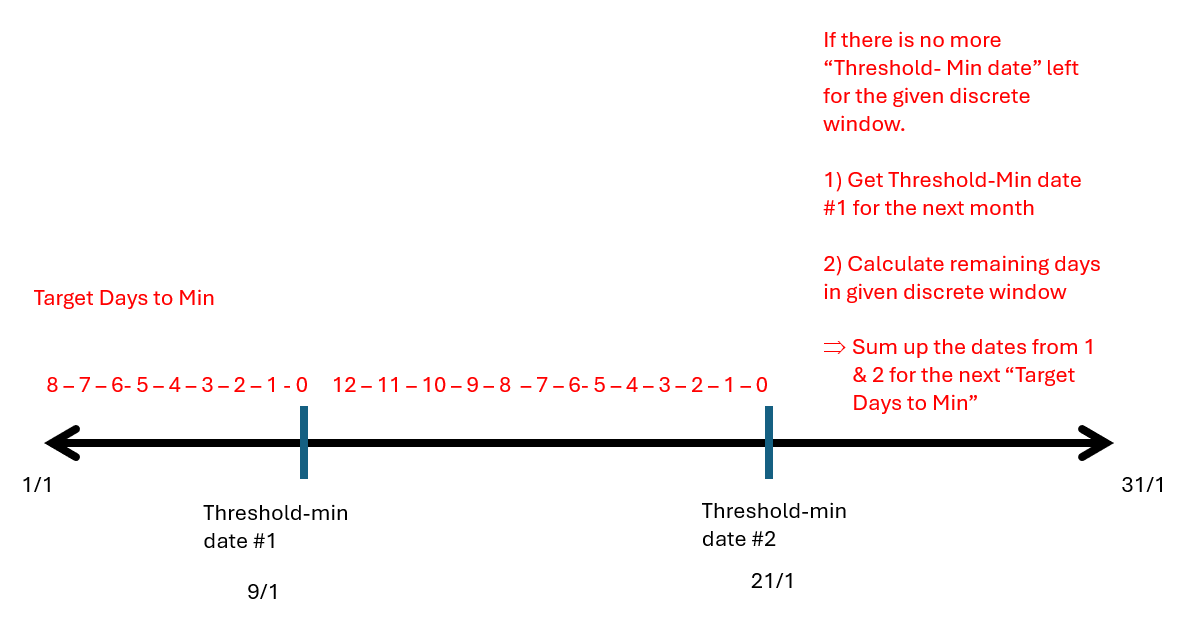

*   List item






--- Starting Final Model Evaluation on Test Data ---

--- Processing for Symbol: ETH-USD ---
Prepare Test Data: Test sequences created. Shape: (73, 10, 152)

--- Evaluating Model 'LSTM' for ETH-USD ---
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

Binary Target ('binary_target'):
Classification Report:
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        30
         1.0       0.59      1.00      0.74        43

    accuracy                           0.59        73
   macro avg       0.29      0.50      0.37        73
weighted avg       0.35      0.59      0.44        73



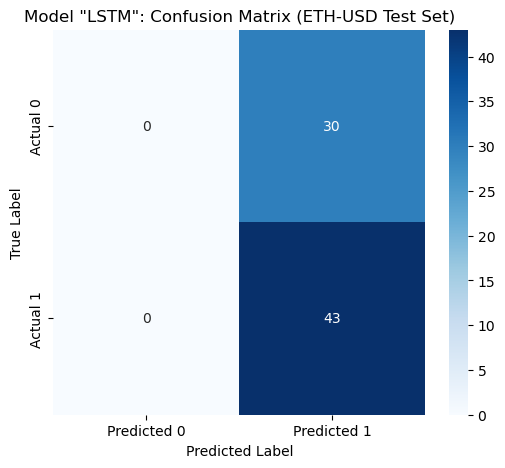

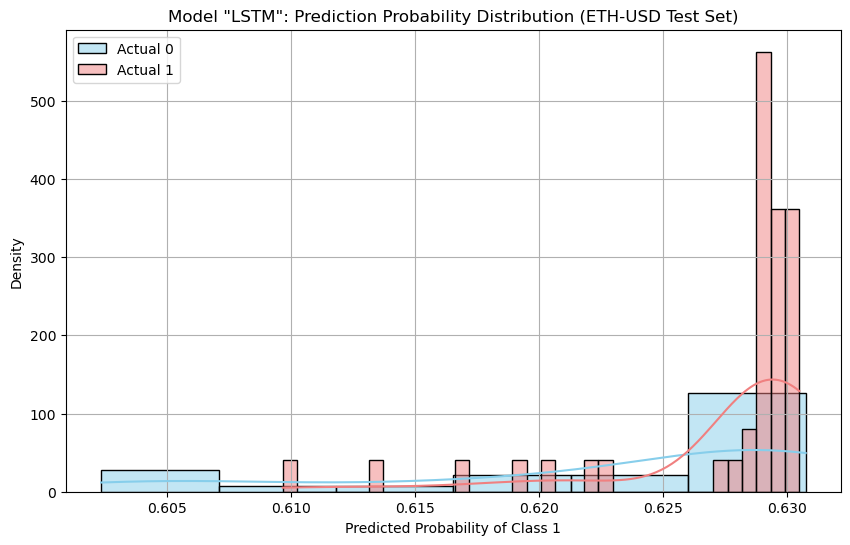

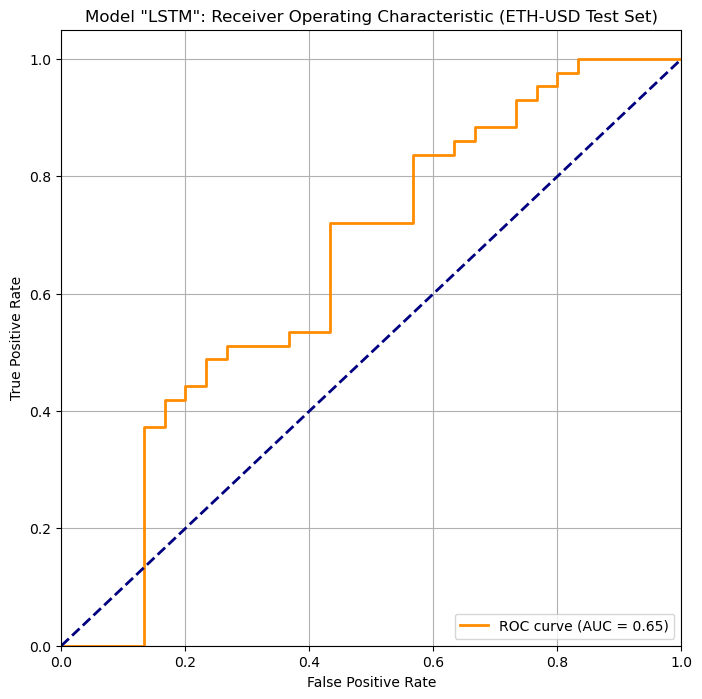


Regression Target ('days_to_future_min_7d'):
Mean Absolute Error (MAE): 1.5281
Root Mean Squared Error (RMSE): 1.7738
Mean Absolute Percentage Error (MAPE): 70.4178%


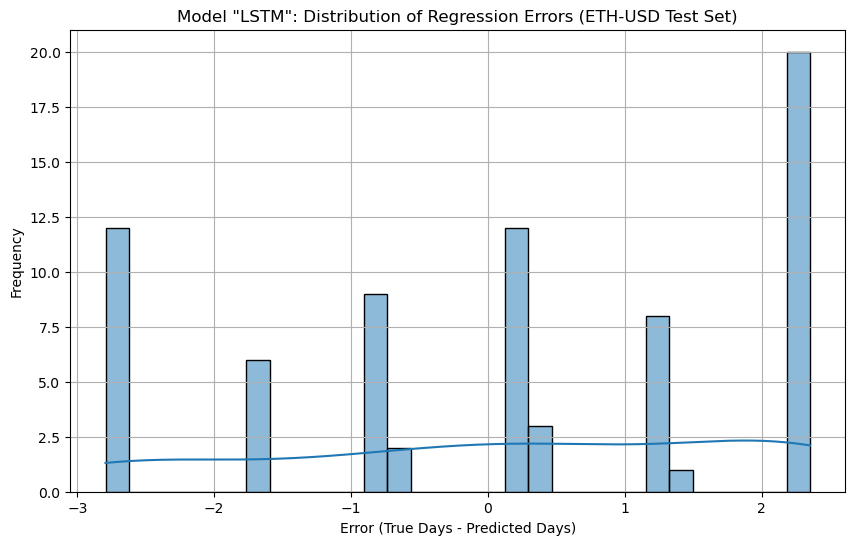

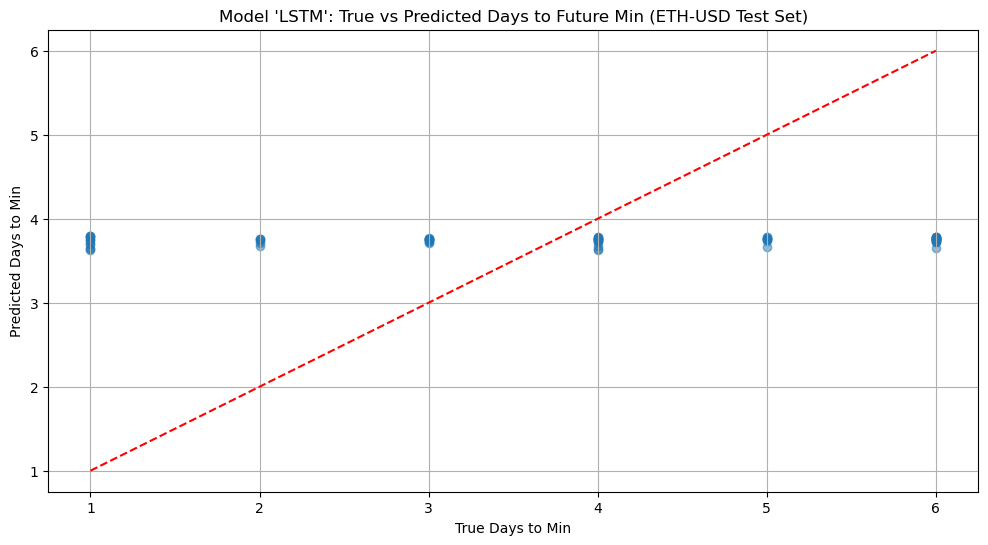

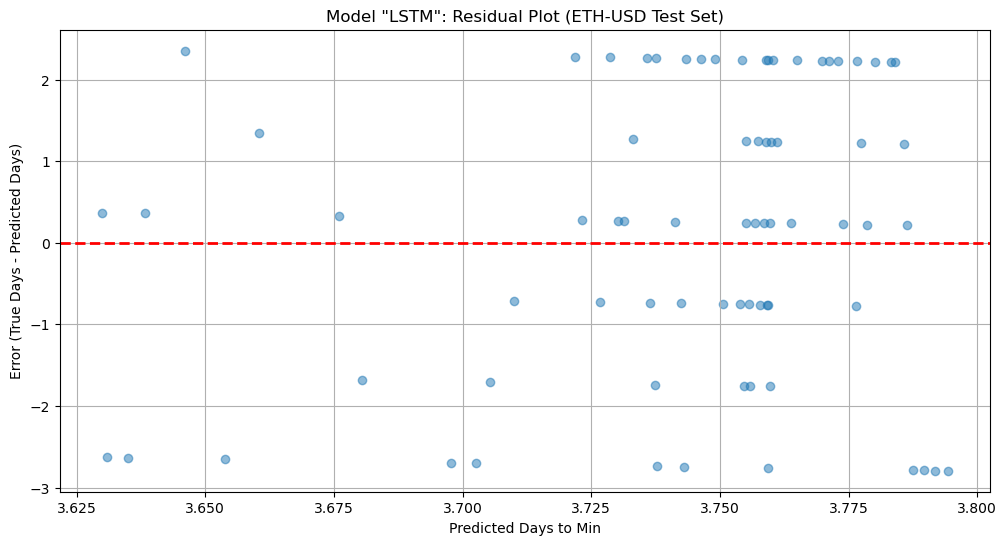


--- Evaluating Model 'GRU' for ETH-USD ---
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step

Binary Target ('binary_target'):
Classification Report:
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        30
         1.0       0.59      1.00      0.74        43

    accuracy                           0.59        73
   macro avg       0.29      0.50      0.37        73
weighted avg       0.35      0.59      0.44        73



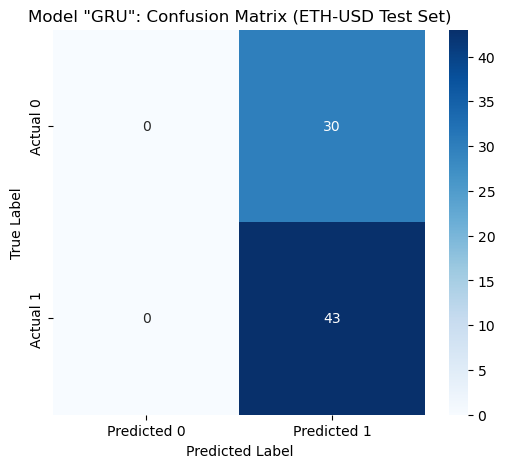

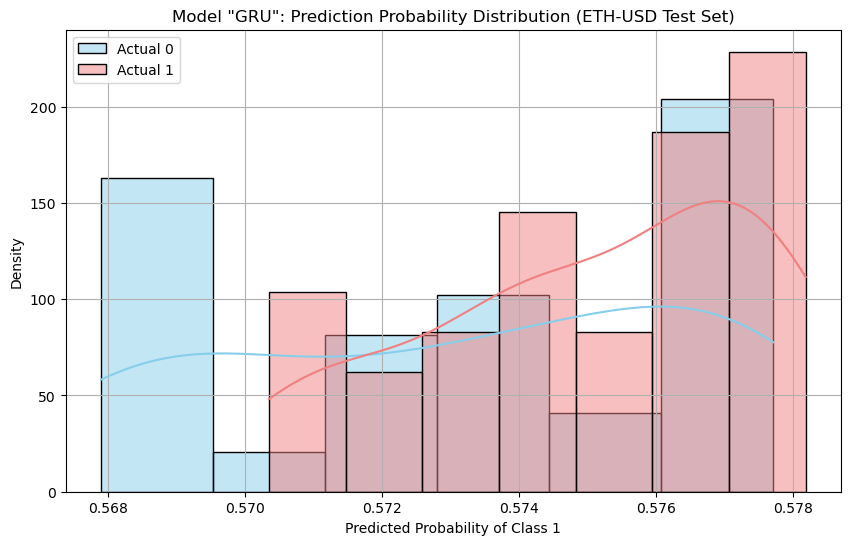

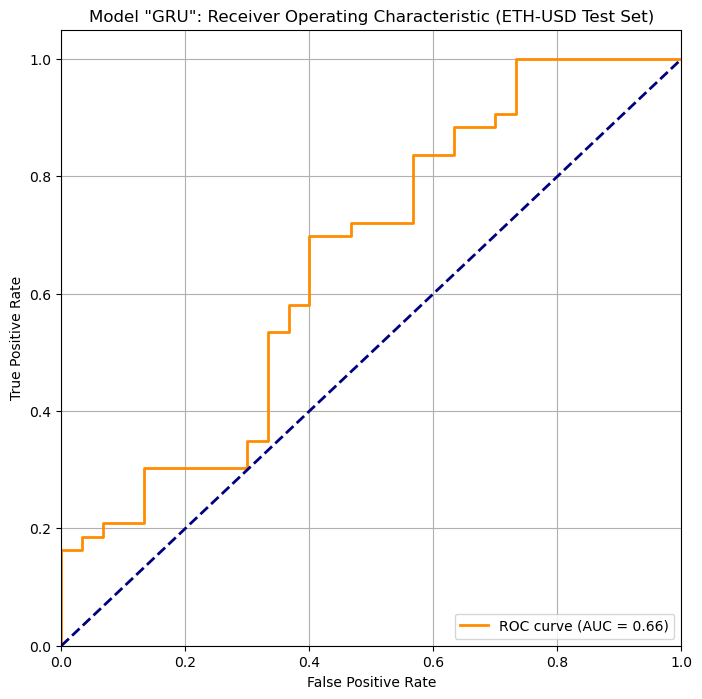


Regression Target ('days_to_future_min_7d'):
Mean Absolute Error (MAE): 1.4950
Root Mean Squared Error (RMSE): 1.7835
Mean Absolute Percentage Error (MAPE): 73.4972%


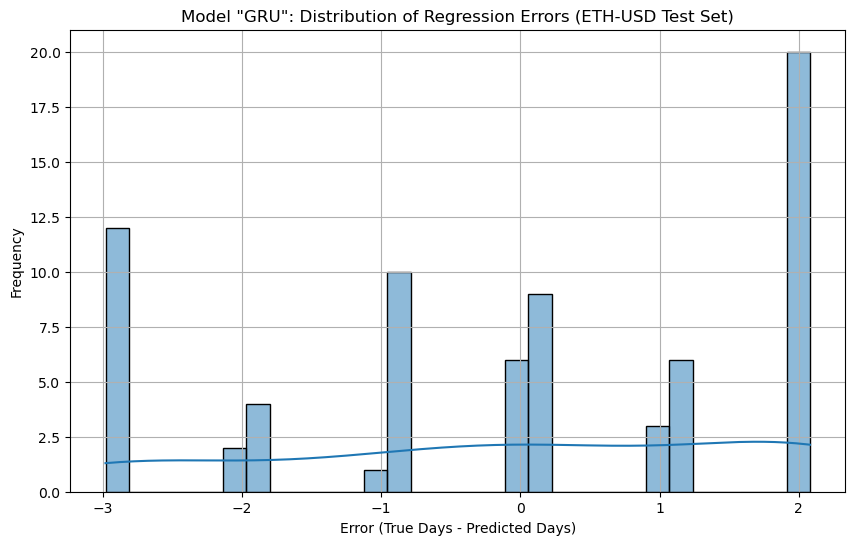

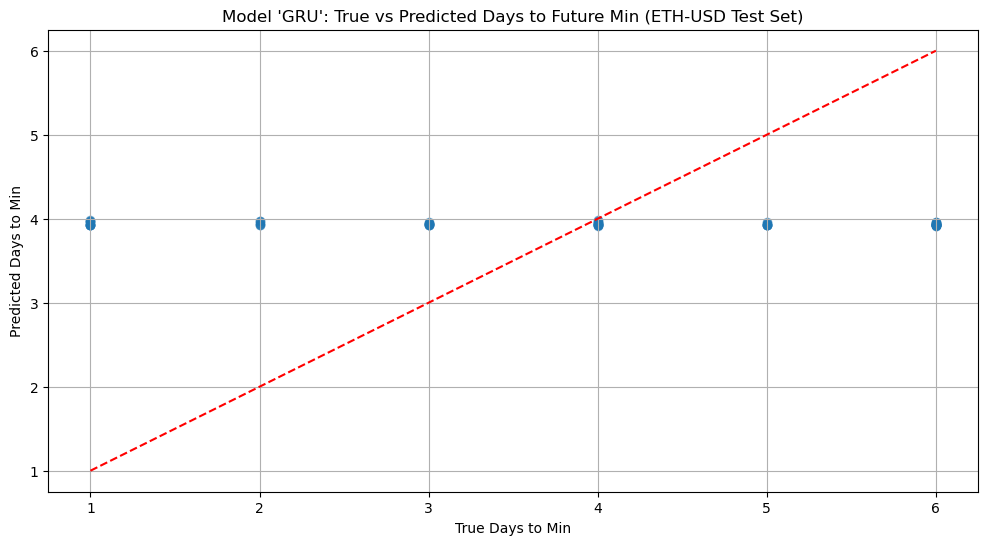

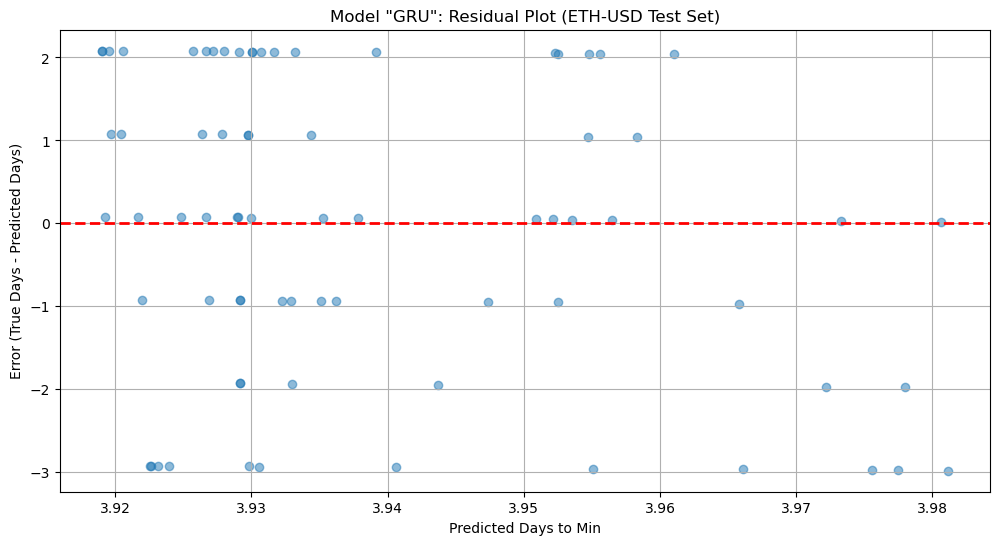


--- Evaluating Model 'Hybrid_LSTM_GRU' for ETH-USD ---
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

Binary Target ('binary_target'):
Classification Report:
              precision    recall  f1-score   support

         0.0       0.36      0.47      0.41        30
         1.0       0.53      0.42      0.47        43

    accuracy                           0.44        73
   macro avg       0.44      0.44      0.44        73
weighted avg       0.46      0.44      0.44        73



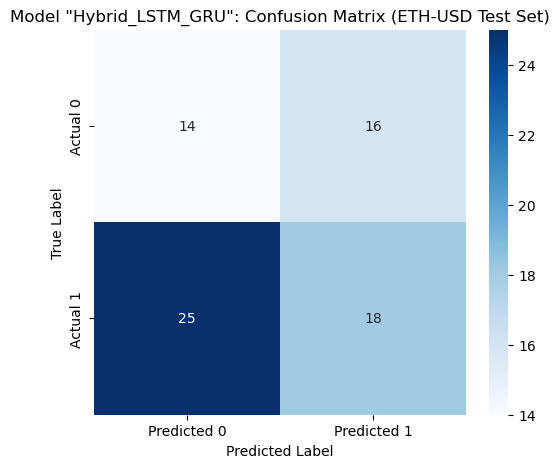

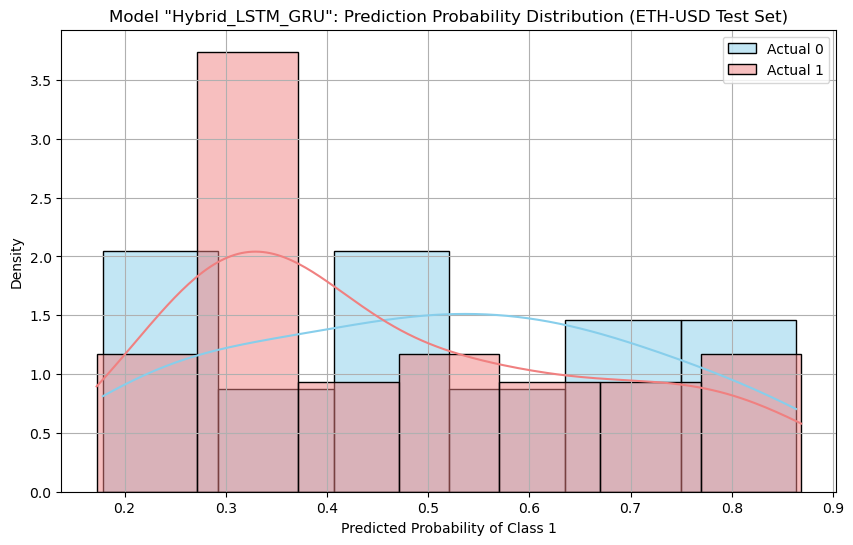

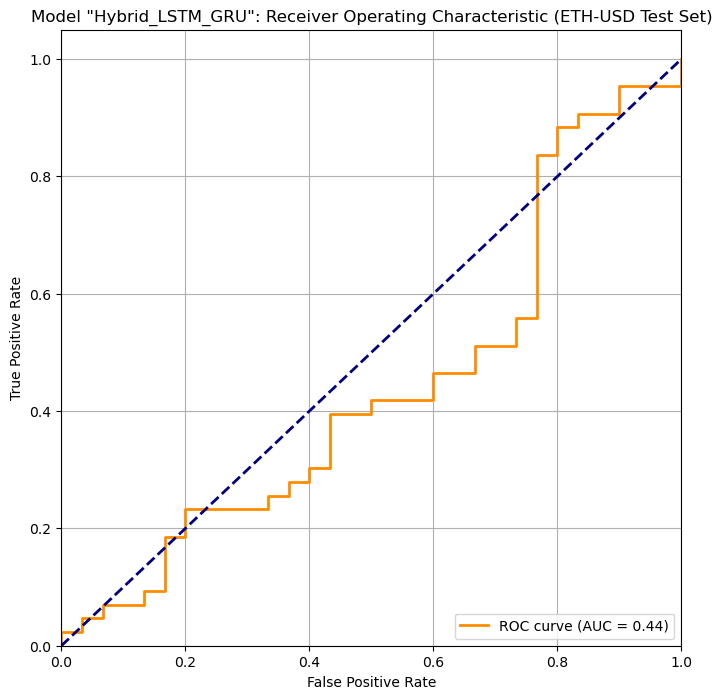


Regression Target ('days_to_future_min_7d'):
Mean Absolute Error (MAE): 1.6194
Root Mean Squared Error (RMSE): 1.9130
Mean Absolute Percentage Error (MAPE): 67.0879%


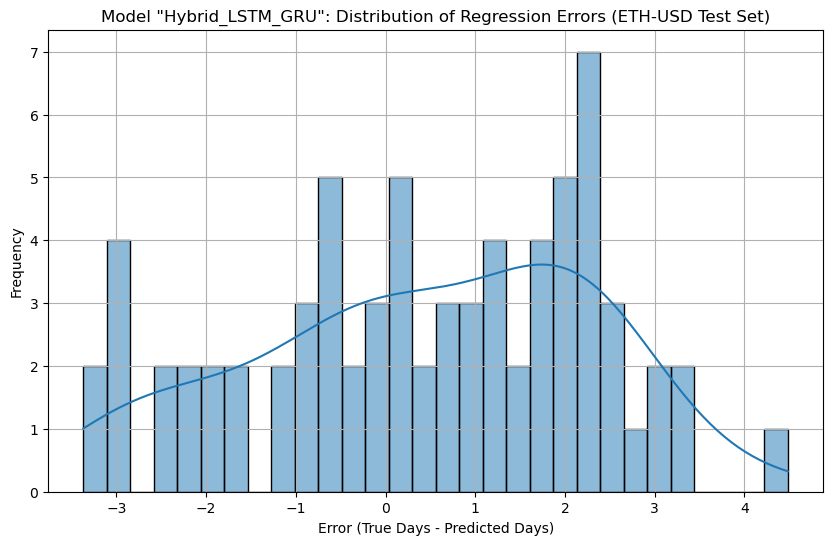

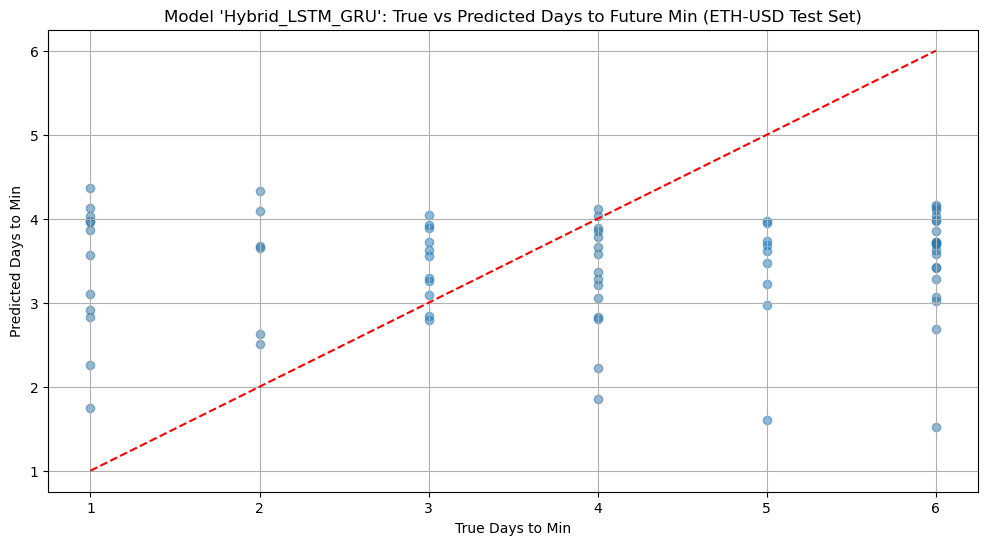

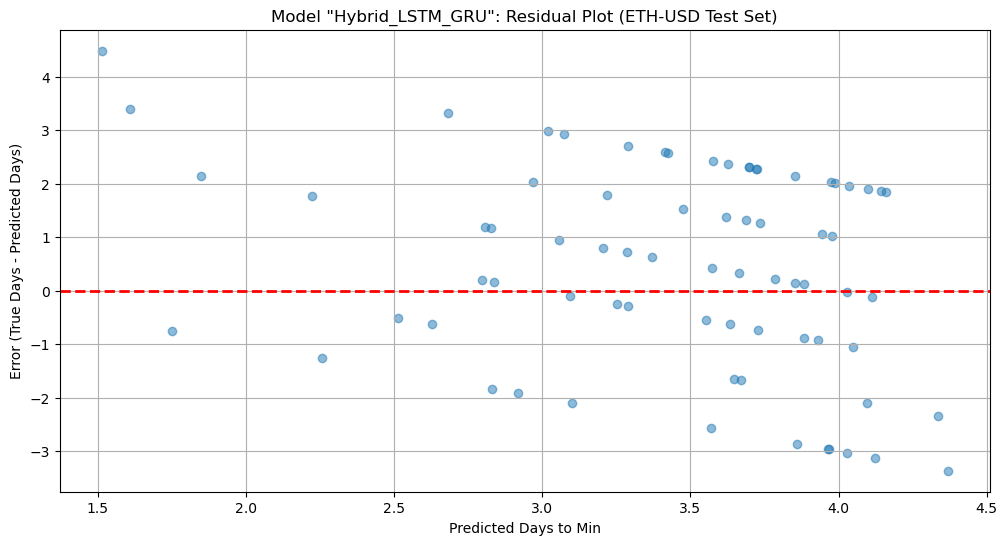


--- Evaluating Model 'TCN' for ETH-USD ---
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step

Binary Target ('binary_target'):
Classification Report:
              precision    recall  f1-score   support

         0.0       0.41      1.00      0.58        30
         1.0       0.00      0.00      0.00        43

    accuracy                           0.41        73
   macro avg       0.21      0.50      0.29        73
weighted avg       0.17      0.41      0.24        73



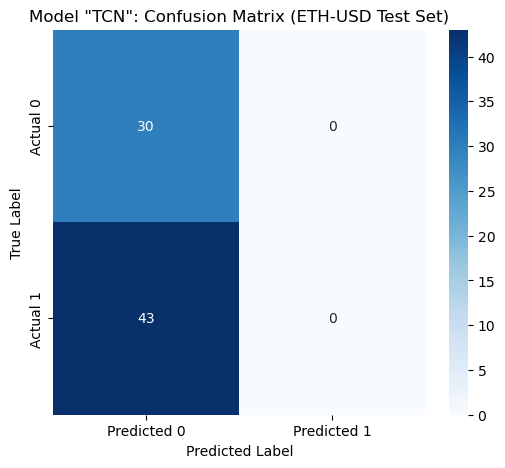

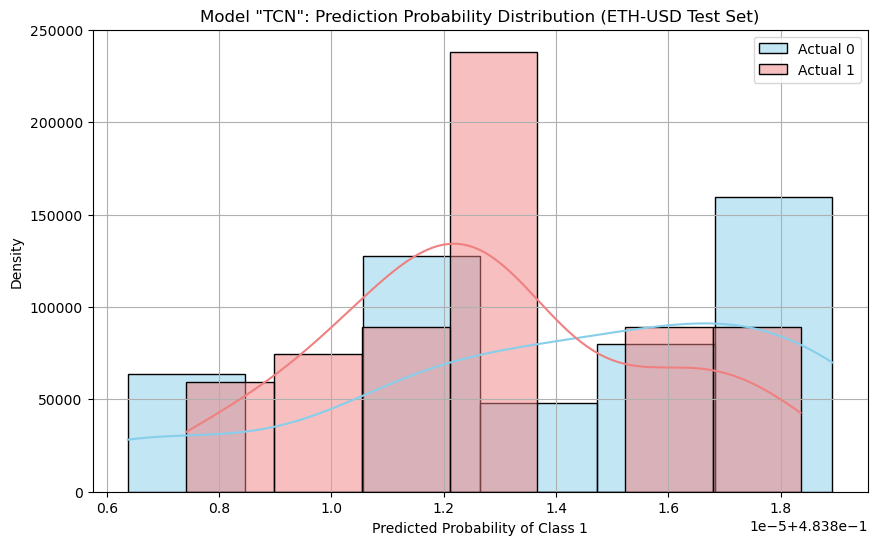

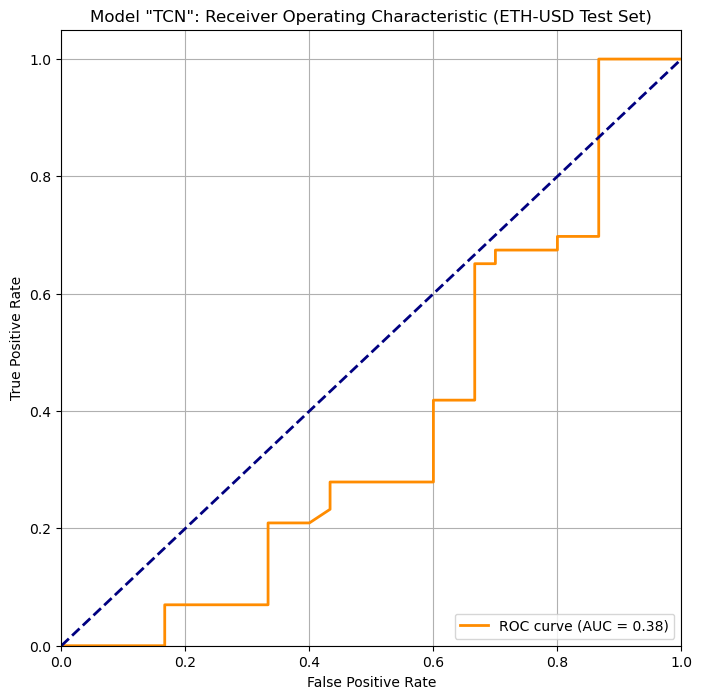


Regression Target ('days_to_future_min_7d'):
Mean Absolute Error (MAE): 1.5179
Root Mean Squared Error (RMSE): 1.7782
Mean Absolute Percentage Error (MAPE): 71.6435%


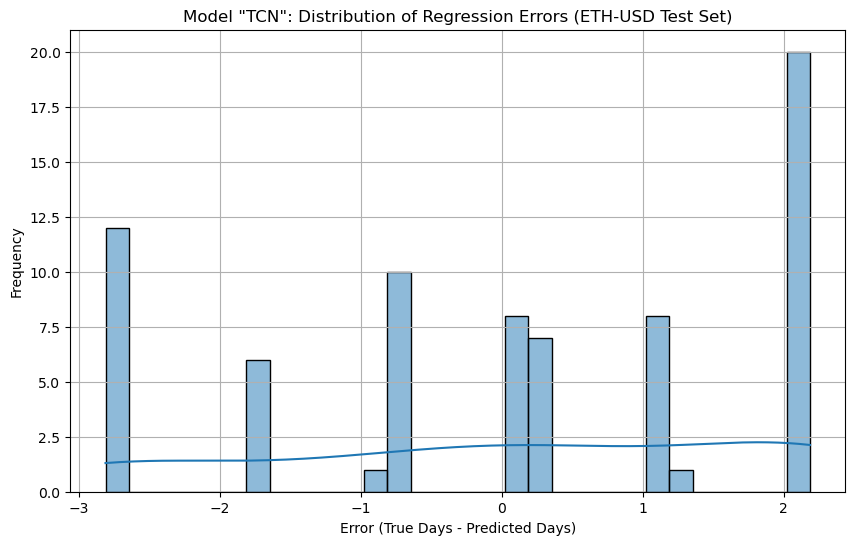

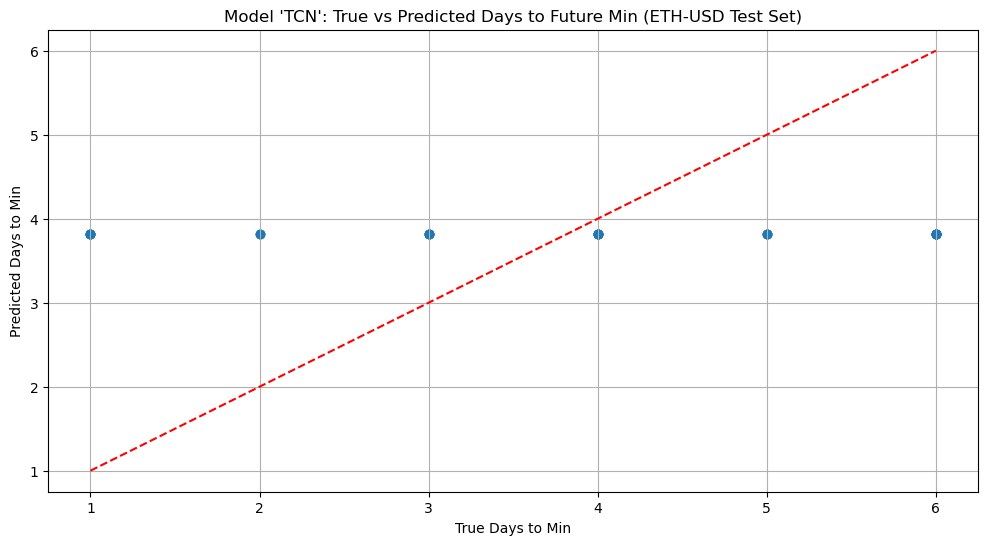

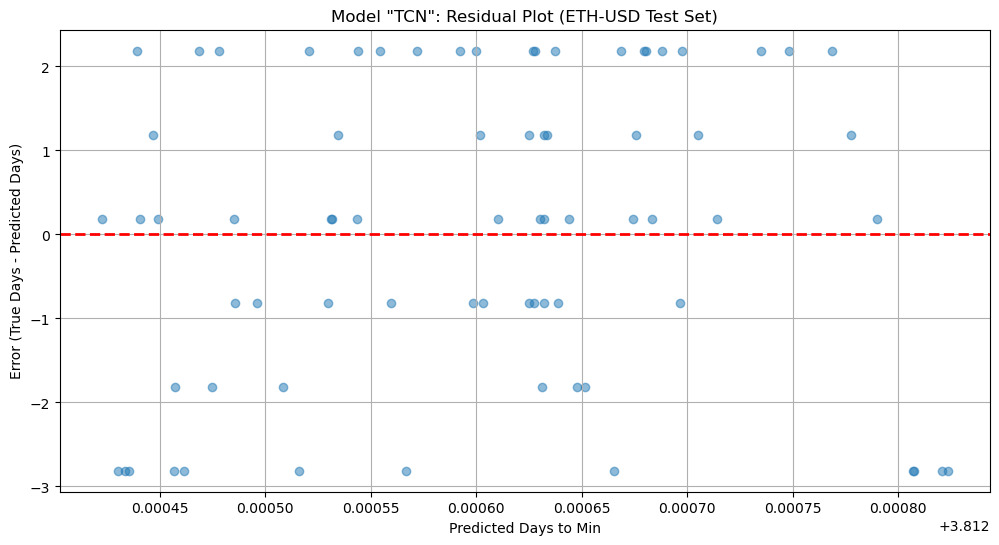


--- Evaluating Model 'Mega TCN' for ETH-USD ---
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step

Binary Target ('binary_target'):
Classification Report:
              precision    recall  f1-score   support

         0.0       0.64      0.23      0.34        30
         1.0       0.63      0.91      0.74        43

    accuracy                           0.63        73
   macro avg       0.63      0.57      0.54        73
weighted avg       0.63      0.63      0.58        73



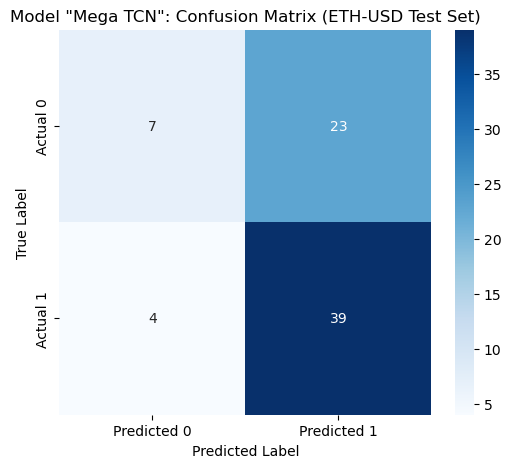

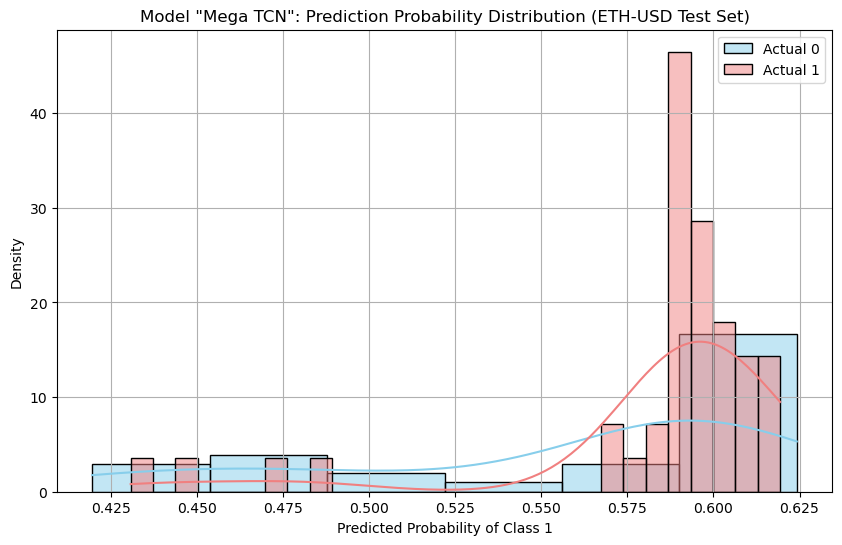

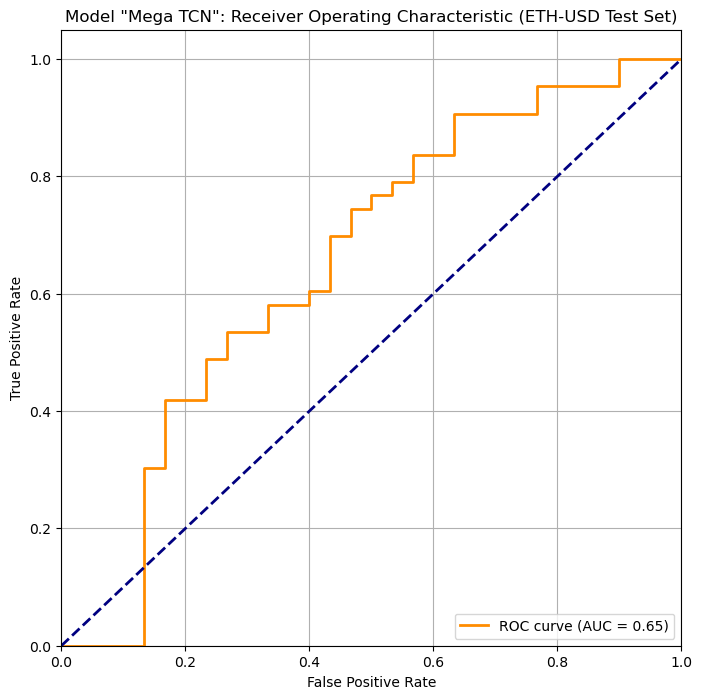


Regression Target ('days_to_future_min_7d'):
Mean Absolute Error (MAE): 1.5010
Root Mean Squared Error (RMSE): 1.7816
Mean Absolute Percentage Error (MAPE): 73.0990%


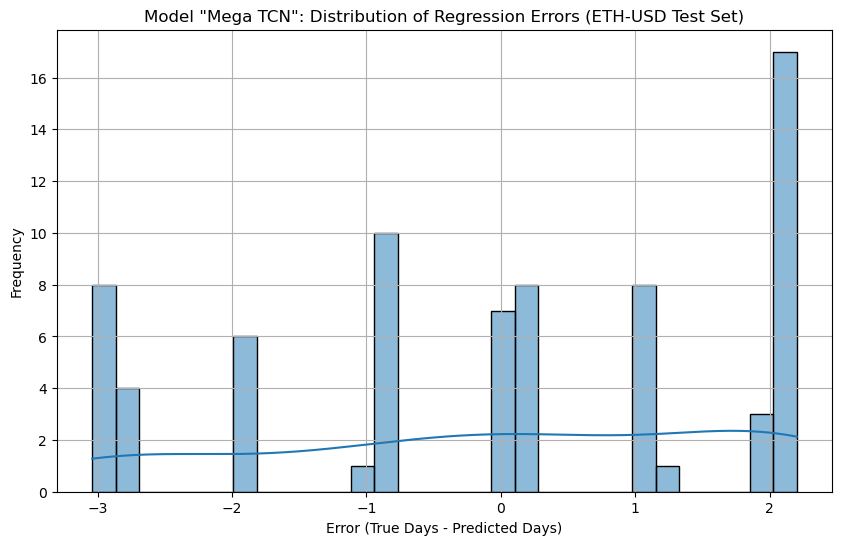

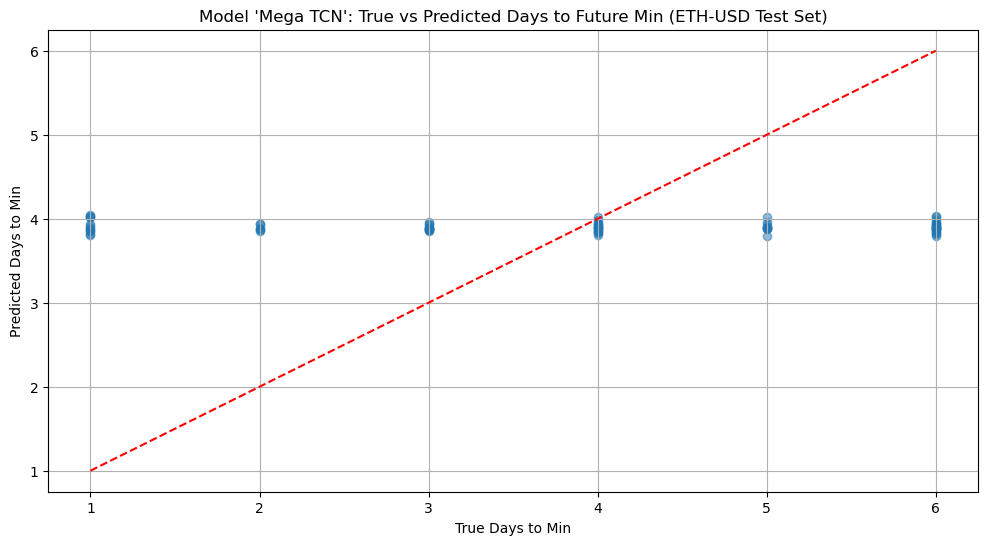

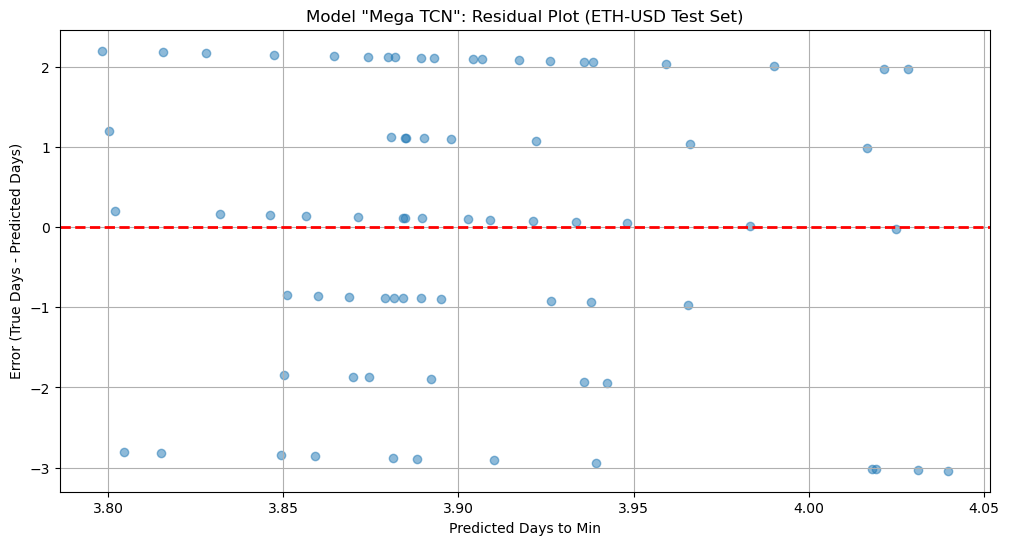


--- Evaluating Model 'Hybridatt' for ETH-USD ---
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

Binary Target ('binary_target'):
Classification Report:
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        30
         1.0       0.59      1.00      0.74        43

    accuracy                           0.59        73
   macro avg       0.29      0.50      0.37        73
weighted avg       0.35      0.59      0.44        73



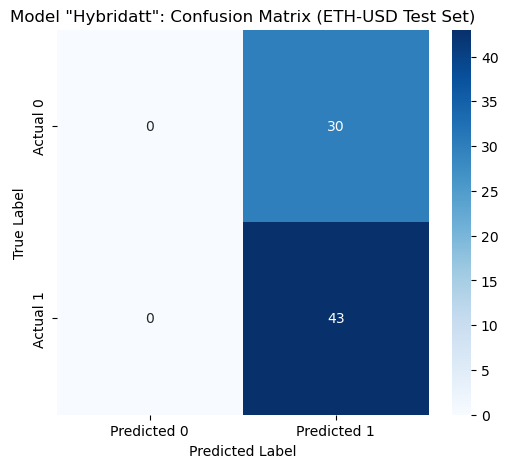

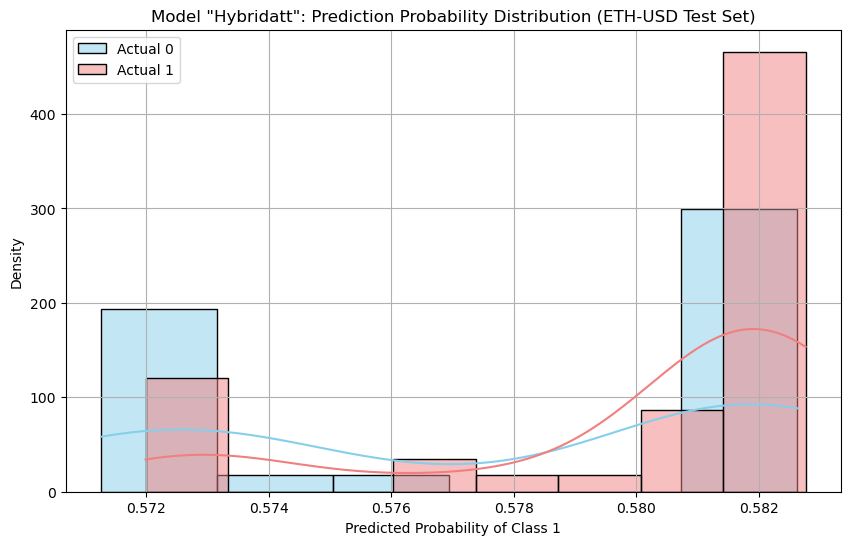

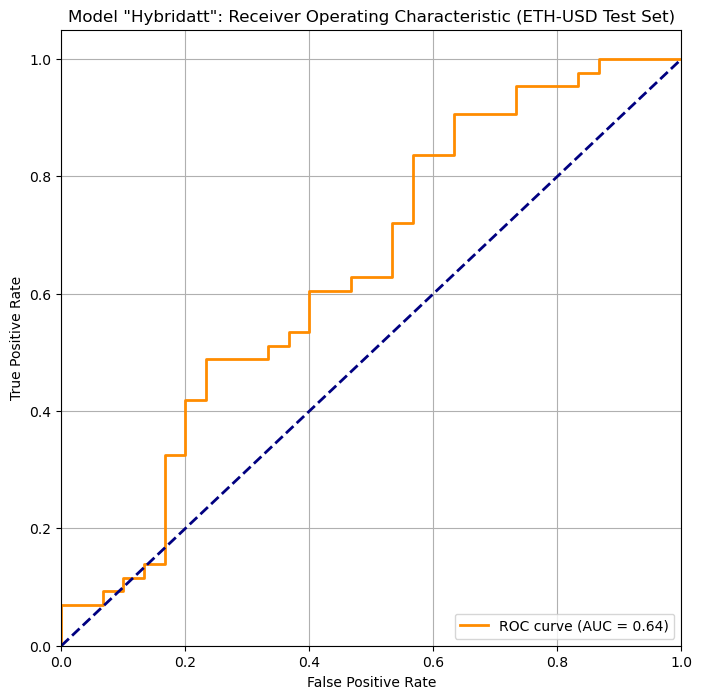


Regression Target ('days_to_future_min_7d'):
Mean Absolute Error (MAE): 1.5141
Root Mean Squared Error (RMSE): 1.7782
Mean Absolute Percentage Error (MAPE): 71.9285%


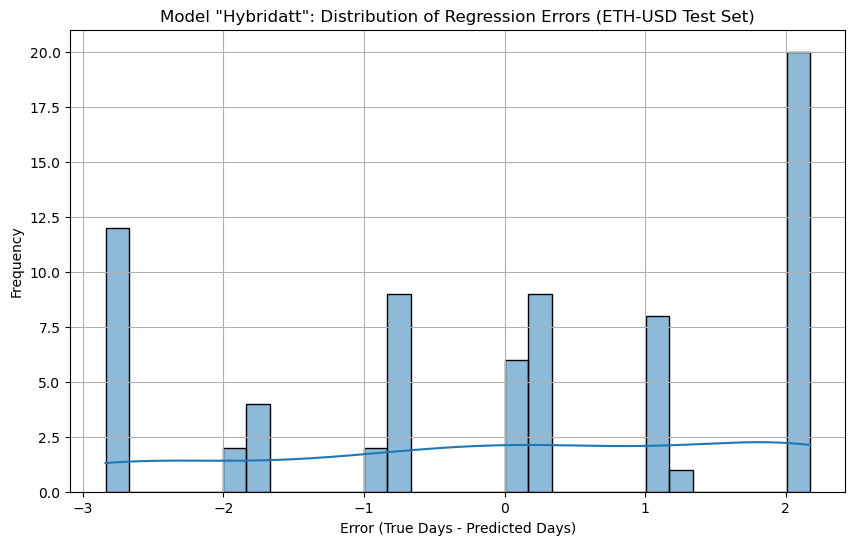

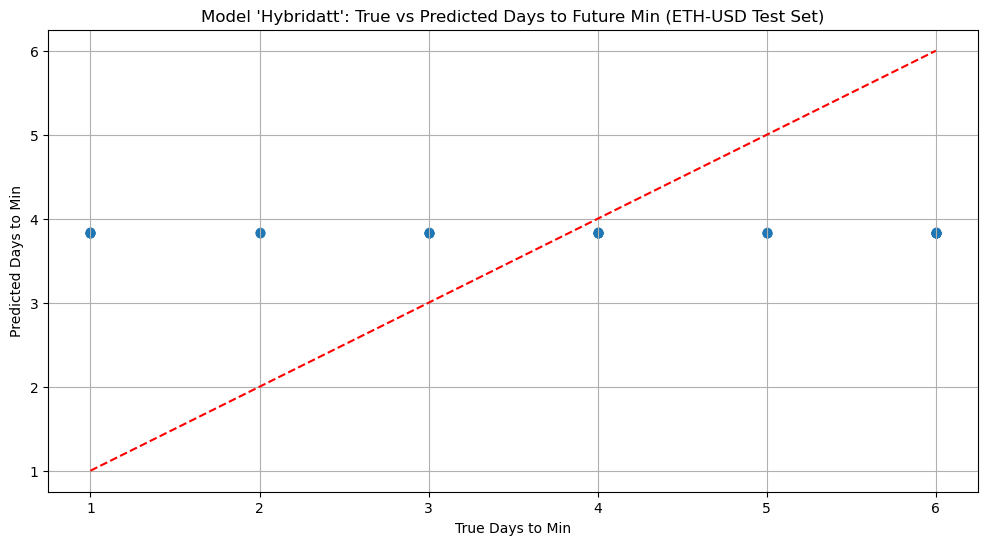

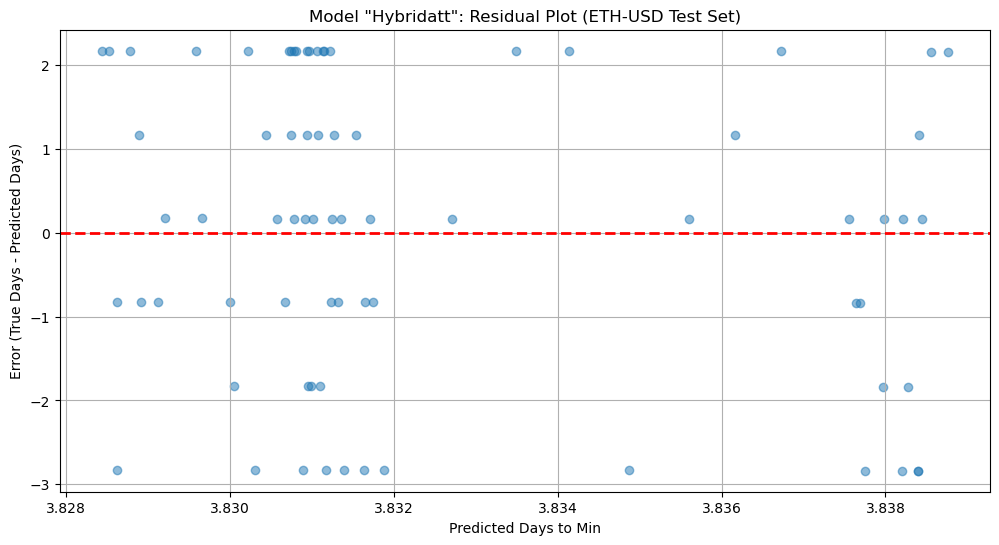


--- Final Model Evaluation Finished ---

--- Summarizing Final Test Results After Fix ---

Final Test Results Summary:


Symbol            Model     Status  Binary_Accuracy  Binary_ROC_AUC  \
0  ETH-USD             LSTM  Completed         0.589041        0.645736   
1  ETH-USD              GRU  Completed         0.589041        0.655039   
2  ETH-USD  Hybrid_LSTM_GRU  Completed         0.438356        0.440310   
3  ETH-USD              TCN  Completed         0.410959        0.376357   
4  ETH-USD         Mega TCN  Completed         0.630137        0.652713   
5  ETH-USD        Hybridatt  Completed         0.589041        0.638760   

   Regression_MAE  Regression_RMSE  Regression_MAPE  
0        1.528060         1.773809        70.417807  
1        1.495012         1.783482        73.497234  
2        1.619377         1.912962        67.087905  
3        1.517950         1.778151        71.643513  
4        1.501044         1.781619        73.099004  
5        1.514086         1.778248        71.928517


--- Summary Complete ---


In [383]:
# Re-run the evaluation
final_test_results = run_final_evaluation(
    symbols_to_process,
    model_builders,
    all_trained_models,
    all_symbols_processed_dfs_for_eda,
    all_symbols_modeling_data,
    TARGET_COLS_FINAL # Pass the target column list
)

# Display the summarized results again
print("\n--- Summarizing Final Test Results After Fix ---")
summary_list = []

if 'final_test_results' in globals() and final_test_results:
    for symbol, model_results in final_test_results.items():
        for model_name, results in model_results.items():
            summary_data = {
                'Symbol': symbol,
                'Model': model_name,
                'Status': results.get('status', 'N/A'),
                'Binary_Accuracy': results.get('binary_accuracy', np.nan),
                'Binary_ROC_AUC': results.get('binary_roc_auc', np.nan),
                'Regression_MAE': results.get('regression_mae', np.nan),
                'Regression_RMSE': results.get('regression_rmse', np.nan),
                'Regression_MAPE': results.get('regression_mape', np.nan),
            }
            summary_list.append(summary_data)

    if summary_list:
        results_summary_df = pd.DataFrame(summary_list)
        print("\nFinal Test Results Summary:")
        display(results_summary_df)
    else:
        print("No results found to summarize.")
        results_summary_df = pd.DataFrame()
else:
    print("The 'final_test_results' dictionary is not found or is empty.")
    results_summary_df = pd.DataFrame()

print("\n--- Summary Complete ---")